targets.shape=(64, 2)


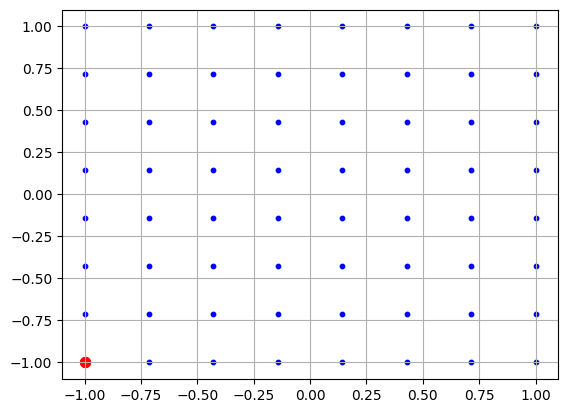

In [1]:
from matplotlib import pyplot as plt
from pprint import pp
import numpy as np

# Chose number of robots
k = int(8)
# Chose recharging proportionality constant
q_k = 0.1  # This means that each robot will need to charge for 10 minutes for every 100 minutes travelled
# Chose the number of targets in an axis
n = int(8)

# nodes = targets + depots
# Create a uniform (n*n, 2) numpy target grid for MAXIMUM SPEED
targets = np.mgrid[-1:1:n * 1j, -1.:1:n * 1j]
targets = targets.reshape(targets.shape + (1,))
targets = np.concatenate((targets[0], targets[1]), axis=2)
targets = targets.reshape((n*n, 2))
target_indices = range(len(targets))
print(f"{targets.shape=}")

# Specify depots
# One depot node in the corner
depots = np.array([
    [-1., -1.],
])
## Four depot nodes (one in each corner)
# depots = np.array([
#     [-1., -1.],
#     [-1., 1.],
#     [1., -1.],
#     [1., 1.1,
# ])
# depots = np.array([
#     [-1., -1.],
#     [-1., 1.],
#     [1., -1.],
#     [1., 1.],
# ])
# print(f"{depots=}")
depots = np.concatenate((depots, depots))
depot_indices = range(len(targets), len(targets)+len(depots))

nodes = np.concatenate((targets, depots))
# print(f"{nodes.shape=}")
node_indices = range(len(targets)+len(depots))

# print(f"{list(target_indices)=}\n{list(depot_indices)=}\n{list(node_indices)=}")

# Chose starting depot node
# Make all robots start from same depot
B_k = np.array([depot_indices[0]] * k)
# Make depots start from multiple depots
# B_k = depot_indices[:k]
# print(f"{B_k=}")

# Graphical sanity check
plt.figure()
plt.scatter(targets[:,0], targets[:,1], c='blue', s=10)
plt.scatter(depots[:,0], depots[:,1], c='red', s=50)
plt.grid()
plt.show()

In [2]:
import itertools

# Calculate c_{i,j} (c[i,j] is the cost (including recharging, q_k) from nodes i to j)
cost = np.zeros((len(node_indices),len(node_indices)))
for i, j in itertools.product(node_indices, node_indices):
    cost[i,j] = np.sqrt((nodes[i,0]-nodes[j,0]) ** 2 + (nodes[i,1]-nodes[j,1]) ** 2)
    # print(f"({i},{j}):({nodes[i,0]},{nodes[i,1]},{nodes[j,0]},{nodes[j,1]}): {cost[i,j]}")
print(f"{cost.shape=}")


cost.shape=(66, 66)


In [3]:
import gurobipy as gp
from gurobipy import GRB

m = gp.Model()

# A. Integer Constraints (4), (5)
# Note: All edges are now binary
x = m.addMVar((k,len(node_indices),len(node_indices)), name='x', vtype=GRB.BINARY)
# for ki in range(k):
#     for i in target_indices:
#         for j in target_indices:
#             if i == j: continue
#             _ = m.addConstr(x[ki,i,j] <= 1)
#         for j in depot_indices:
#             _ = m.addConstr(x[ki,i,j] <= 1)
#             _ = m.addConstr(x[ki,j,i] <= 1)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2421738
Academic license 2421738 - for non-commercial use only - registered to sd___@wpi.edu


In [4]:
# B. Degree Constraints (6), (7), (8), (9), (10)
# (6) and (7) Only one robot arrives to and leaves from a target (B_k is a depot, so we don't need to remove it from targets)
_ = m.addConstrs(x[:,i,:].sum() == 1 for i in target_indices)
_ = m.addConstrs(x[:,:,i].sum() == 1 for i in target_indices)

for ki in range(k):
    # (8) and (9) Begin and end at same position B_k
    # _ = m.addConstr(x[ki,B_k[ki,0],B_k[ki,1],:,:].sum() >= 1)
    _ = m.addConstr(x[ki,B_k[ki],:].sum() <= 1)
    # _ = m.addConstr(x[ki,:,:,B_k[ki,0],B_k[ki,1]].sum() >= 1)
    _ = m.addConstr(x[ki,:,B_k[ki]].sum() <= 1)

    # (10) Every robot that visits a target leaves the target
    _ = m.addConstrs((x[ki,:,i]-x[ki,i,:]).sum() == 0 for i in node_indices)

    # Additional constraint: no loopholes!
    _ = m.addConstrs(x[ki, i, i] == 0 for i in node_indices)

In [5]:
# C. Capacity and Flow Constraints (11), (12), (13), (14)
p = m.addMVar((k,len(node_indices),len(node_indices)), name='p', vtype=GRB.INTEGER, lb=0, ub=len(target_indices))

for ki in range(k):
    # (11) and (12) flow constraints
    right_side = 0
    for i, j in itertools.product(target_indices, node_indices):
        right_side += x[ki,i,j]
    _ = m.addConstr((p[ki,B_k[ki],:] - p[ki,:,B_k[ki]]).sum() == right_side)

    for i in target_indices:
        _ = m.addConstr((p[ki,:,i] - p[ki,i,:]).sum() == x[ki,i,:].sum())

    # (13) Make sure target capacity doesn't change when passing through a depot
    # Note: Disable for now because we only have one depot which is the starting point
    for i in depot_indices:
        if i == B_k[ki]: continue  # Why? See: https://github.com/NESTLab/mrpcp#linear-constraints
        left_side = 0
        for j in node_indices:
            if i == j: continue
            left_side += p[ki,j,i] - p[ki,i,j]
        _ = m.addConstr(left_side == 0)

    # (14) Ensure that target capacity for each robot doesn't exceed |T|
    _ = m.addConstrs(p[ki,i,j] <= len(target_indices) * x[ki,i,j] for i in node_indices for j in node_indices)

In [6]:
# # D. Fuel Constraints (15), (16), (17), (18), (19), (20)
max_fuel_cost_to_node = np.sqrt(8)  # √8 is the max possible distance between our nodes (-1, -1) and (1, 1)
L = max_fuel_cost_to_node * 2.  # Fuel capacity (1 unit of fuel = 1 unit of distance)
M = L + max_fuel_cost_to_node
r = m.addMVar((len(node_indices)), name='r', vtype=GRB.CONTINUOUS, lb=0, ub=L) # (20)

for ki in range(k):
    # (15) and (16)
    for i, j in itertools.product(target_indices, target_indices):
        left_side = r[j] - r[i] + cost[i,j]
        right_side = M * (1 - x[ki,i,j])
        _ = m.addConstr(left_side <=  right_side)
        _ = m.addConstr(left_side >= -right_side)

    # (17) and (18)
    for i, j in itertools.product(depot_indices, target_indices):
        left_side = r[j] - L + cost[i,j]
        right_side = M * (1 - x[ki,i,j])
        _ = m.addConstr(left_side >= -right_side)
        _ = m.addConstr(left_side <=  right_side)

        # (19)
        _ = m.addConstr(r[j] - cost[j,i] >= -M * (1 - x[ki,j,i]))

In [7]:
# Set objective function (3)
p_max = m.addVar(vtype=GRB.CONTINUOUS, name="p_max")
_ = m.addConstrs((cost * x[ki]).sum() <= p_max for ki in range(k))
m.setObjective(p_max)

In [8]:
# import datetime
def visualize_paths_brute_force(edges):
    # Only plot the paths for the robots that were assigned a path
    active_robots = []
    for ki in range(k):
        if (cost * edges[ki]).sum() > 0.01:
            active_robots.append(ki)

    subplot_per_hor_axis = int(np.ceil(np.sqrt(len(active_robots))))
    subplot_per_vert_axis = int(np.ceil(len(active_robots) / subplot_per_hor_axis))
    fig, axs = plt.subplots(subplot_per_hor_axis, subplot_per_vert_axis, figsize=(subplot_per_hor_axis * 4, subplot_per_vert_axis * 4))
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.1, top=0.9, right=0.9, left=0.1, wspace=0.3, hspace=0.3)

    hor_i = 0
    vert_i = 0
    for robot_i, ki in enumerate(active_robots):
        # print(f"Robot #{ki}\n-------")
        # print(f"Staring position: {B_k[ki]} -> {[nodes[B_k[ki, 0], B_k[ki, 1], 0], nodes[B_k[ki, 0], B_k[ki, 1], 1]]}")
        if subplot_per_hor_axis == 1 and subplot_per_vert_axis == 1:
            ax = axs
        elif subplot_per_vert_axis == 1:
            ax = axs[hor_i]
        else:
            ax = axs[hor_i][vert_i]
        ax.set_title(f"Robot #{robot_i+1} (cost={(cost * edges[ki]).sum():.3f})")
        ax.scatter(targets[:,0], targets[:,1], c='blue', s=10)
        ax.scatter(depots[:,0], depots[:,1], c='red', s=50)
        ax.scatter(nodes[B_k[ki], 0], nodes[B_k[ki], 1], c='red', s=100)

        for i, j in itertools.product(node_indices, node_indices):
            if edges[ki,i,j] > 0.5:  # In case there is any floating math errors
                # print(f"Connection from {[i1,j1]} to {[i2,j2]}")
                ax.scatter(nodes[i, 0], nodes[i, 1], c="purple", s=8)
                ax.scatter(nodes[j, 0], nodes[j, 1], c="purple", s=8)
                ax.plot([nodes[i, 0], nodes[j, 0]], [nodes[i, 1], nodes[j, 1]], color="purple", linewidth=1)

        vert_i += 1
        if vert_i >= subplot_per_vert_axis:
            vert_i = 0
            hor_i += 1
        ax.grid()

    for h in range(subplot_per_hor_axis):
        for v in range(subplot_per_vert_axis):
            if subplot_per_hor_axis == 1 and subplot_per_vert_axis == 1:
                ax = axs
            elif subplot_per_vert_axis == 1:
                ax = axs[h]
            else:
                ax = axs[h][v]
            ax.set_box_aspect(1)

    fig.suptitle(f"Paths for all robots (# of active/available robots={len(active_robots)}/{k}, sum of costs={(cost * edges).sum():.3f})")
    # fig.savefig(f"../../data/2015_mrpcp_k={k}_n={n}_{datetime.datetime.now().strftime('%Y-%m-%d-%H:%M:%S')}.png")
    plt.show()

In [9]:
def calculate_total_distance(path, cost_matrix):
    total_cost = 0
    for i in range(len(path) - 1):
        total_cost += cost_matrix[path[i], path[i + 1]]
    total_cost += cost_matrix[path[-1], path[0]]  # Return to start
    return total_cost

def two_opt(route, cost_matrix):
    best_distance = calculate_total_distance(route, cost_matrix)
    best_route = route.copy()

    improved = True
    while improved:
        improved = False
        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route)):
                if j - i == 1: continue  # Skip adjacent edges
                new_route = route.copy()
                new_route[i:j] = route[j - 1:i - 1:-1]  # Reverse the segment between i and j
                new_distance = calculate_total_distance(new_route, cost_matrix)

                if new_distance < best_distance:
                    best_distance = new_distance
                    best_route = new_route.copy()
                    improved = True

        route = best_route.copy()

    return best_route, best_distance

def k_opt(route, cost_matrix, k):
    best_distance = calculate_total_distance(route, cost_matrix)
    best_route = route.copy()

    improved = True
    while improved:
        improved = False
        for i in range(1, len(route) - 1):
            for j in range(i + 1, len(route)):
                if j - i < k - 1:
                    continue  # Ensure the segment size is at least k

                new_route = route.copy()
                new_route[i:j] = reversed(route[i:j])  # Reverse the segment between i and j

                new_distance = calculate_total_distance(new_route, cost_matrix)

                if new_distance < best_distance:
                    best_distance = new_distance
                    best_route = new_route.copy()
                    improved = True

        route = best_route.copy()

    return best_route, best_distance



def extract_and_calculate_milp_costs(x, start_nodes, num_robots, num_nodes, cost_matrix):
    milp_costs = []
    milp_paths = []

    for ki in range(num_robots):
        current_node = start_nodes[ki]  # Start at the robot's starting node
        path = [current_node]  # Initialize path with start node
        visited = {current_node}  # Set to keep track of visited nodes

        while len(visited) < num_nodes:
            next_node = np.argmax(x[ki, current_node, :])
            if next_node in visited:
                break  # Avoid revisiting nodes
            path.append(next_node)
            visited.add(next_node)
            current_node = next_node

        milp_paths.append(path)
        milp_costs.append(calculate_path_cost(path, cost_matrix))

    return milp_paths, milp_costs


def visualize_individual_paths(paths, nodes, targets, depots, B_k, costs):
    num_robots = len(paths)
    num_rows = (num_robots + 1) // 2  # Two plots per row
    fig, axs = plt.subplots(num_rows, 2, figsize=(10, 5 * num_rows))  # Adjust the figure size as needed

    # Flatten the axs array for easy iteration if there's more than one row
    if num_robots > 2:
        axs = axs.flatten()

    for index, path in enumerate(paths):
        ax = axs[index]

        # Plot targets and depots
        ax.scatter(targets[:, 0], targets[:, 1], c='blue', s=10, label='Targets')
        ax.scatter(depots[:, 0], depots[:, 1], c='red', s=50, label='Depots')

        # Plot path for this robot
        for i in range(len(path) - 1):
            start_node = path[i]
            end_node = path[i + 1]
            ax.plot([nodes[start_node, 0], nodes[end_node, 0]],
                    [nodes[start_node, 1], nodes[end_node, 1]],
                    color="purple", linewidth=1)
            ax.scatter(nodes[start_node, 0], nodes[start_node, 1], c="purple", s=8)

        # Plot a line returning to the starting depot
        ax.plot([nodes[path[-1], 0], nodes[B_k[0], 0]],
                [nodes[path[-1], 1], nodes[B_k[0], 1]],
                color="purple", linewidth=1, linestyle="--", label='Return to Depot')

        # Set title with cost
        ax.set_title(f"Robot #{index + 1} (Cost: {costs[index]:.2f})")
        ax.grid()
        ax.legend()

    # Hide any unused subplots
    for i in range(index + 1, num_rows * 2):
        fig.delaxes(axs[i])

    # plt.tight_layout()
    fig.suptitle(f"Paths for all robots (sum of costs={sum(costs):.3f})")
    plt.show()

def calculate_path_cost(path, cost_matrix):
    total_cost = 0
    for i in range(len(path) - 1):
        total_cost += cost_matrix[path[i], path[i + 1]]
    # Add cost of returning to the starting depot
    total_cost += cost_matrix[path[-1], path[0]]
    return total_cost

In [10]:
import gurobipy as grb

class MILPSolver:
    min_cost_edges = None
    min_cost = np.inf
    selected_nodes = None

    def __init__(self, model, num_threads=1):
        self.model = model
        MILPSolver.selected_nodes = []
        self.num_threads = num_threads
        
    @staticmethod
    def cb(what, where):
        if where == GRB.Callback.MIPSOL and what.cbGet(GRB.Callback.MIPSOL_OBJ) < MILPSolver.min_cost:
            MILPSolver.min_cost = what.cbGet(GRB.Callback.MIPSOL_OBJ)
            print(f"Found a new solution with lower cost({MILPSolver.min_cost:.3f})!")
            MILPSolver.min_cost_edges = what.cbGetSolution(what._x)
            visualize_paths_brute_force(MILPSolver.min_cost_edges)

            # If this solution's maximum costing tour ~= the cost of the tour that only travels between depot and the furthest node,
            # then, this is guaranteed to be optimal.
            if (MILPSolver.min_cost - max_fuel_cost_to_node * 2) < 0.01:
                print("!This is guaranteed to be the optimal solution!")
                what.terminate()

    def solve(self):
        self.model.optimize(MILPSolver.cb)


Number of available CPU threads: 20
Set parameter Threads to value 15
Set parameter Threads to value 15
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i9-10900K CPU @ 3.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 15 threads

Academic license 2421738 - for non-commercial use only - registered to sd___@wpi.edu
Optimize a model with 105192 rows, 69763 columns and 578712 nonzeros
Model fingerprint: 0xea0c11c4
Variable types: 67 continuous, 69696 integer (34848 binary)
Coefficient statistics:
  Matrix range     [3e-01, 6e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 1e+01]
Presolve removed 4970 rows and 1050 columns
Presolve time: 0.95s
Presolved: 100222 rows, 68713 columns, 569286 nonzeros
Variable types: 65 continuous, 68648 integer (34328 binary)
Found a new solution with lower cost(200.119)!


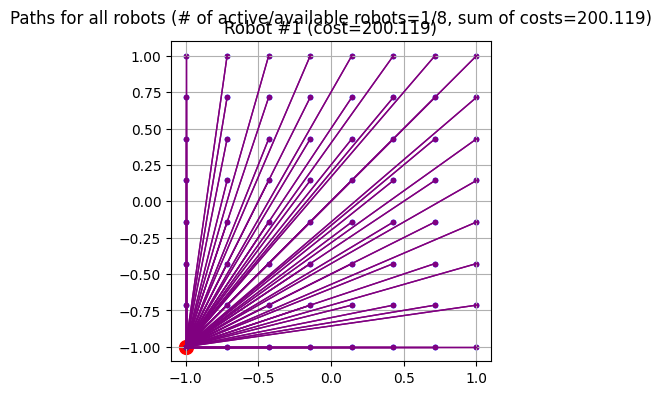

Found heuristic solution: objective 200.1192470
Found a new solution with lower cost(196.643)!


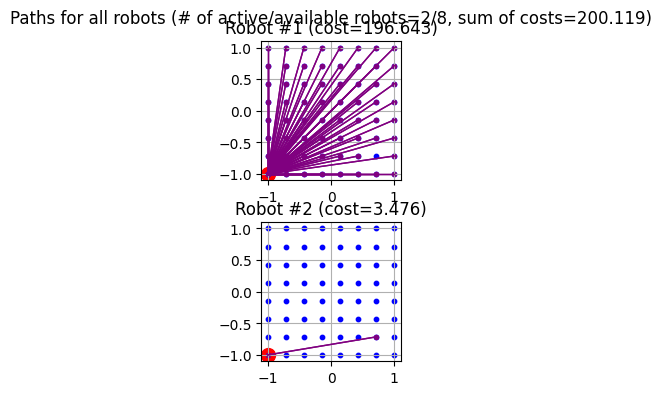

Found heuristic solution: objective 196.6433827
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...
Ordering time: 0.03s

Barrier statistics:
 Dense cols : 64
 AA' NZ     : 1.455e+05
 Factor NZ  : 2.032e+05 (roughly 10 MB of memory)
 Factor Ops : 1.340e+07 (less than 1 second per iteration)
 Threads    : 13

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.30580078e+02 -2.43084963e+05  5.61e+02 3.16e-02  4.89e+01     5s
   1   3.85379287e+01 -1.33711431e+05  3.37e+01 6.22e-15  6.37e+00     5s
   2   1.33698590e+01 -1.98564715e+04  3.52e+00 4.35e-14  8.07e-01     5s
   3   1.13992320e+01 -1.66506343e+03  8.88e-15 3.39e-14  5.62e-02     5s
   4   1.11636376e+01 -2.26761731e+01  3.04e-13 3.25e-15  1.13e-03     5s
   5   8.65529323e+00 -1.02787616e+01  1.40e-12 1.69e-15  6.35e-04     5s
   6   5.25137793e+00 -3.99578121e+00  6.0

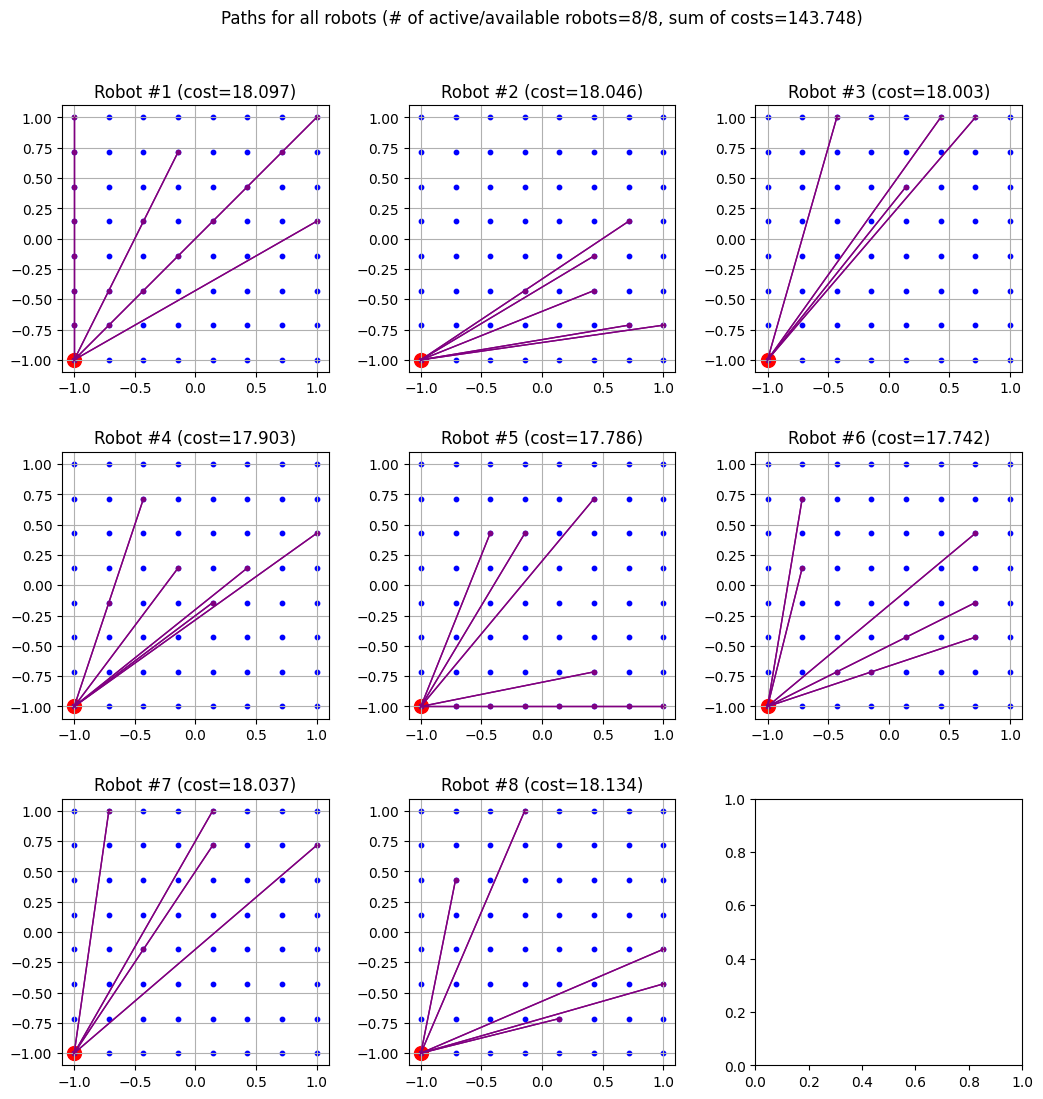

H    0     0                      18.1335893    2.28539  87.4%     -   20s
     0     0    2.28539    0 1030   18.13359    2.28539  87.4%     -   64s
Found a new solution with lower cost(18.037)!


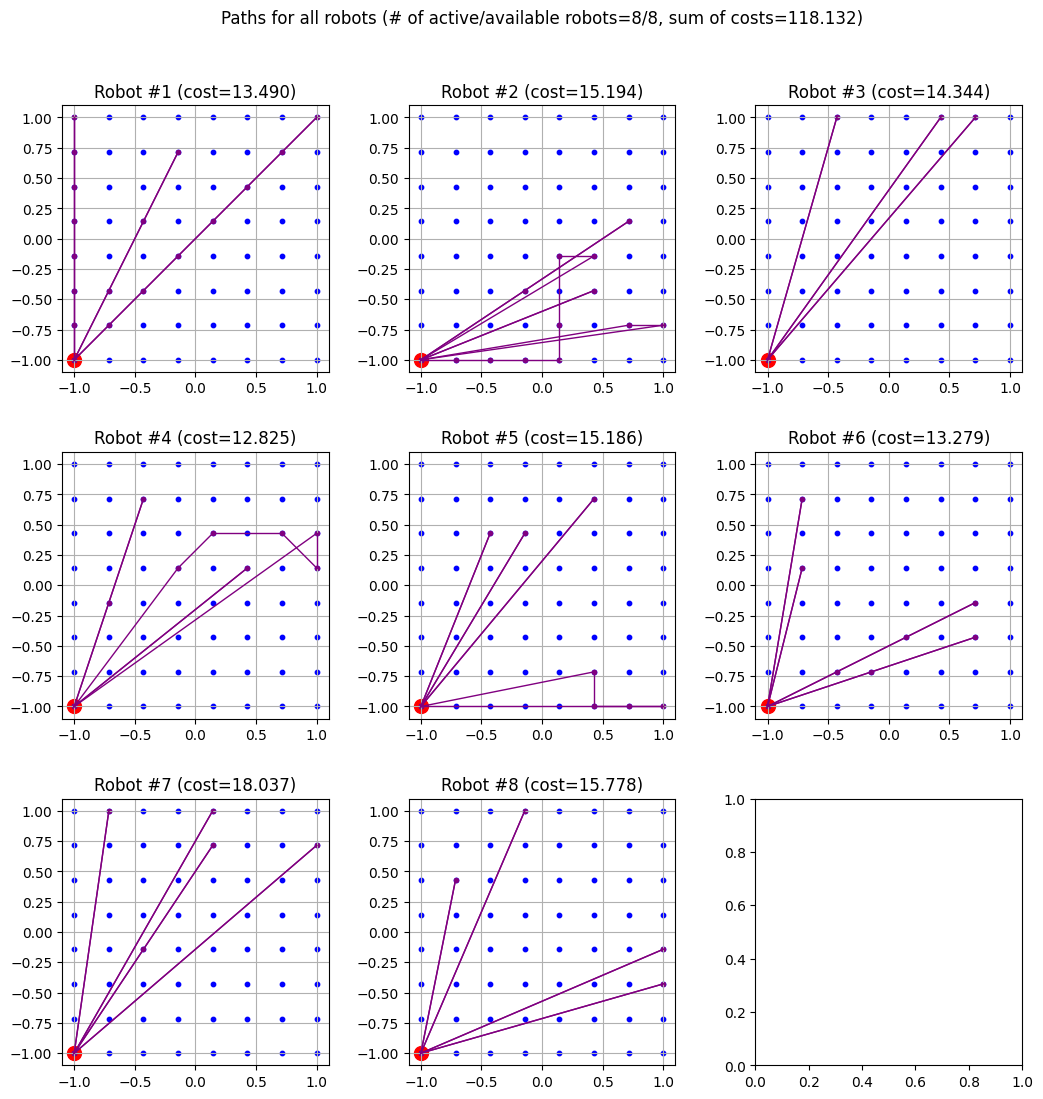

H    0     0                      18.0365558    2.28539  87.3%     -  121s
     0     0    2.28539    0 1088   18.03656    2.28539  87.3%     -  142s
     0     0    2.28539    0 1075   18.03656    2.28539  87.3%     -  200s
     0     0    2.28539    0 1033   18.03656    2.28539  87.3%     -  211s
     0     0    2.28539    0 1011   18.03656    2.28539  87.3%     -  228s
Found a new solution with lower cost(10.234)!


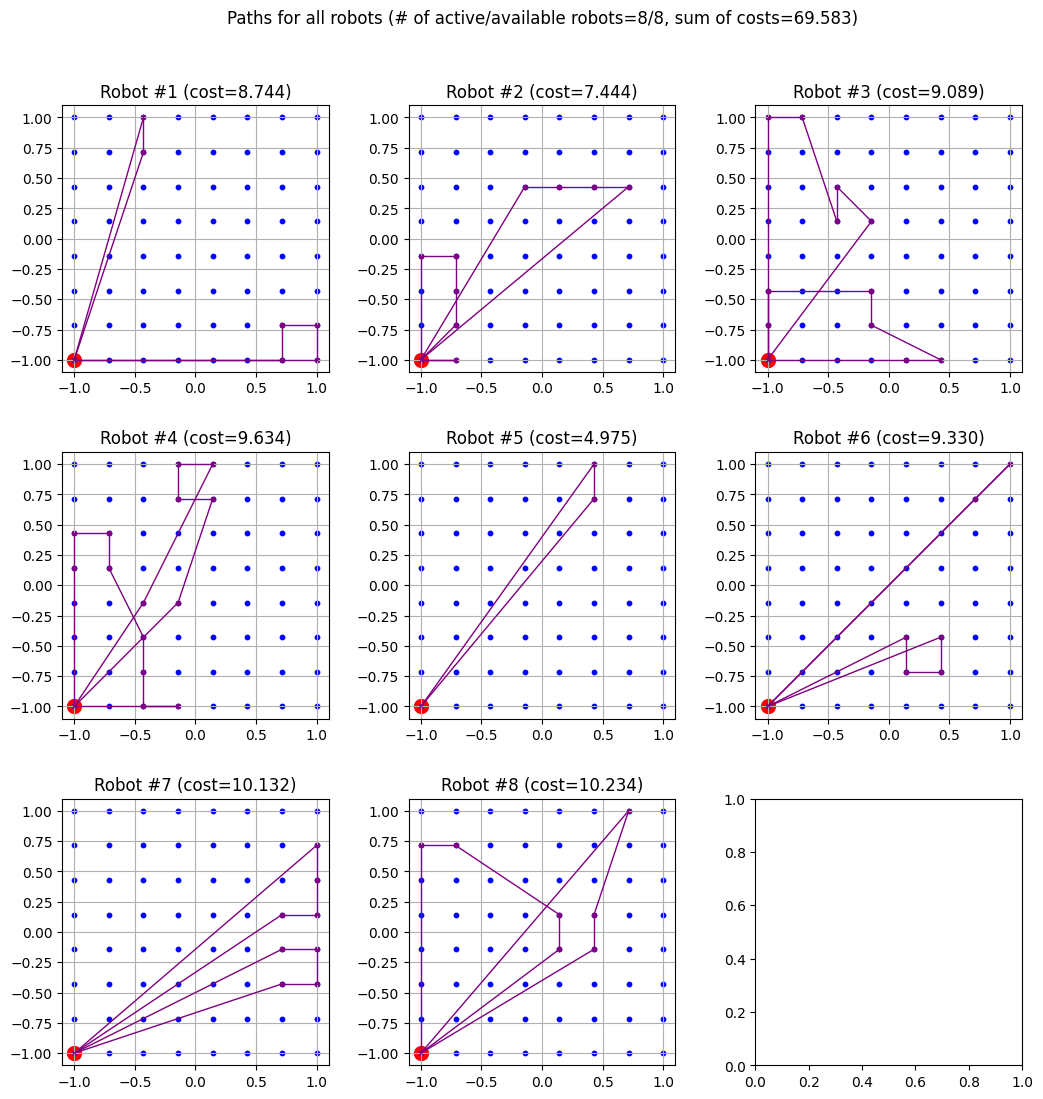

H    0     0                      10.2338072    2.28539  77.7%     -  234s
     0     0    2.28539    0  980   10.23381    2.28539  77.7%     -  263s
     0     0    2.28539    0  964   10.23381    2.28539  77.7%     -  291s
     0     0    2.28539    0  964   10.23381    2.28539  77.7%     -  296s
Found a new solution with lower cost(9.454)!


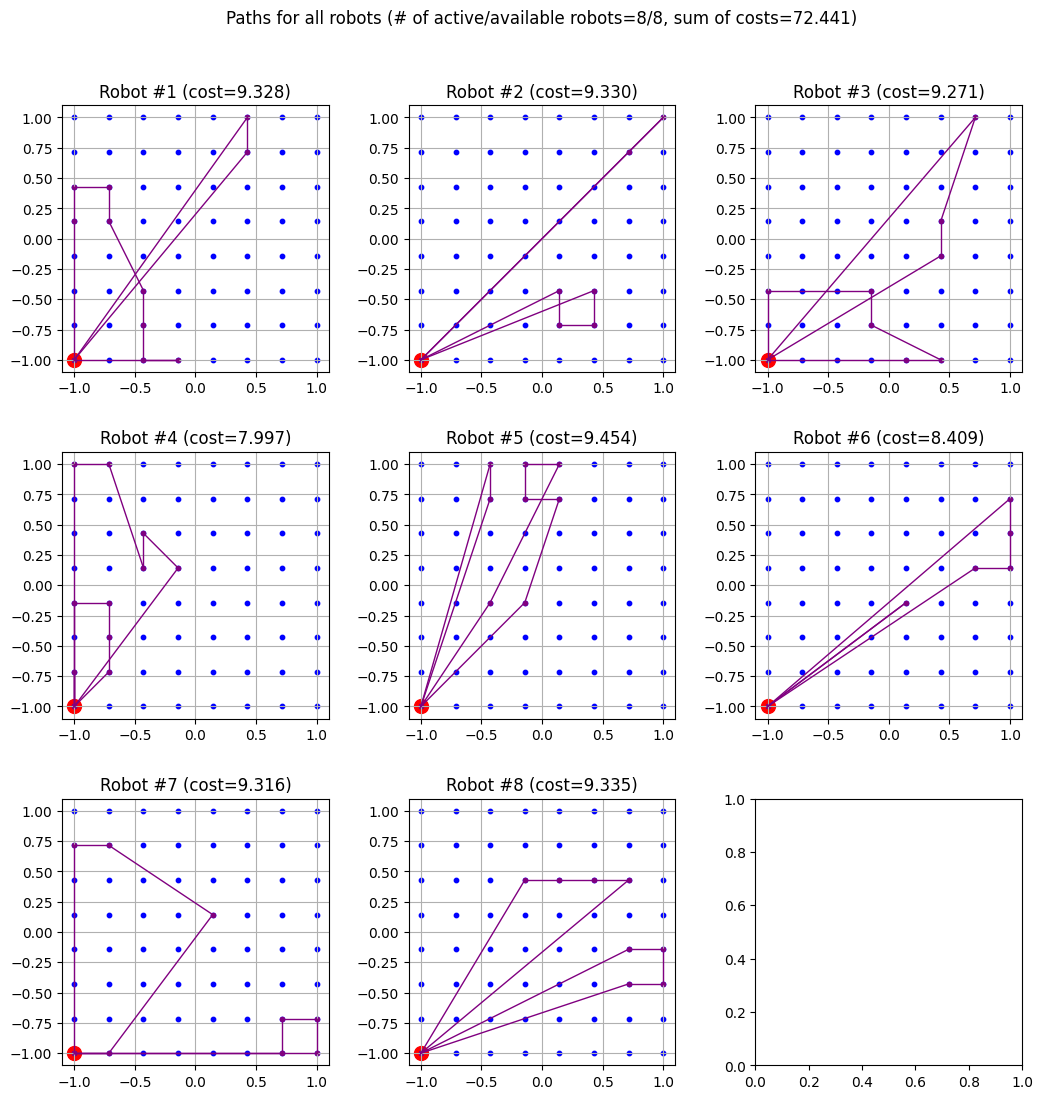

H    0     0                       9.4535050    2.28539  75.8%     -  450s
     0     2    2.28539    0  964    9.45351    2.28539  75.8%     -  465s
     1     4    2.28539    1  920    9.45351    2.28539  75.8% 24200  511s
     3     8    2.28539    2  882    9.45351    2.28539  75.8% 21969  637s
     7    16    2.28539    3  835    9.45351    2.28539  75.8% 23445  845s
    15    31    2.28539    4  998    9.45351    2.28539  75.8% 24744 1446s
Found a new solution with lower cost(9.335)!


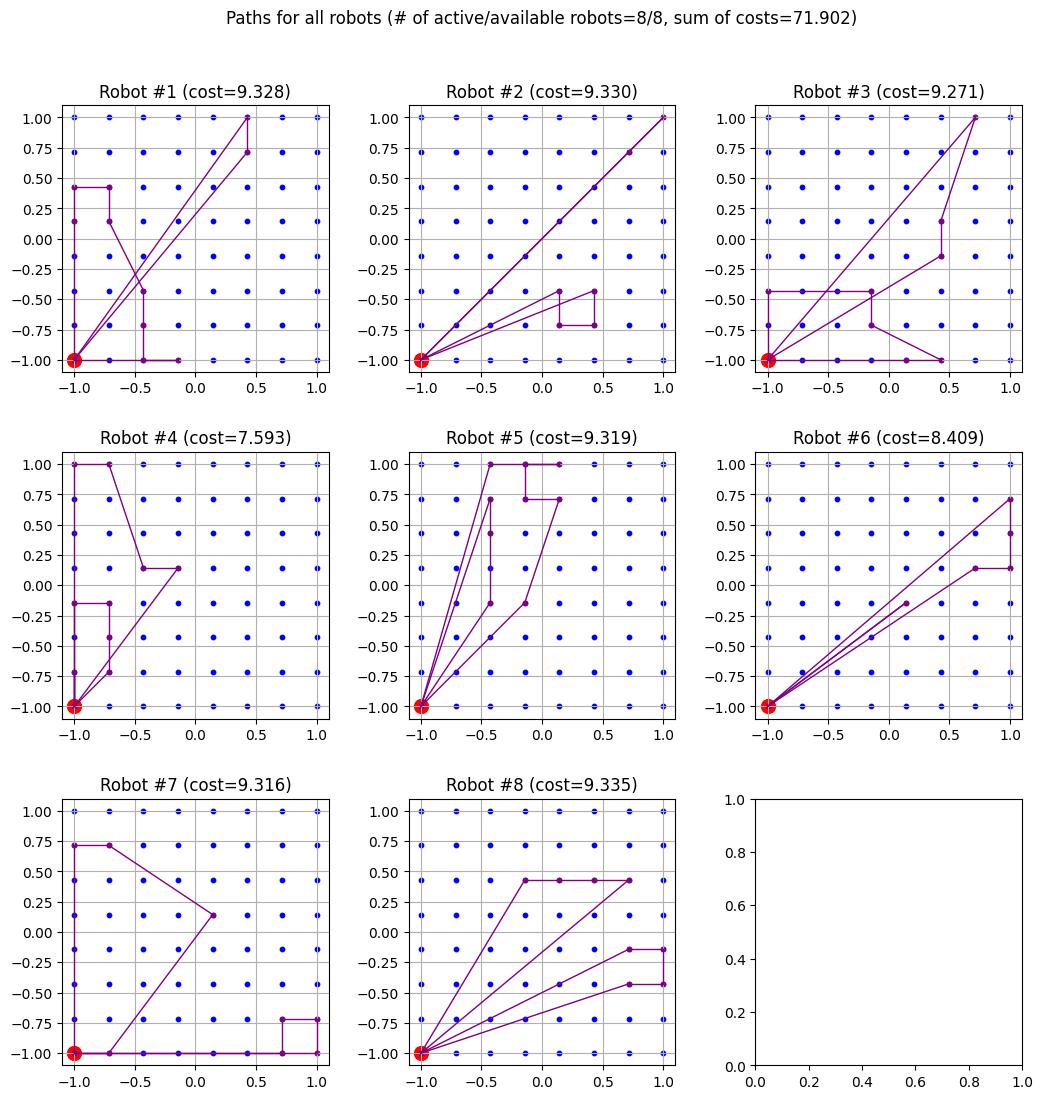

H   30    46                       9.3354174    2.28539  75.5% 32271 3274s
    45    59    2.28539    6  875    9.33542    2.28539  75.5% 33959 3770s
    60    71    2.28539    7  864    9.33542    2.28539  75.5% 30460 4056s
Found a new solution with lower cost(9.335)!


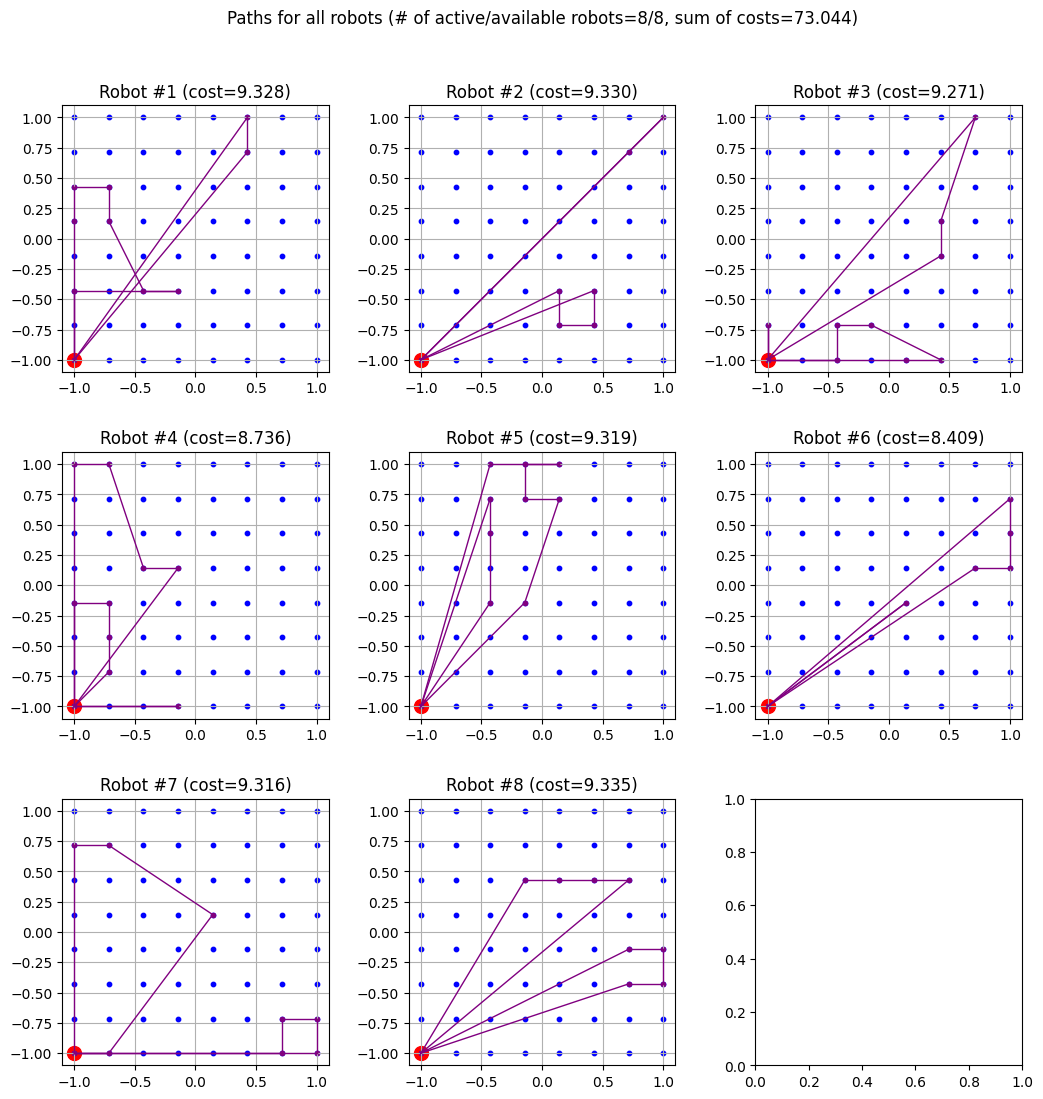

H   75    88                       9.3354174    2.28539  75.5% 27262 4425s
Found a new solution with lower cost(9.328)!


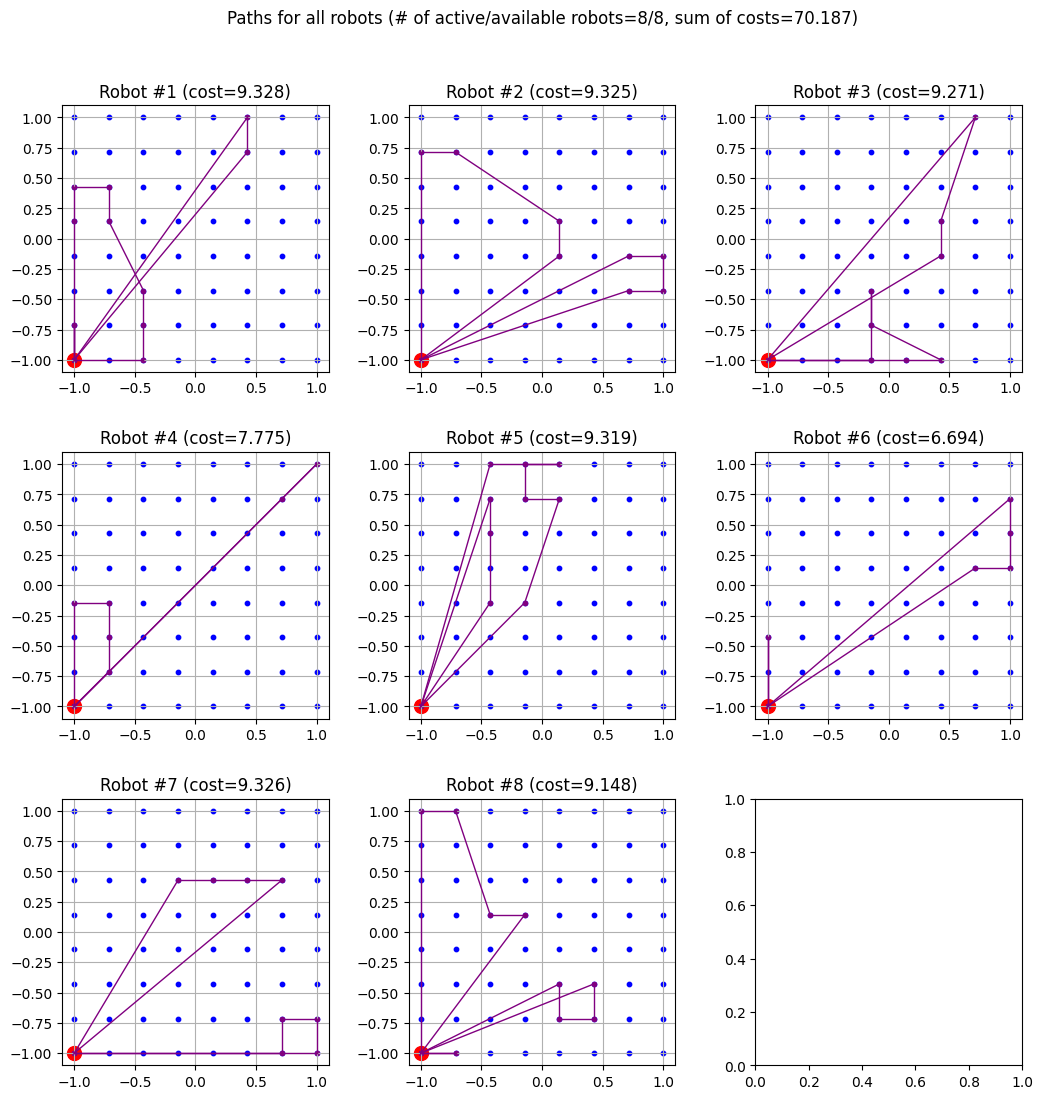

H   85    88                       9.3281837    2.28539  75.5% 26028 4427s
    92   102    2.28539    8  854    9.32818    2.28539  75.5% 25748 4809s
   107   146    2.28539    8  966    9.32818    2.28539  75.5% 25254 5639s
Found a new solution with lower cost(9.326)!


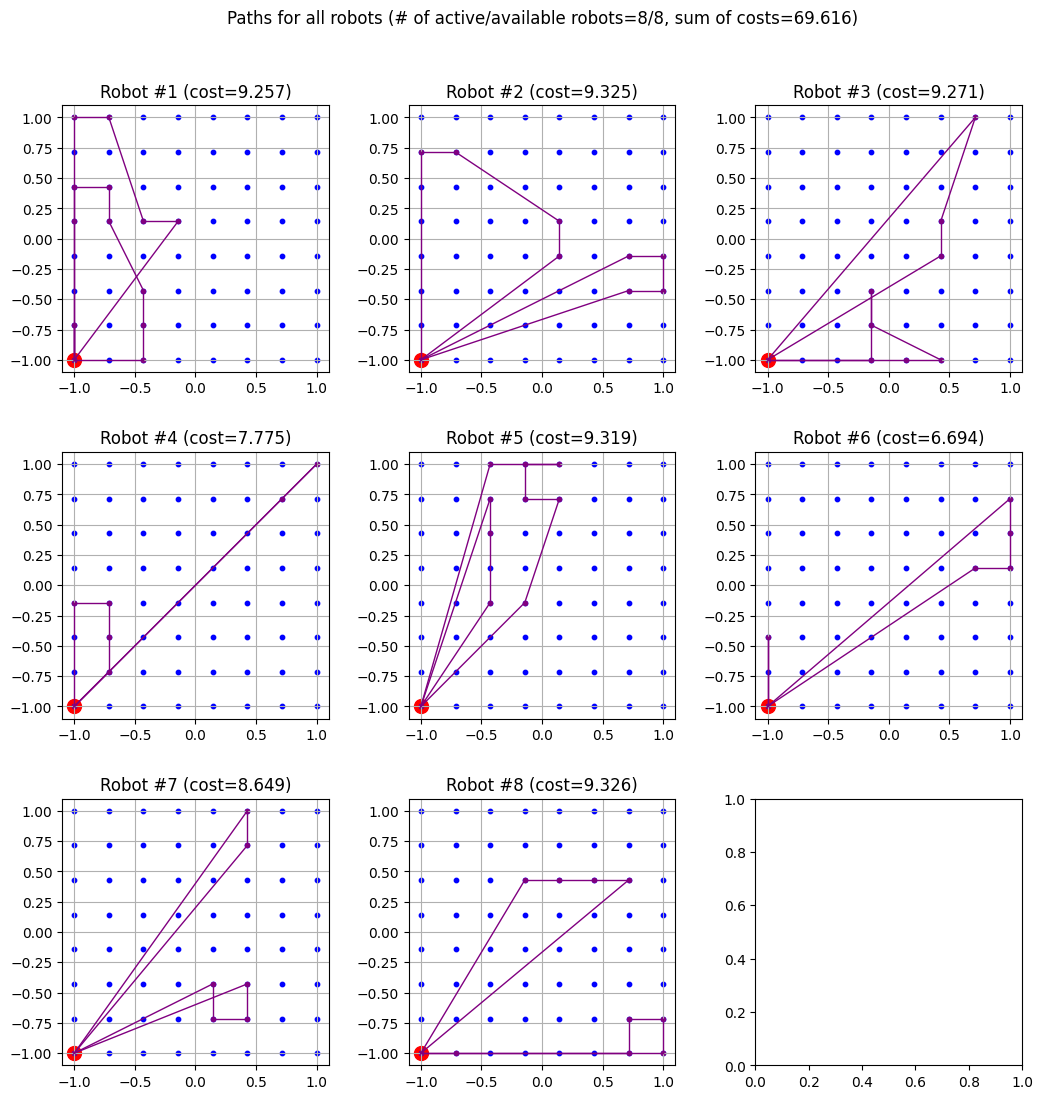

H  154   249                       9.3260576    2.28539  75.5% 22138 7613s
Found a new solution with lower cost(9.326)!


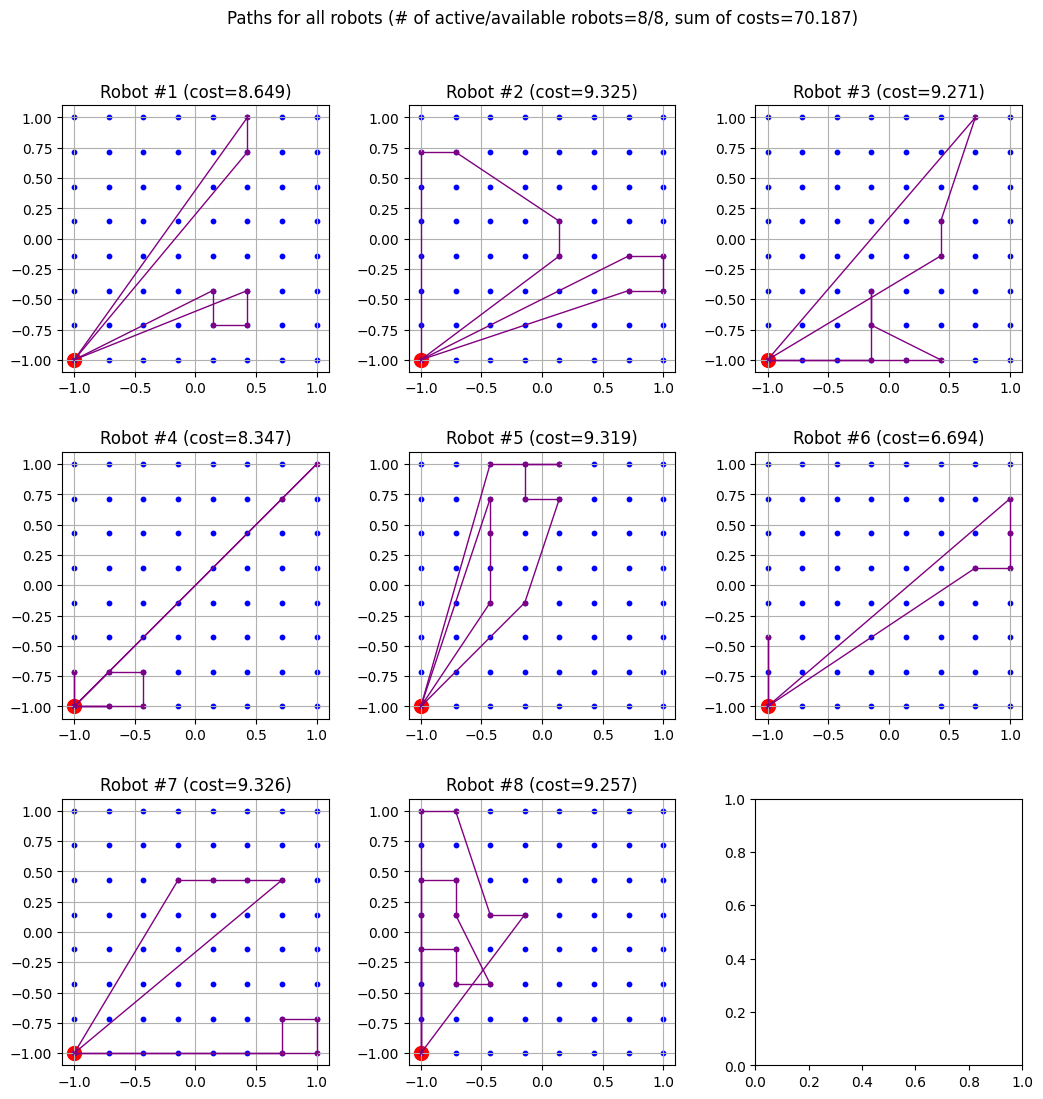

H  166   249                       9.3260569    2.28539  75.5% 22166 7615s
   261   567    2.28539   16  851    9.32606    2.28539  75.5% 21248 11597s
Found a new solution with lower cost(9.313)!


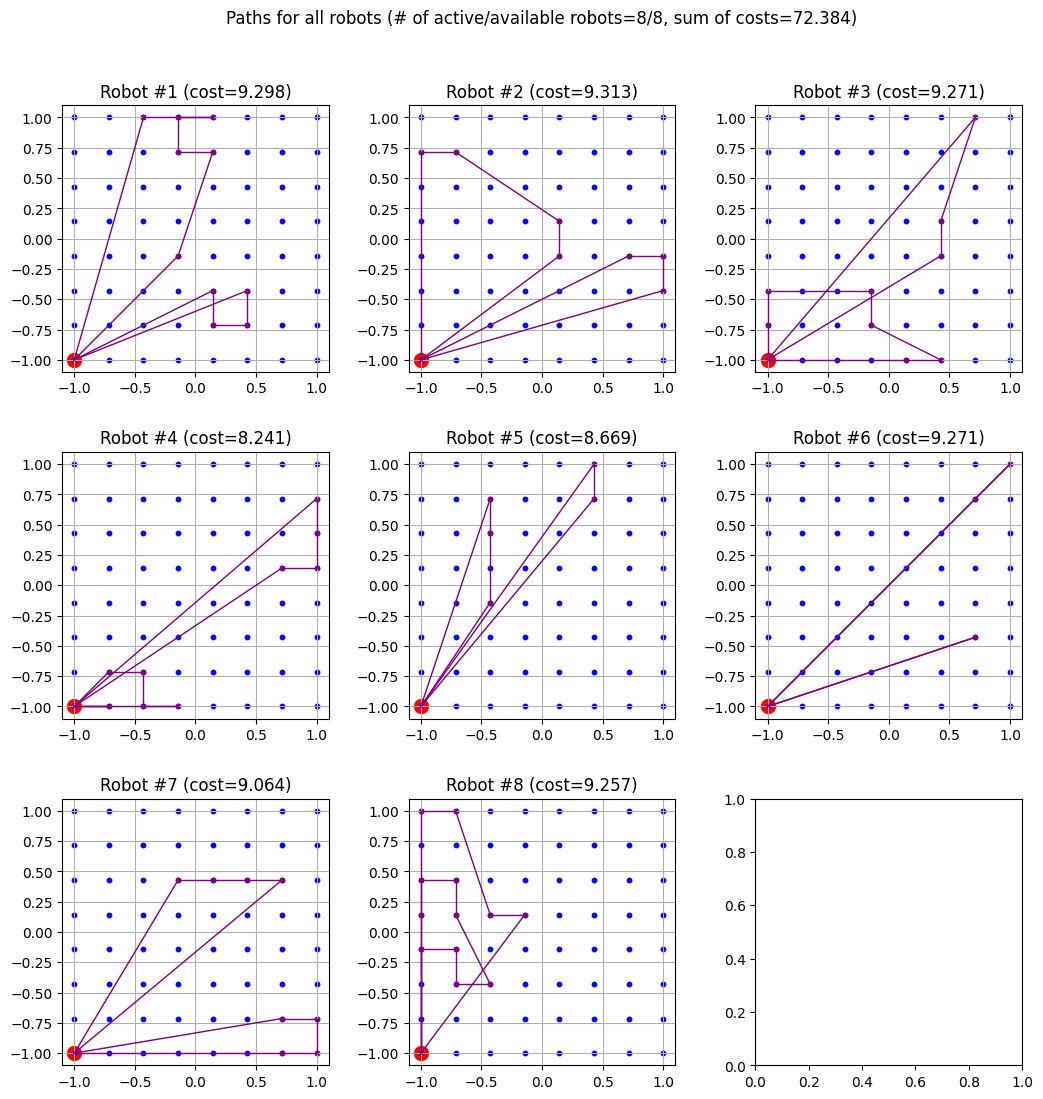

H  553   567                       9.3125329    2.28539  75.5% 15762 11599s
   595  1004    2.28777   24  782    9.31253    2.28539  75.5% 14781 15420s
Found a new solution with lower cost(9.313)!


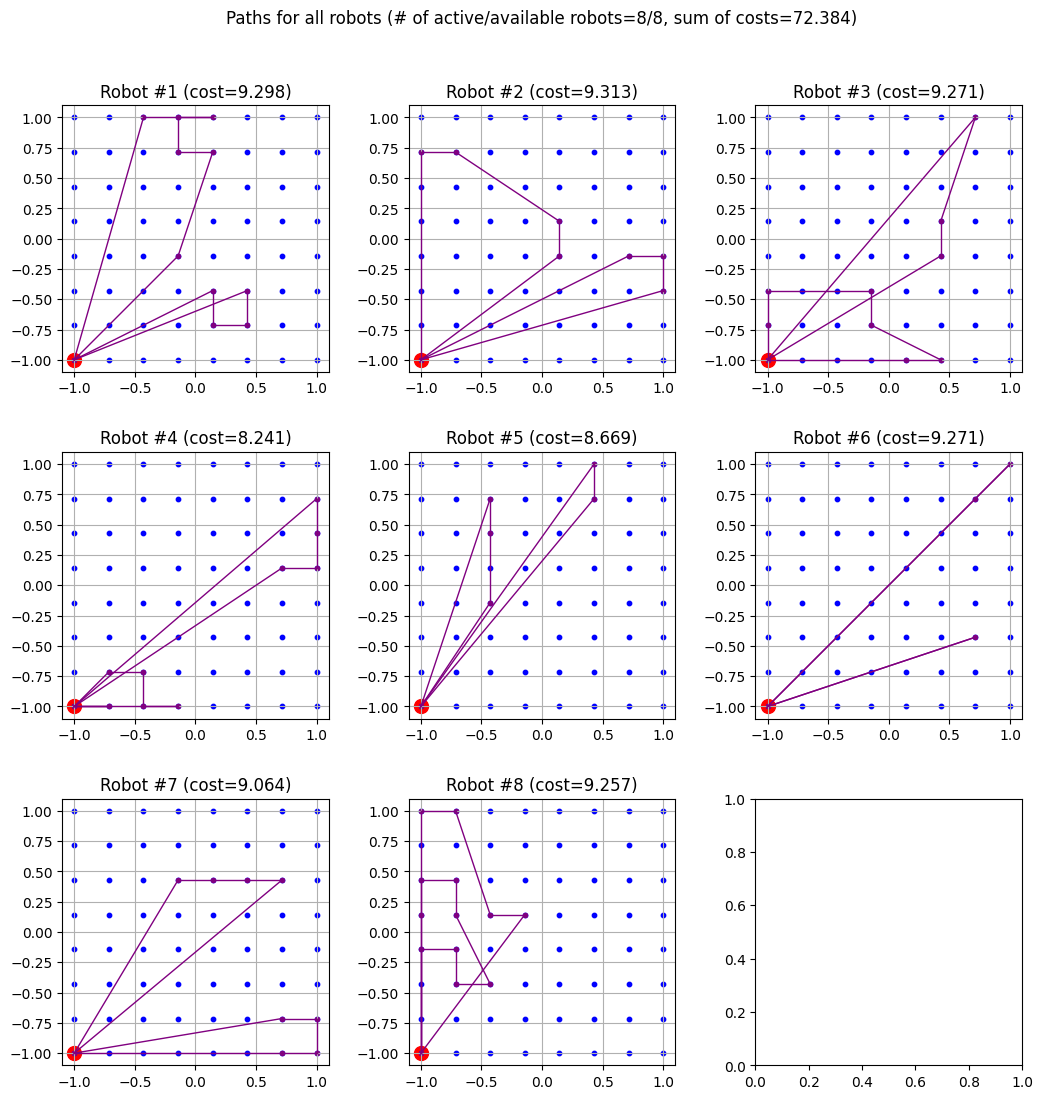

H  609  1004                       9.3125323    2.28539  75.5% 14752 15422s
Found a new solution with lower cost(9.313)!


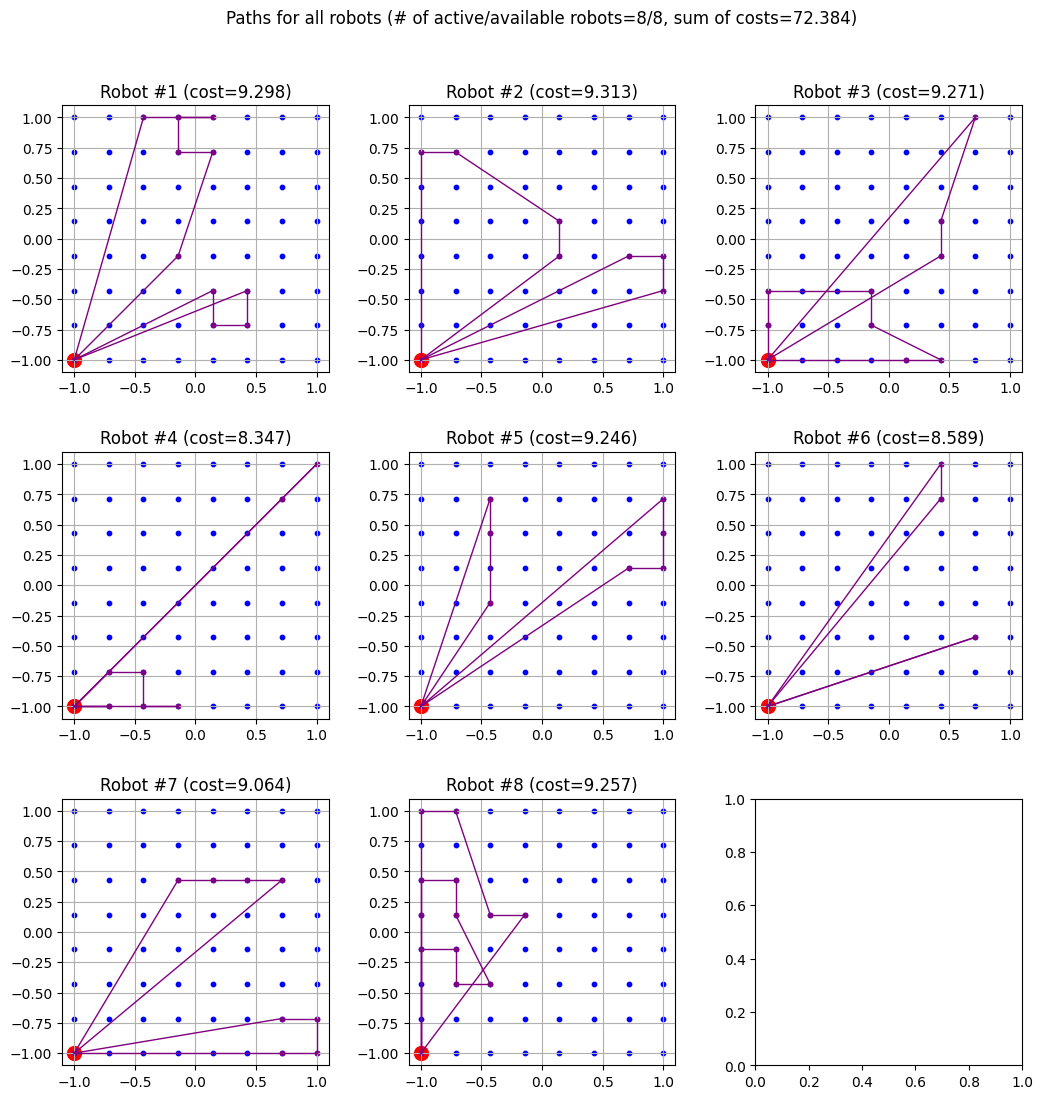

H  693  1004                       9.3125322    2.28539  75.5% 14558 15424s
  1083  1940    2.31451   32  707    9.31253    2.28539  75.5% 11075 18506s
Found a new solution with lower cost(9.298)!


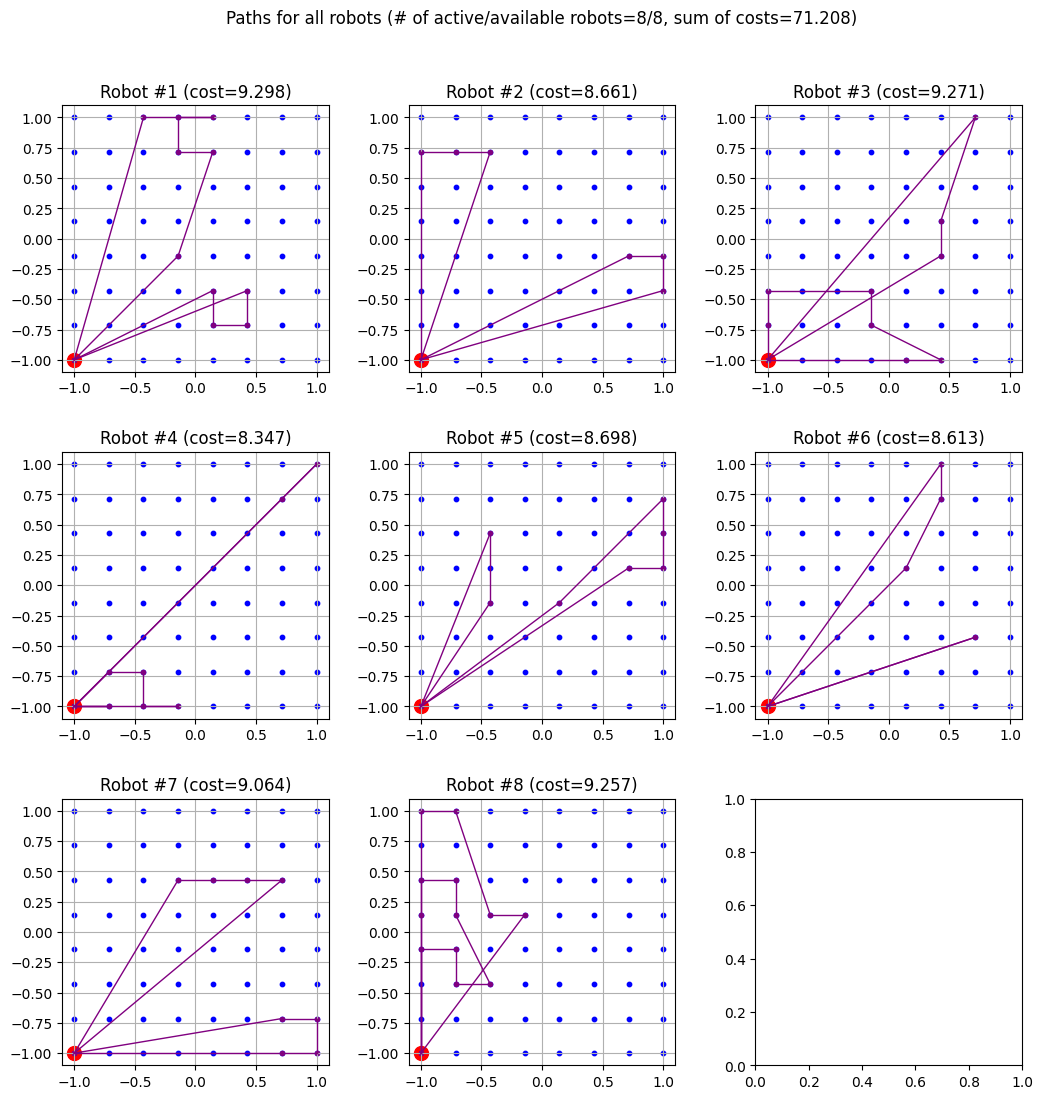

H 1277  1940                       9.2978083    2.28539  75.4% 10488 18508s
Found a new solution with lower cost(9.172)!


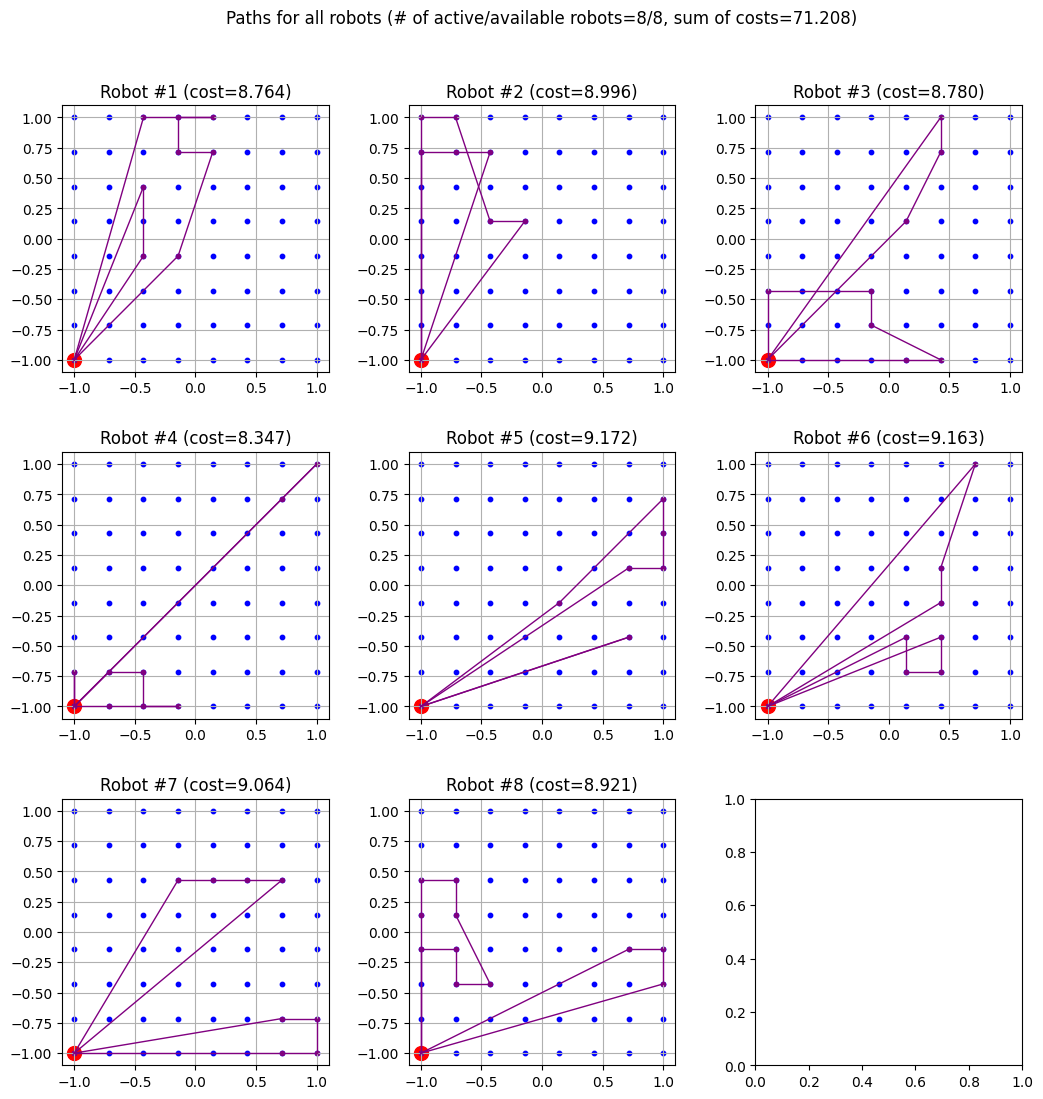

H 2094  3095                       9.1722440    2.28539  75.1%  7830 20816s
Found a new solution with lower cost(9.103)!


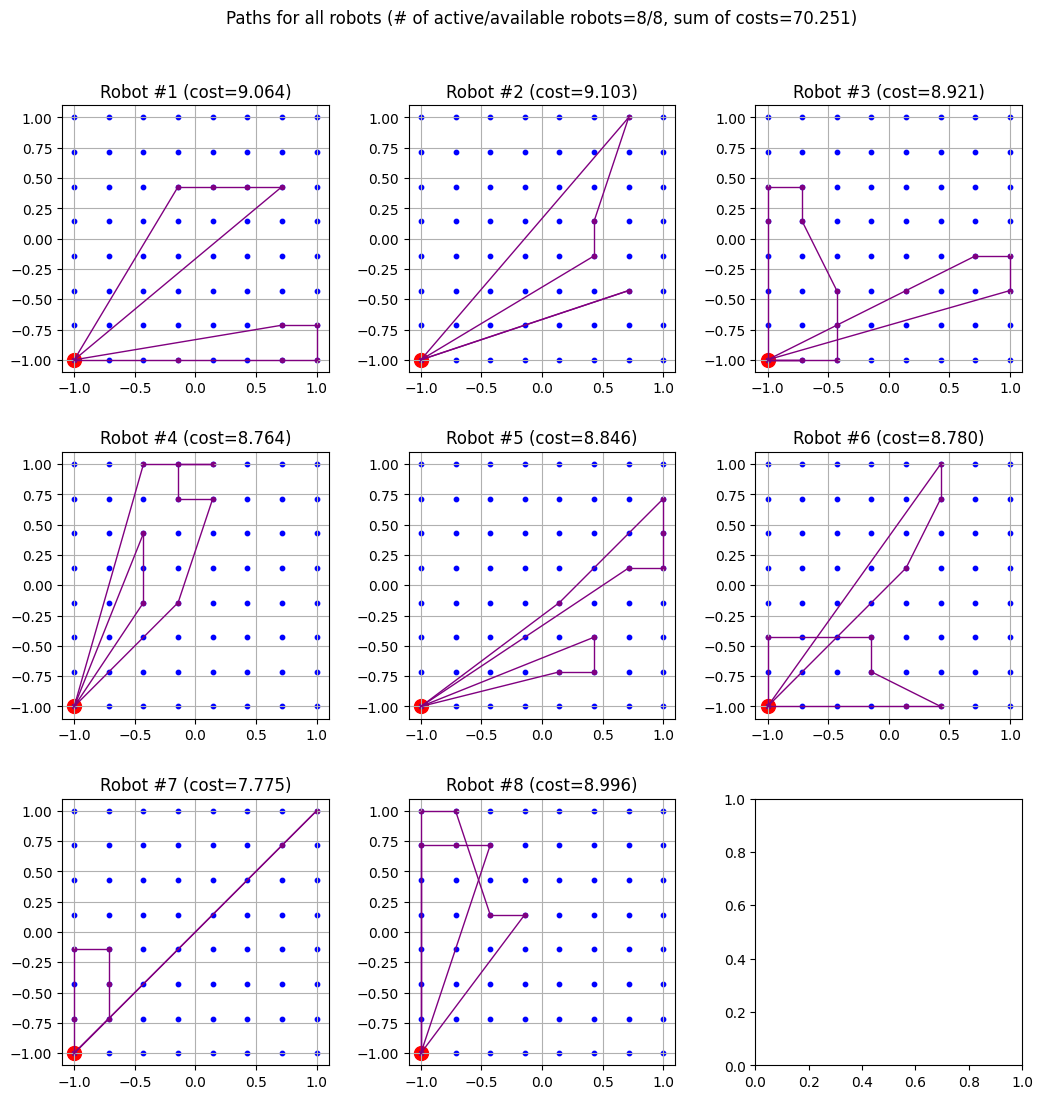

H 3275  3095                       9.1033956    2.28539  74.9%  5972 20818s
  3380  3890    2.48992  121  610    9.10340    2.28539  74.9%  5856 22527s
Found a new solution with lower cost(9.064)!


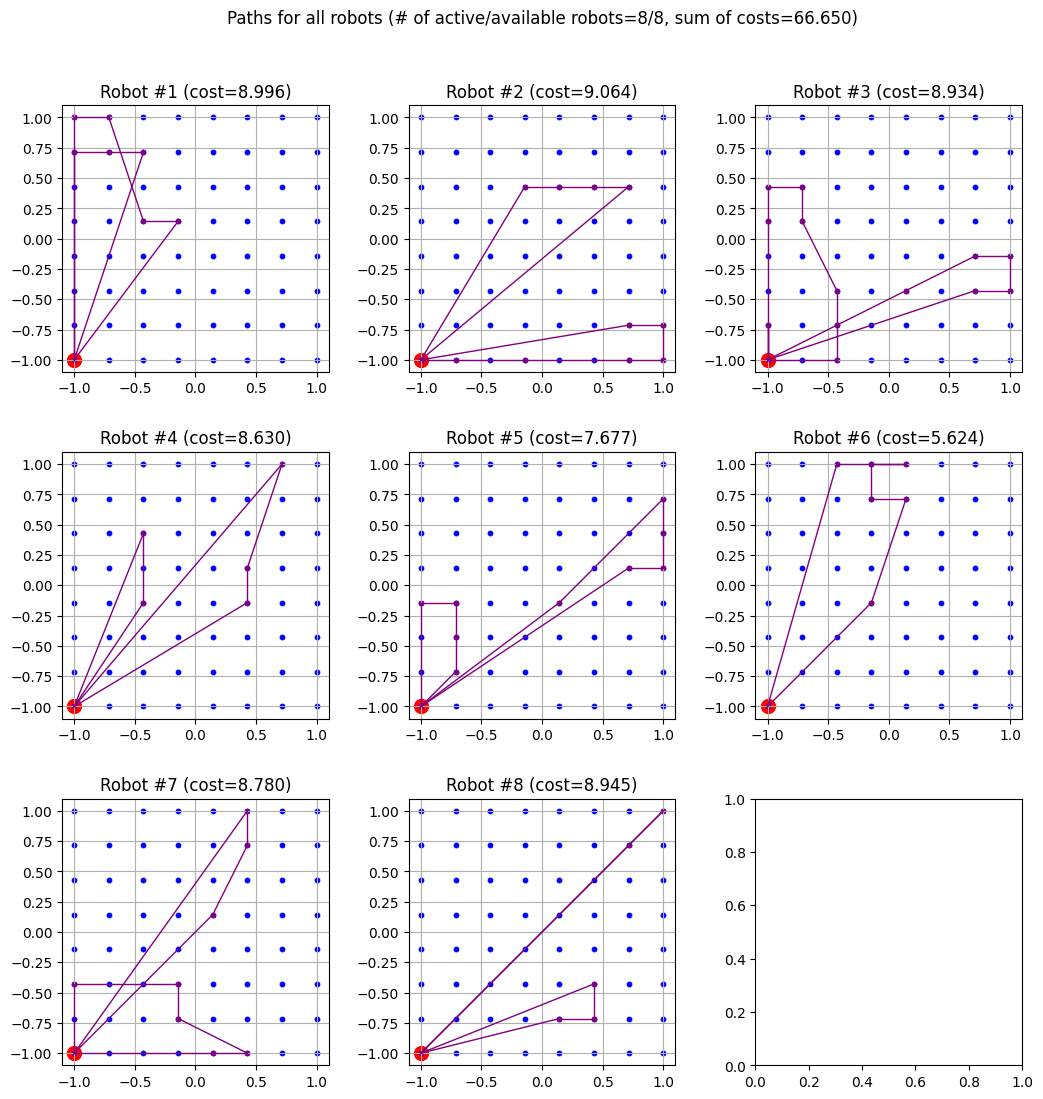

H 3488  3886                       9.0639893    2.28539  74.8%  5715 22529s
Found a new solution with lower cost(9.061)!


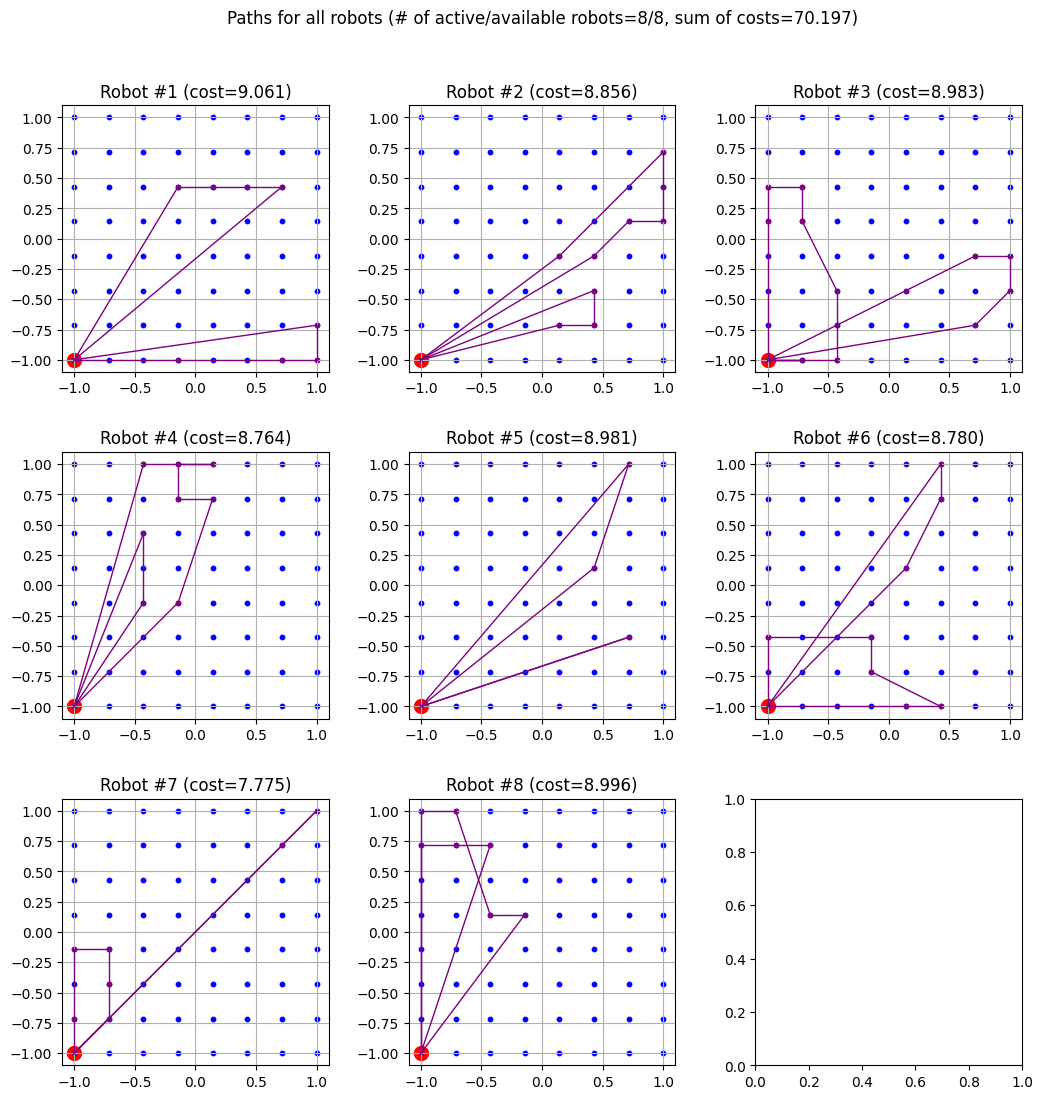

H 3909  3885                       9.0606484    2.28539  74.8%  5298 22531s
Found a new solution with lower cost(9.061)!


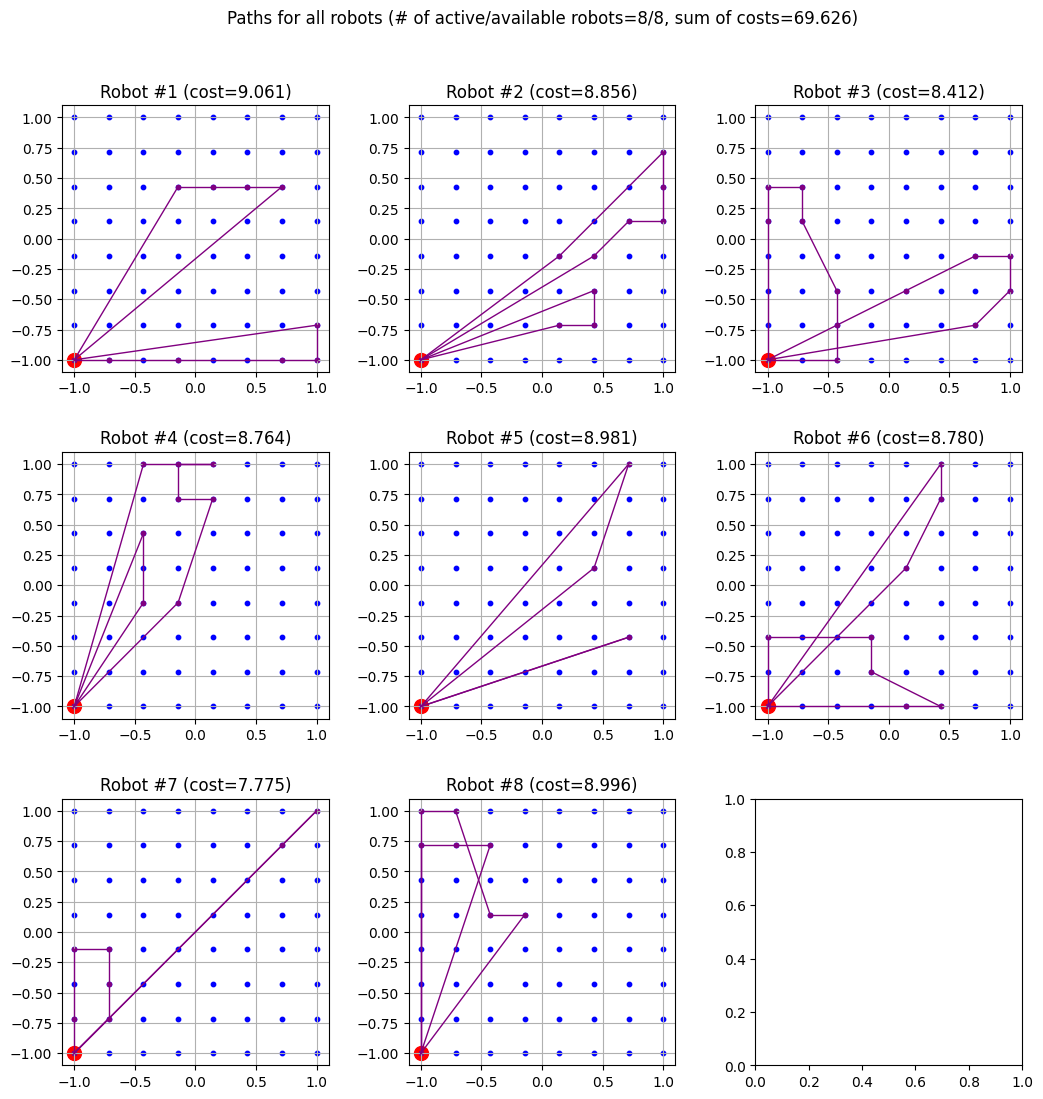

H 4322  3904                       9.0606484    2.28539  74.8%  5016 26248s
Found a new solution with lower cost(9.043)!


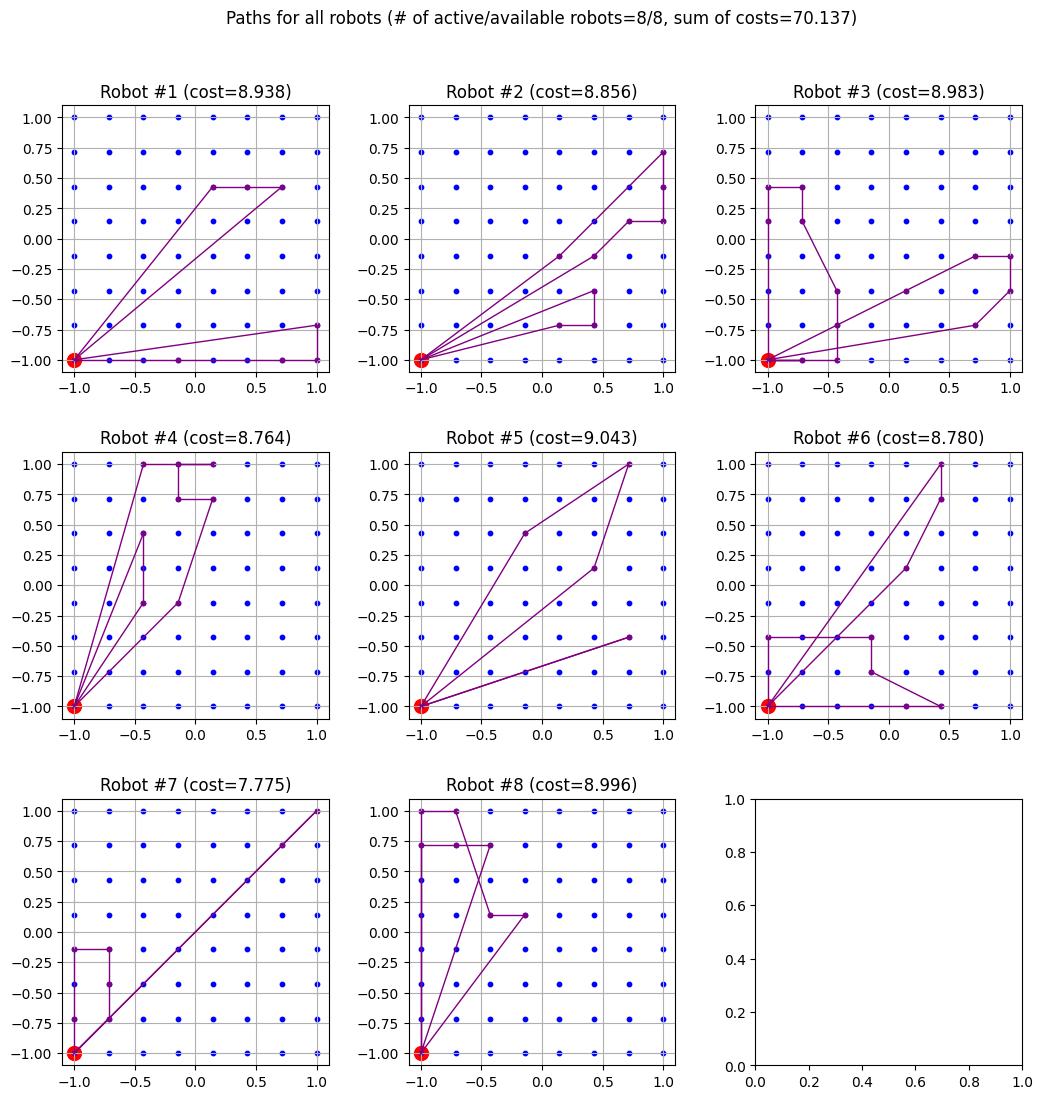

H 4323  3903                       9.0431473    2.28539  74.7%  5015 26250s
Found a new solution with lower cost(8.996)!


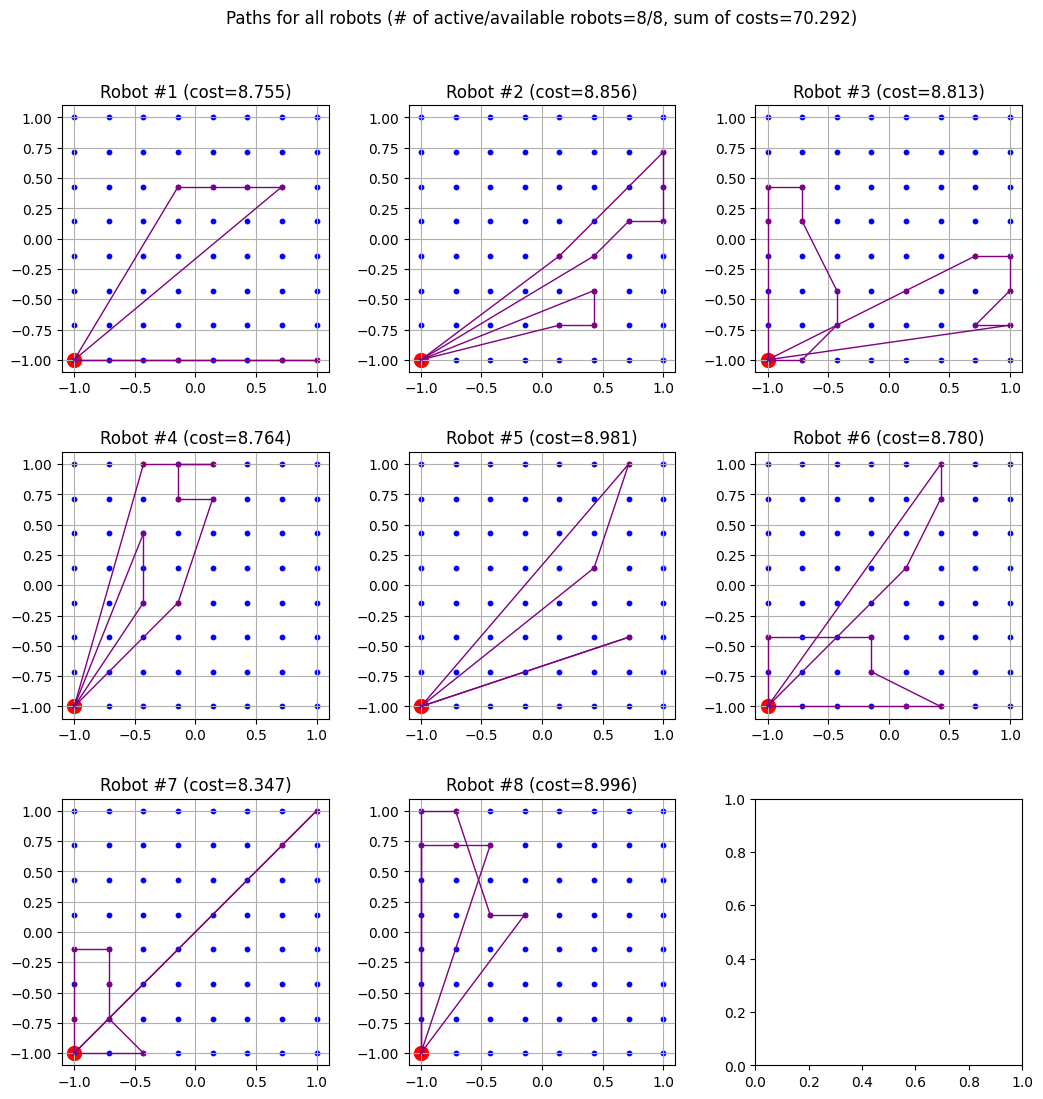

H 4329  3898                       8.9962380    2.28539  74.6%  5017 26252s
Found a new solution with lower cost(8.981)!


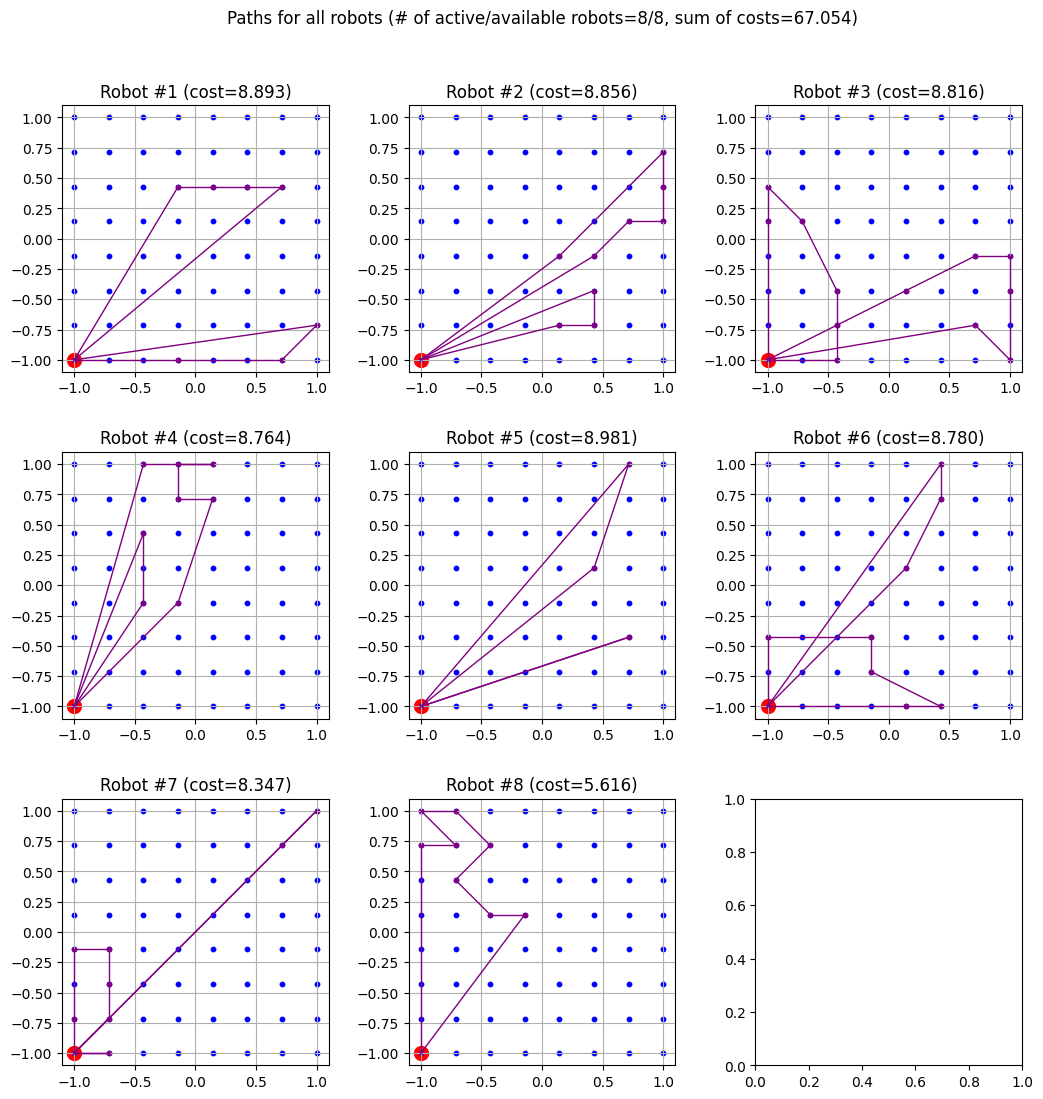

H 4331  3843                       8.9811591    2.28539  74.6%  5019 26254s
  4345  3844    2.99136  121  964    8.98116    2.28539  74.6%  5032 26395s
  4347  3845    2.50577  109 1443    8.98116    2.28539  74.6%  5029 26430s
  4348  3846    3.14300  119 1319    8.98116    2.28539  74.6%  5028 26520s
  4349  3847    2.40730   83 1266    8.98116    2.28539  74.6%  5027 26549s
Found a new solution with lower cost(8.893)!


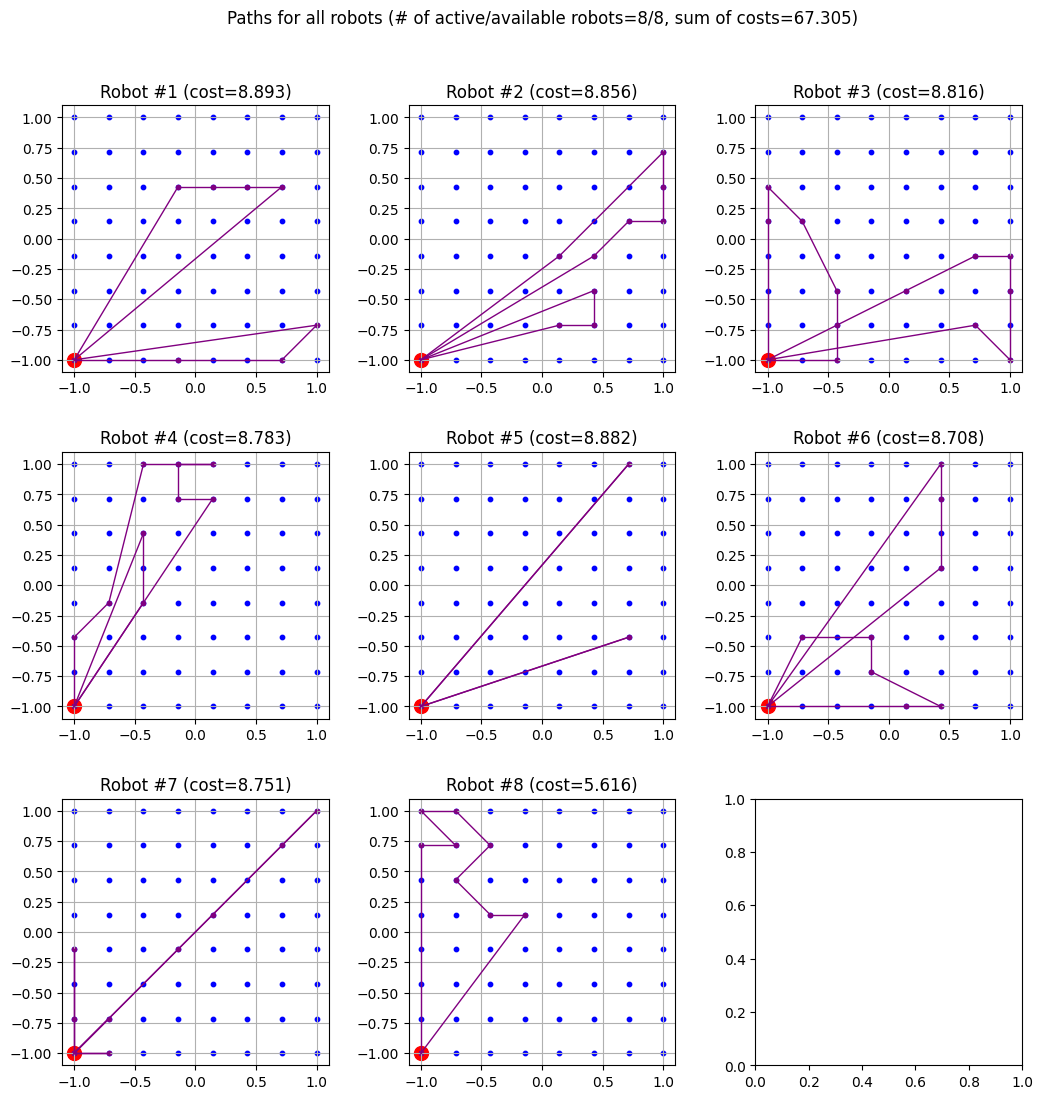

H 4349  3654                       8.8932808    2.28539  74.3%  5027 26630s
  4351  3655    2.88949  106 1184    8.89328    2.28539  74.3%  5025 26671s
  4352  3656    6.70820  140 1072    8.89328    2.28539  74.3%  5024 26735s
  4353  3656    2.30046   66 1041    8.89328    2.28539  74.3%  5022 26793s
  4354  3657    2.33629   42 1104    8.89328    2.28539  74.3%  5021 26852s
  4355  3658    2.43651   58 1041    8.89328    2.28539  74.3%  5020 26888s
  4356  3658    4.49371  151 1006    8.89328    2.28539  74.3%  5019 26939s
  4357  3659    4.17496   98  963    8.89328    2.28539  74.3%  5018 26964s
  4358  3660    2.44495   99  961    8.89328    2.28539  74.3%  5017 27041s
  4359  3660    2.28539   24  949    8.89328    2.28539  74.3%  5016 27068s
  4360  3661    2.45233  133  957    8.89328    2.28539  74.3%  5014 27321s
Found a new solution with lower cost(8.882)!


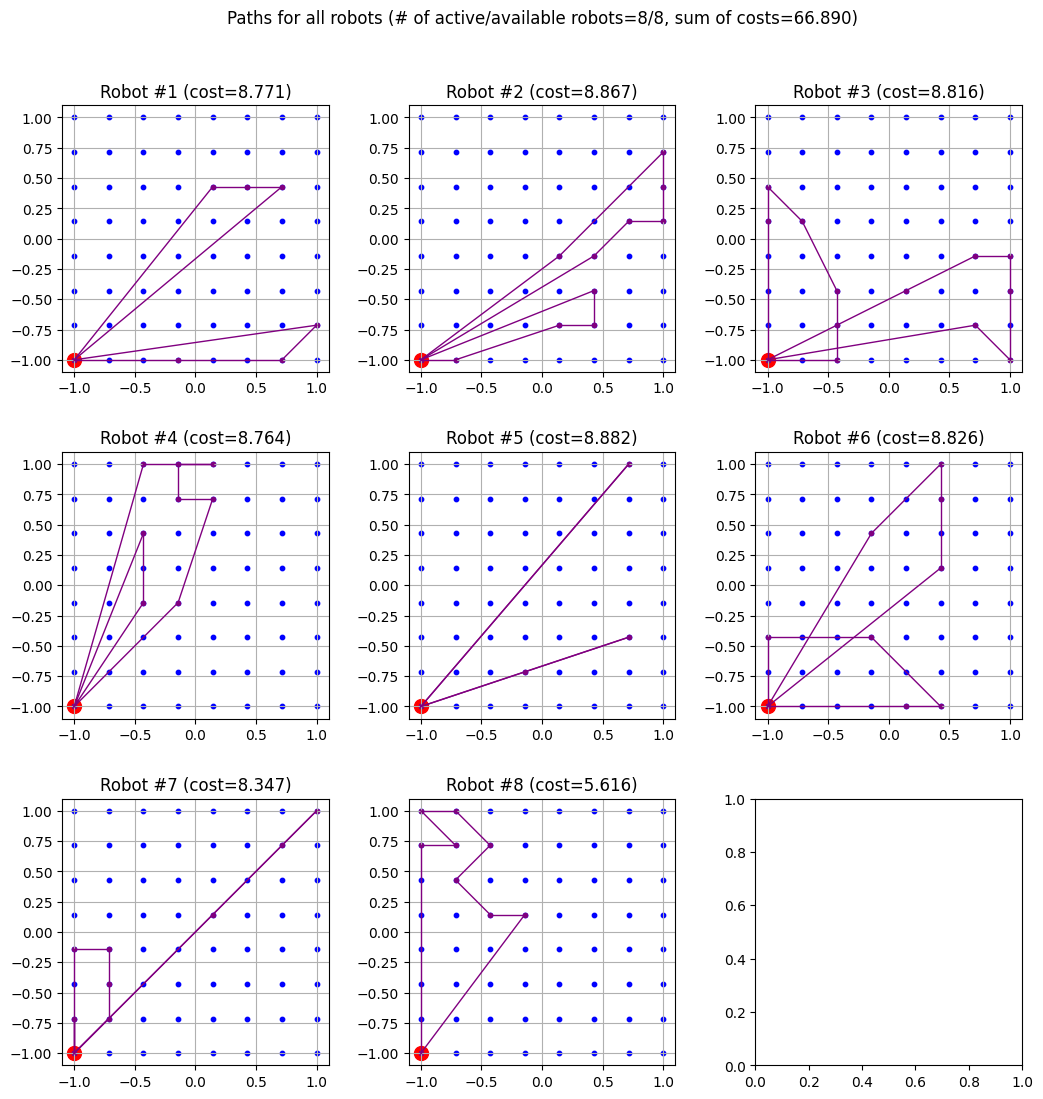

H 4360  3478                       8.8823427    2.28539  74.3%  5014 27349s
Found a new solution with lower cost(8.841)!


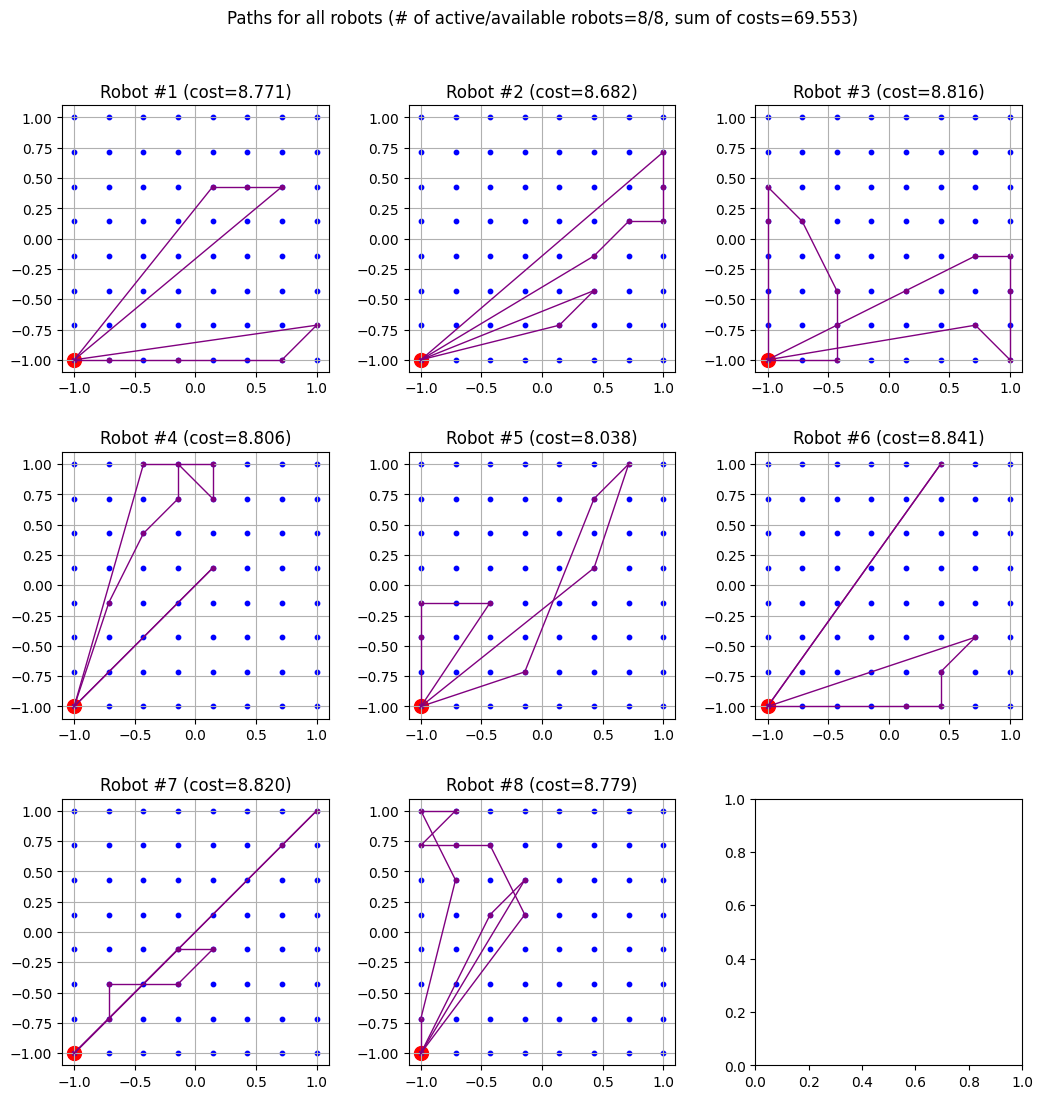

H 4360  3304                       8.8409770    2.28539  74.2%  5014 27351s
  4361  3305    2.60871  186  956    8.84098    2.28539  74.2%  5013 27362s
Found a new solution with lower cost(8.841)!


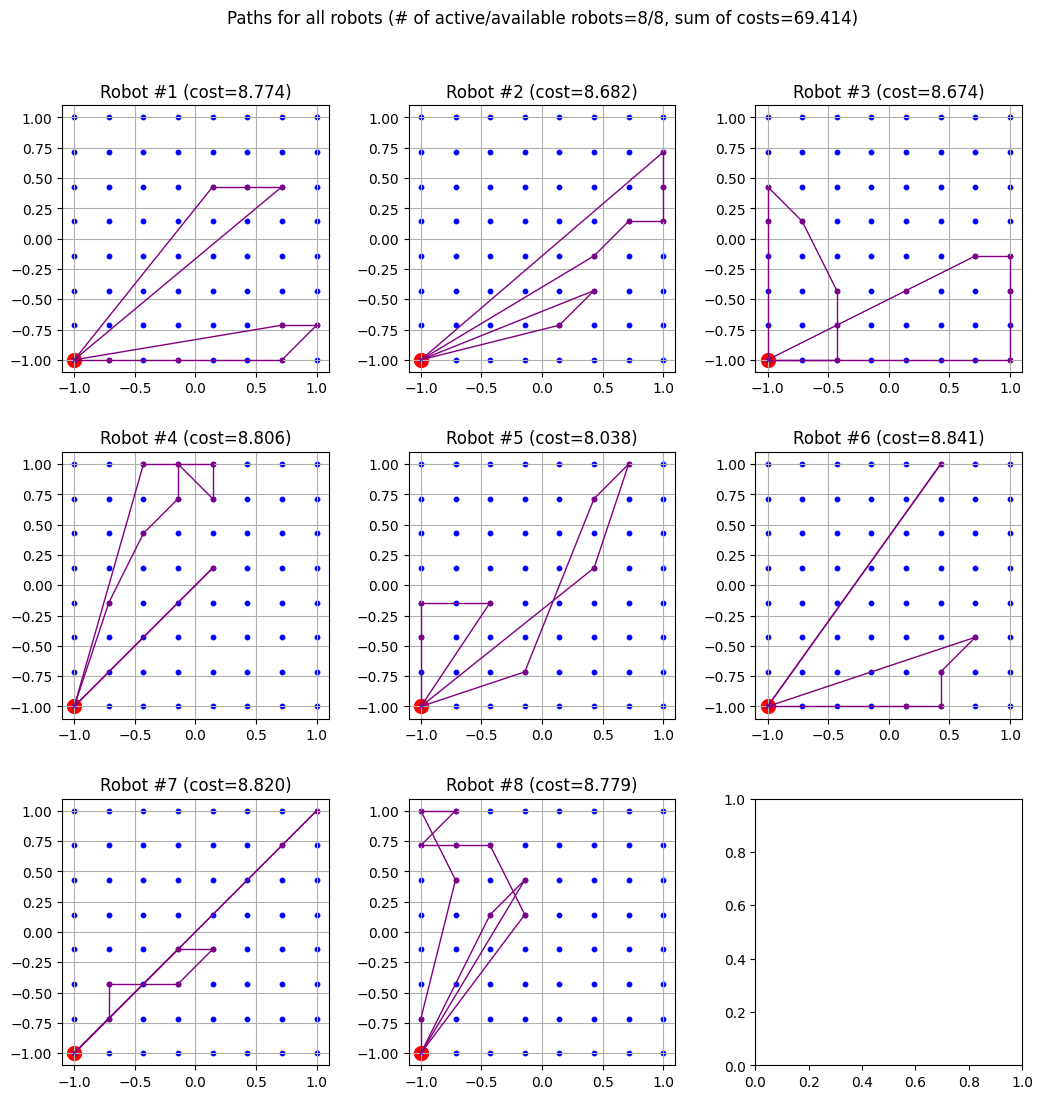

H 4361  3139                       8.8409770    2.28539  74.2%  5013 27409s
  4363  3140    2.57970  125  972    8.84098    2.28539  74.2%  5011 27438s
  4364  3141    2.28539   19  987    8.84098    2.28539  74.2%  5010 27474s
  4365  3141    2.28539    7  986    8.84098    2.28539  74.2%  5009 27501s
  4366  3142    2.28949   15  970    8.84098    2.28539  74.2%  5007 27539s
  4367  3143    6.10410   82  970    8.84098    2.28539  74.2%  5006 27554s
  4368  3143    2.28777   29  970    8.84098    2.28539  74.2%  5005 27877s
  4369  3147    2.28539   15  873    8.84098    2.28539  74.2%  5078 28006s
  4371  3150    2.28539   16  877    8.84098    2.28539  74.2%  5089 28117s
  4375  3157    2.28539   17  781    8.84098    2.28539  74.2%  5103 28518s
  4383  3169    2.28539   18  826    8.84098    2.28539  74.2%  5180 28915s
  4398  3179    2.28539   19  836    8.84098    2.28539  74.2%  5245 31339s
Found a new solution with lower cost(8.820)!


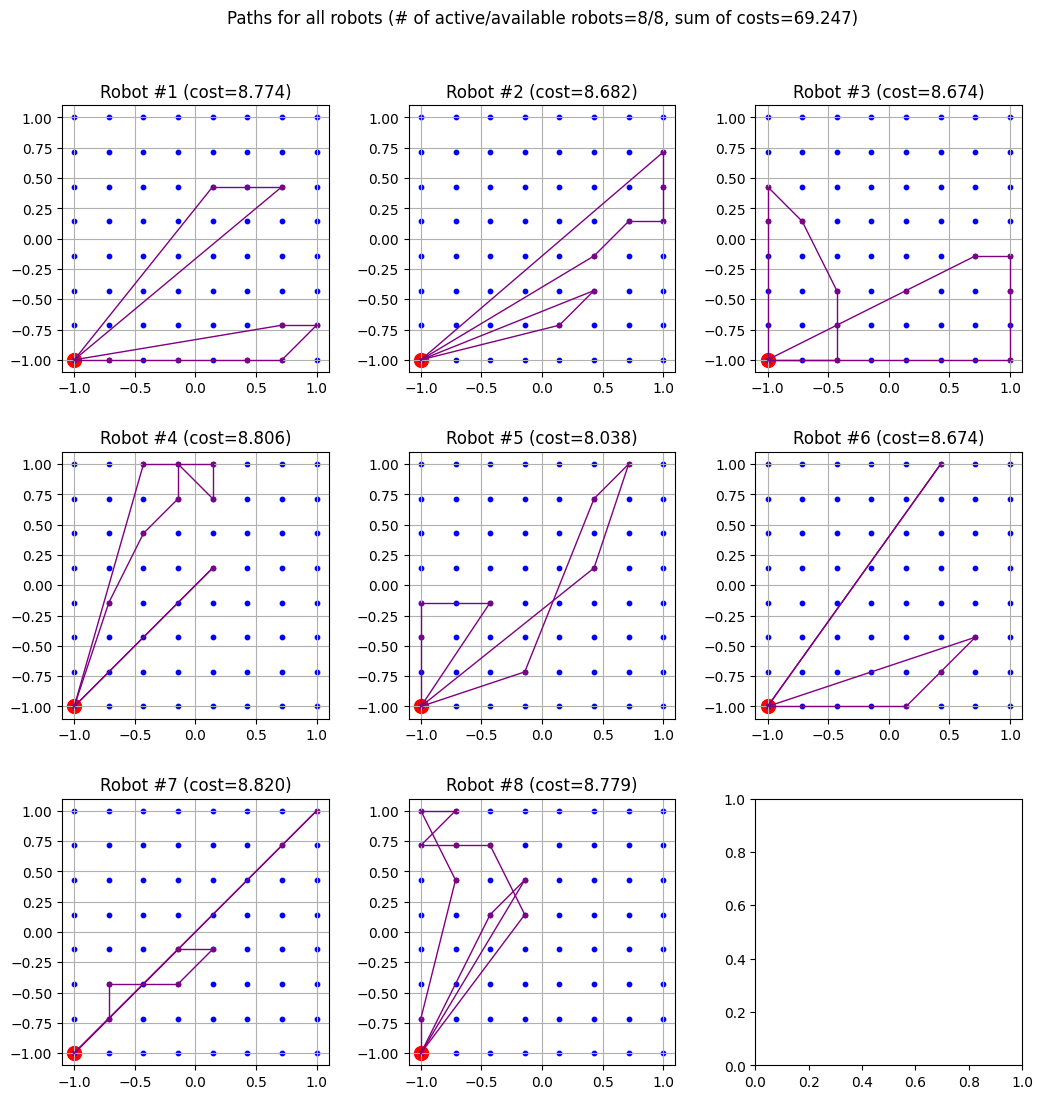

H 4399  3022                       8.8200165    2.28539  74.1%  5243 31341s
Found a new solution with lower cost(8.774)!


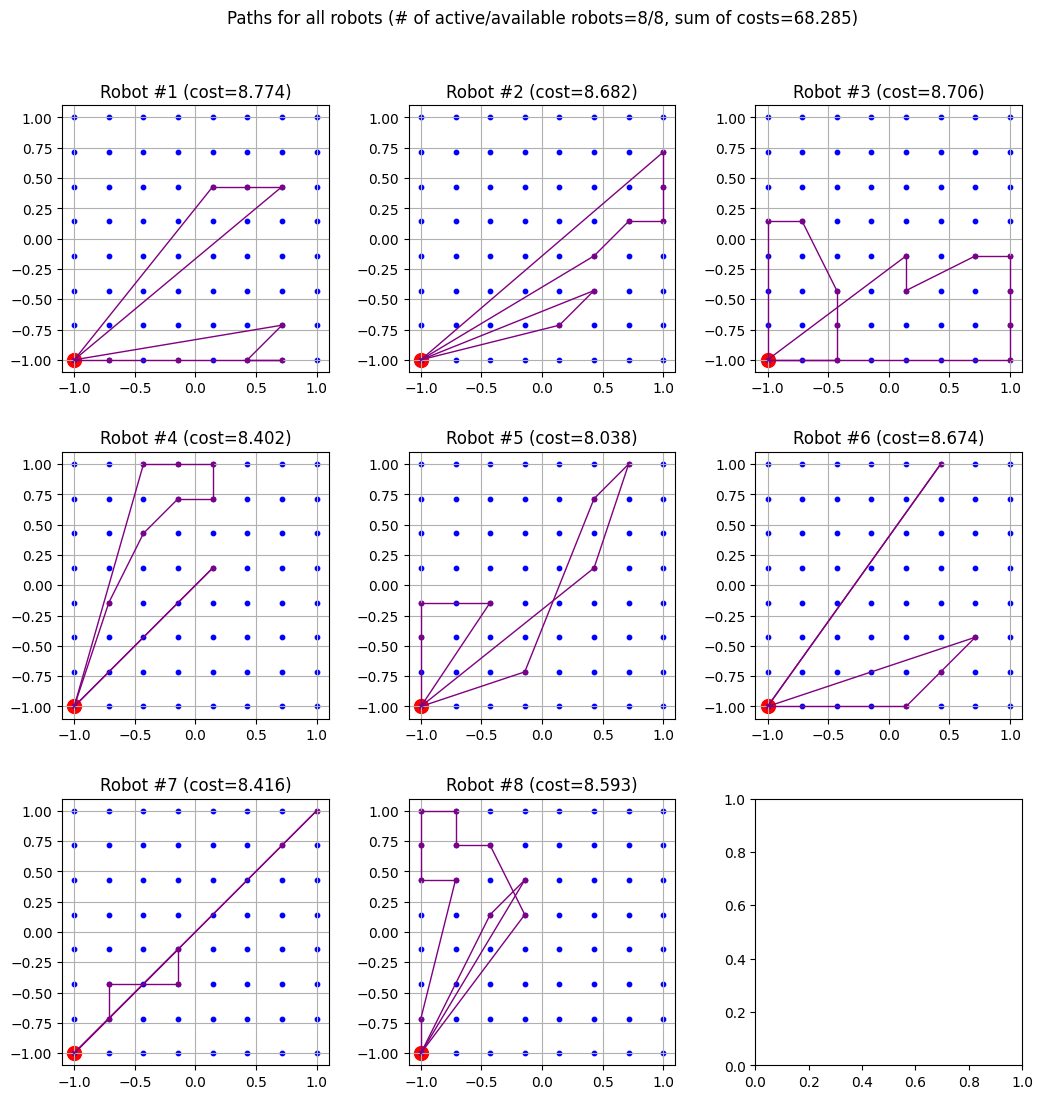

H 4405  2870                       8.7743857    2.28539  74.0%  5405 31343s
  4413  2882    2.28539   19  853    8.77439    2.28539  74.0%  5574 31728s
  4428  2892    2.28539   20  824    8.77439    2.28539  74.0%  5626 32947s
  4443  2904    2.28539   20  781    8.77439    2.28539  74.0%  5714 33662s
Found a new solution with lower cost(8.706)!


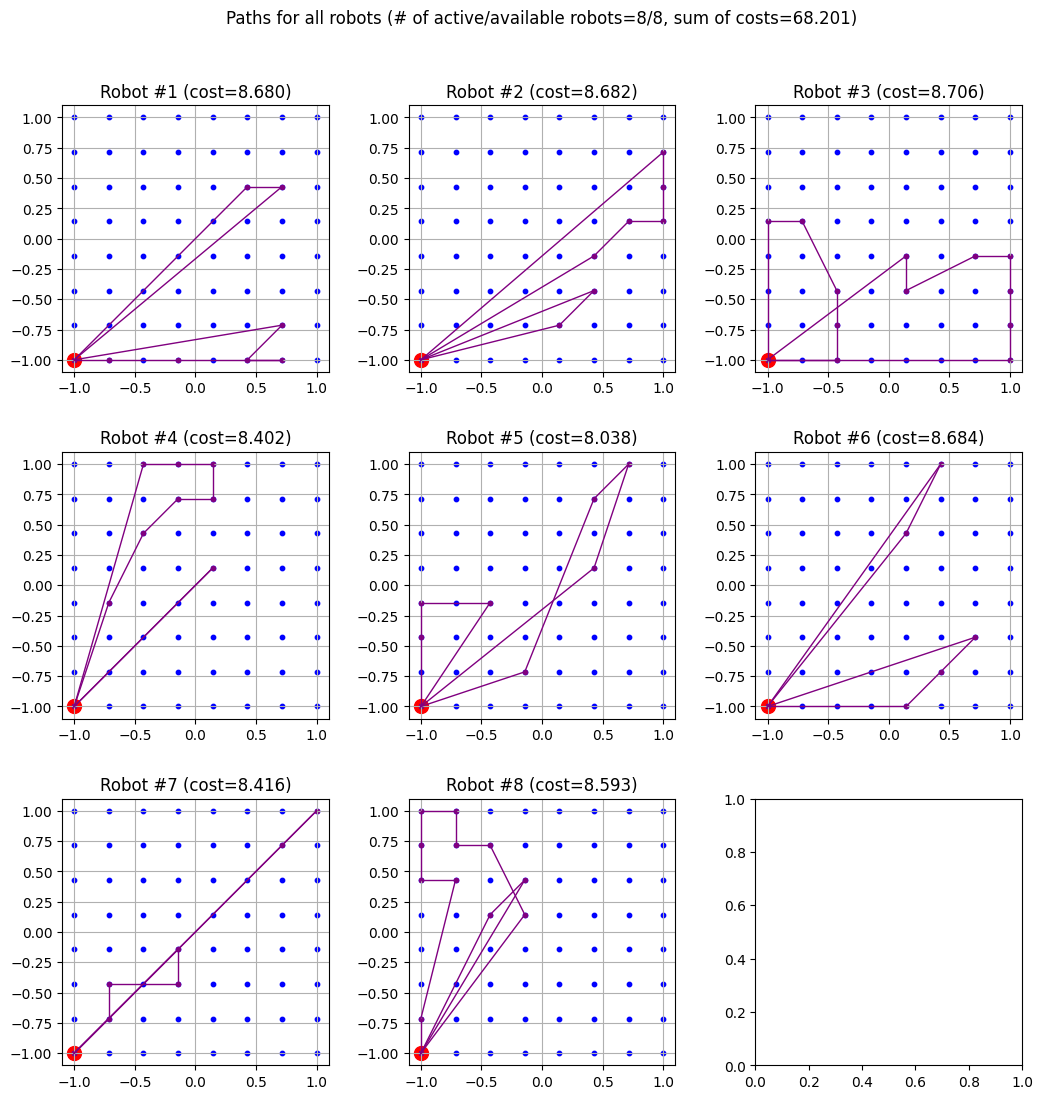

H 4451  2760                       8.7063246    2.28539  73.8%  5739 33664s
Found a new solution with lower cost(8.682)!


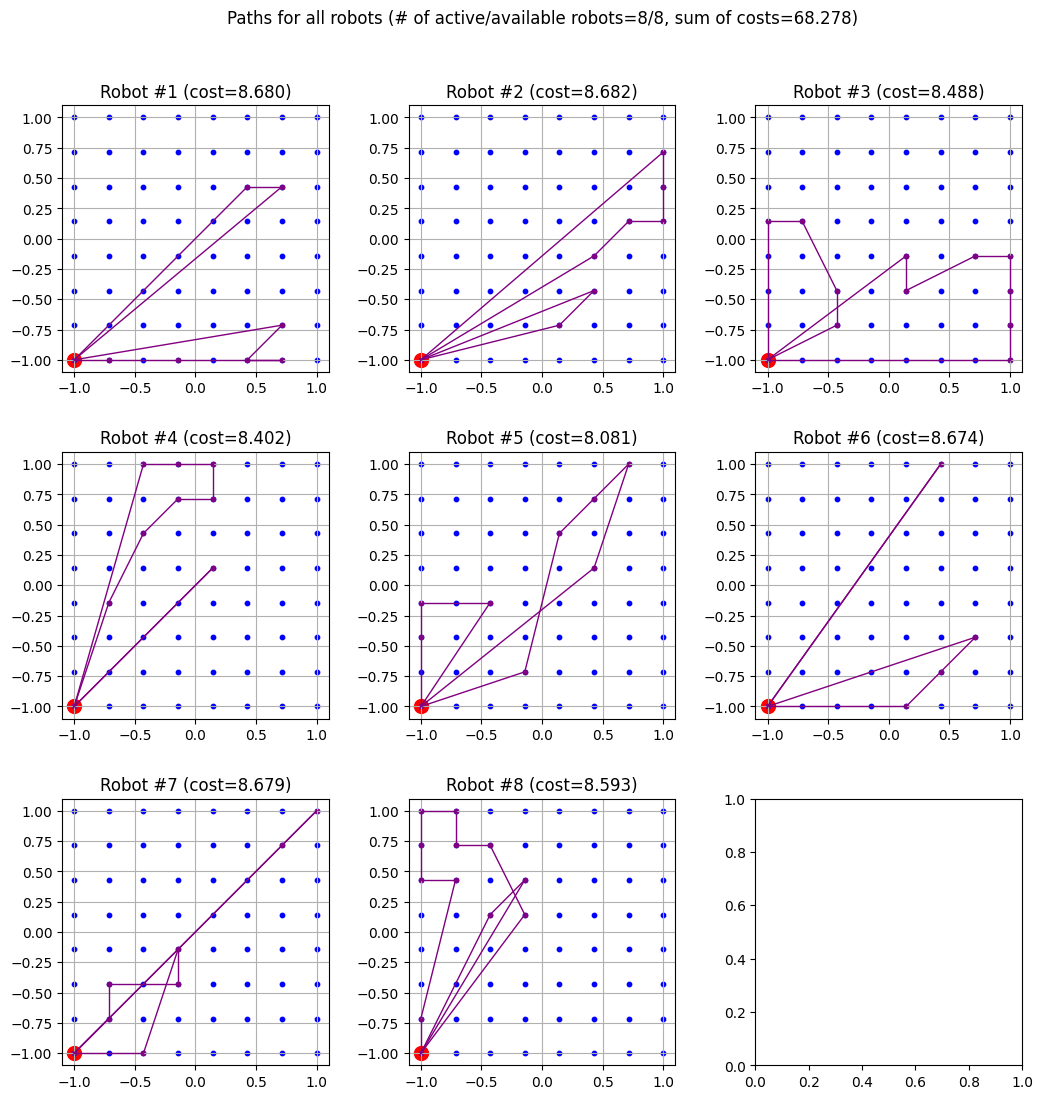

H 4454  2623                       8.6820554    2.28539  73.7%  5760 33666s
  4460  2641    2.28539   21  822    8.68206    2.28539  73.7%  5811 34103s
  4480  2654    2.28539   21  811    8.68206    2.28539  73.7%  5856 34635s
Found a new solution with lower cost(8.488)!


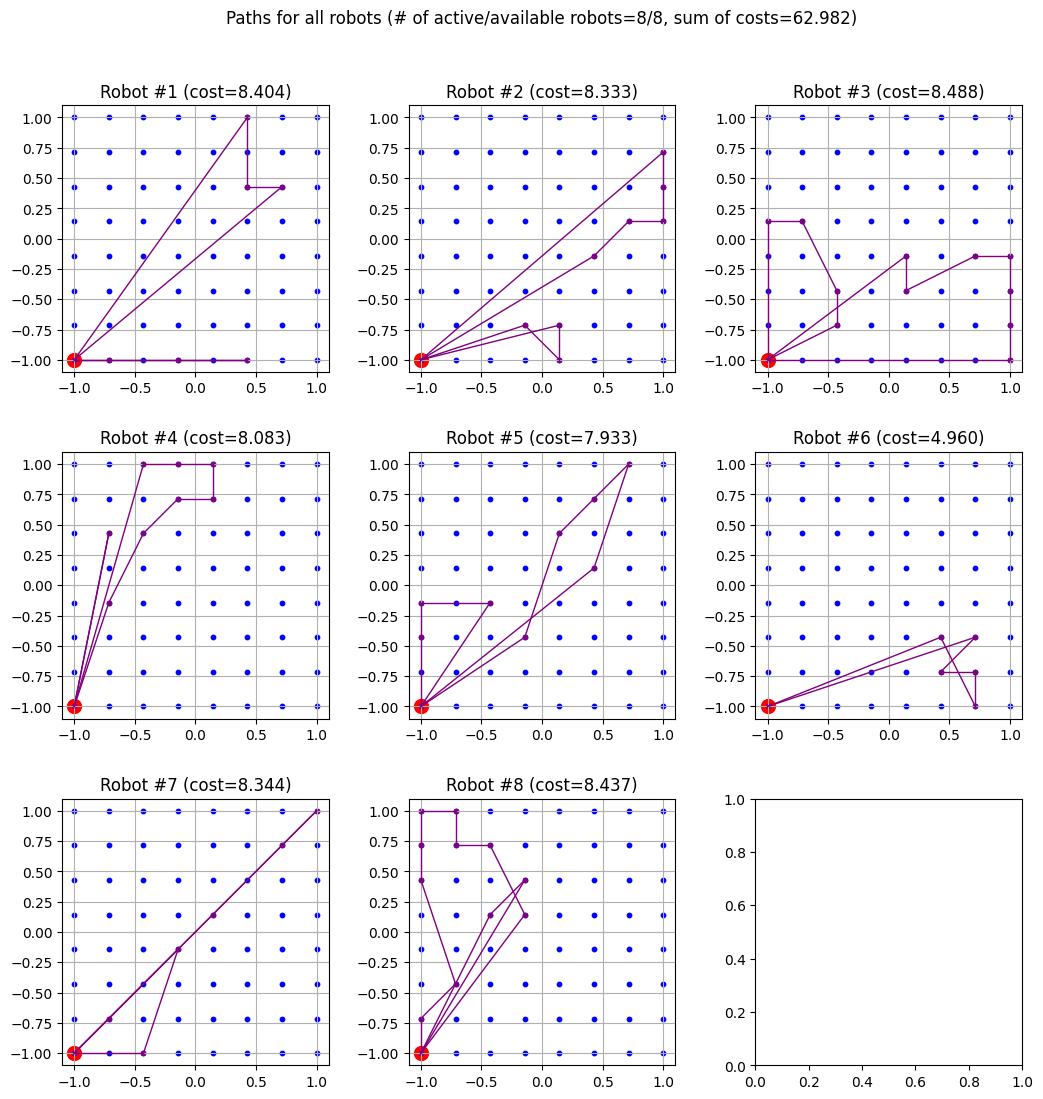

H 4500  2572                       8.4880583    2.28539  73.1%  5923 35875s
  4553  2690    2.28539   23  776    8.48806    2.28539  73.1%  6069 38654s
  4688  3056    2.28539   26  817    8.48806    2.28539  73.1%  6382 43173s
Found a new solution with lower cost(8.404)!


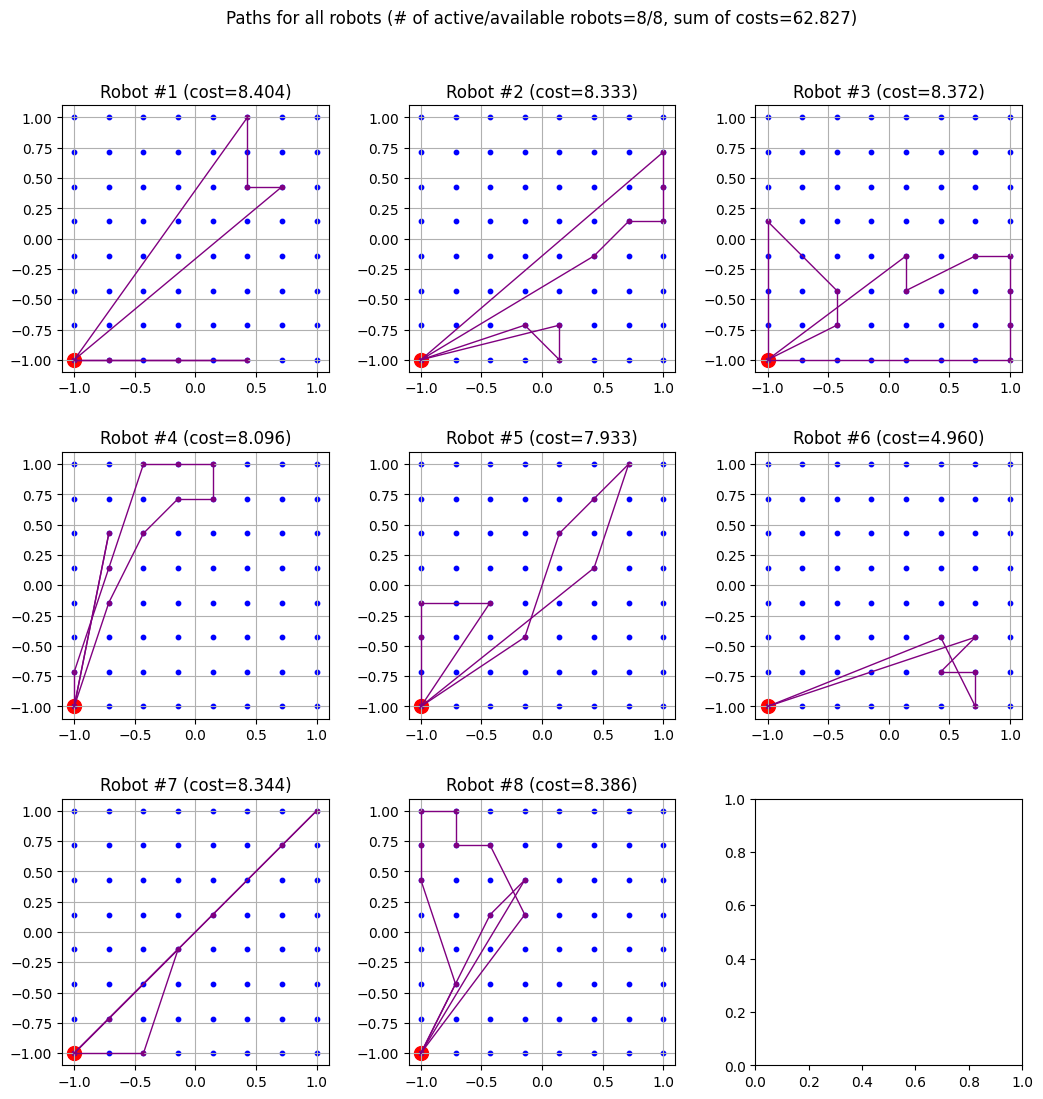

H 4701  2929                       8.4035928    2.28539  72.8%  6416 43176s
Found a new solution with lower cost(8.344)!


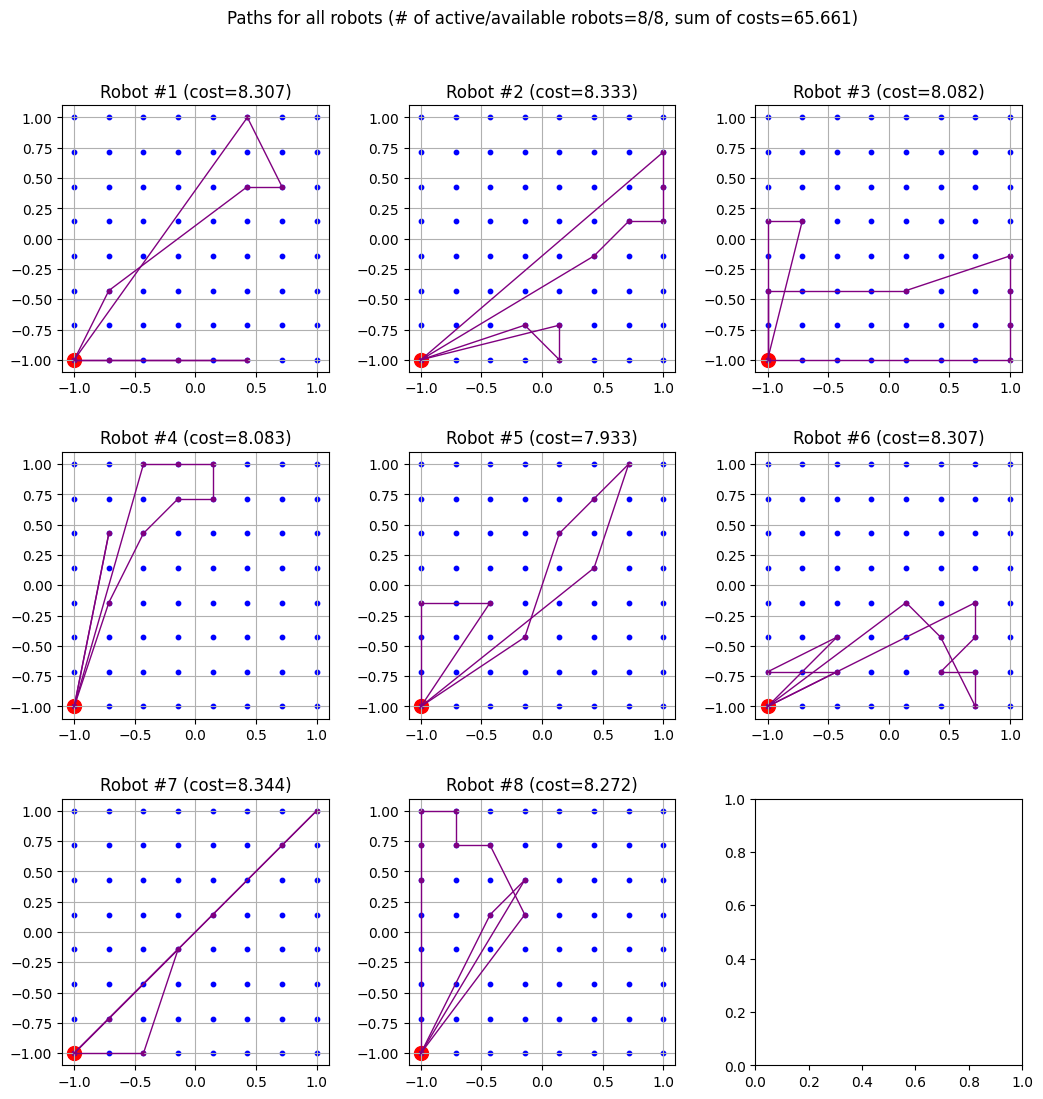

H 4718  2808                       8.3439738    2.28539  72.6%  6454 43178s
Found a new solution with lower cost(7.992)!


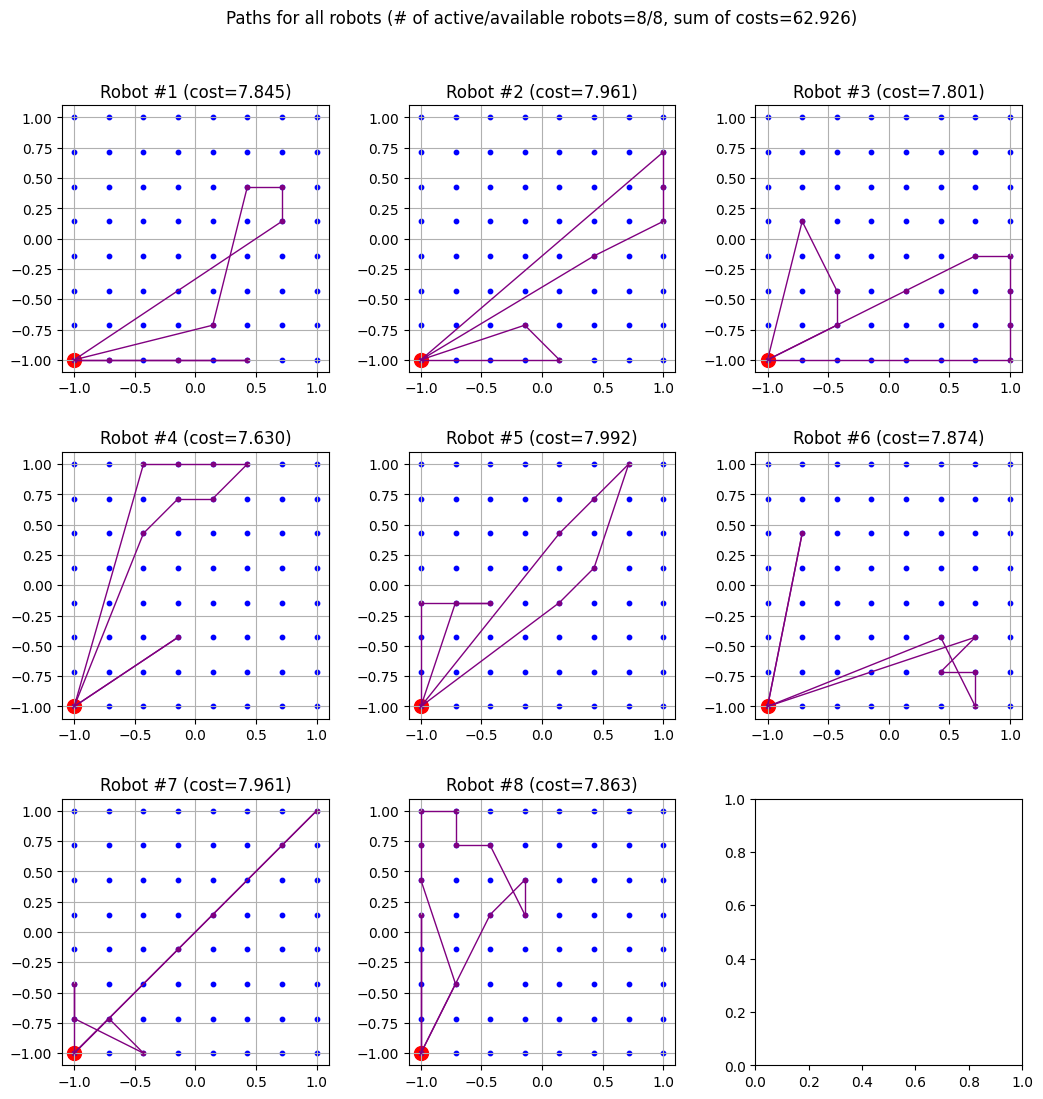

H 4780  2677                       7.9915201    2.28539  71.4%  6548 43180s
Found a new solution with lower cost(7.961)!


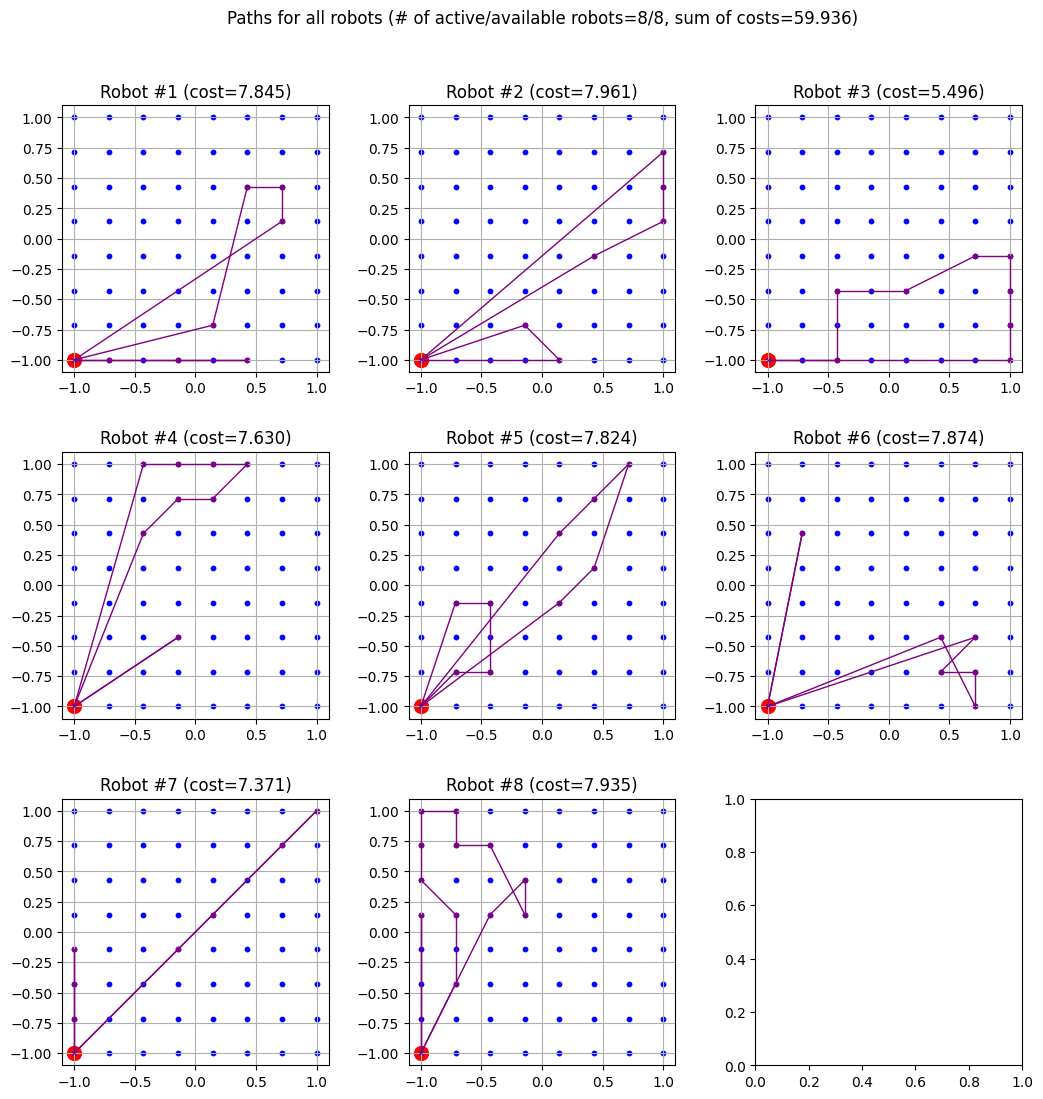

H 5140  2769                       7.9608730    2.28539  71.3%  6632 47117s
Found a new solution with lower cost(7.852)!


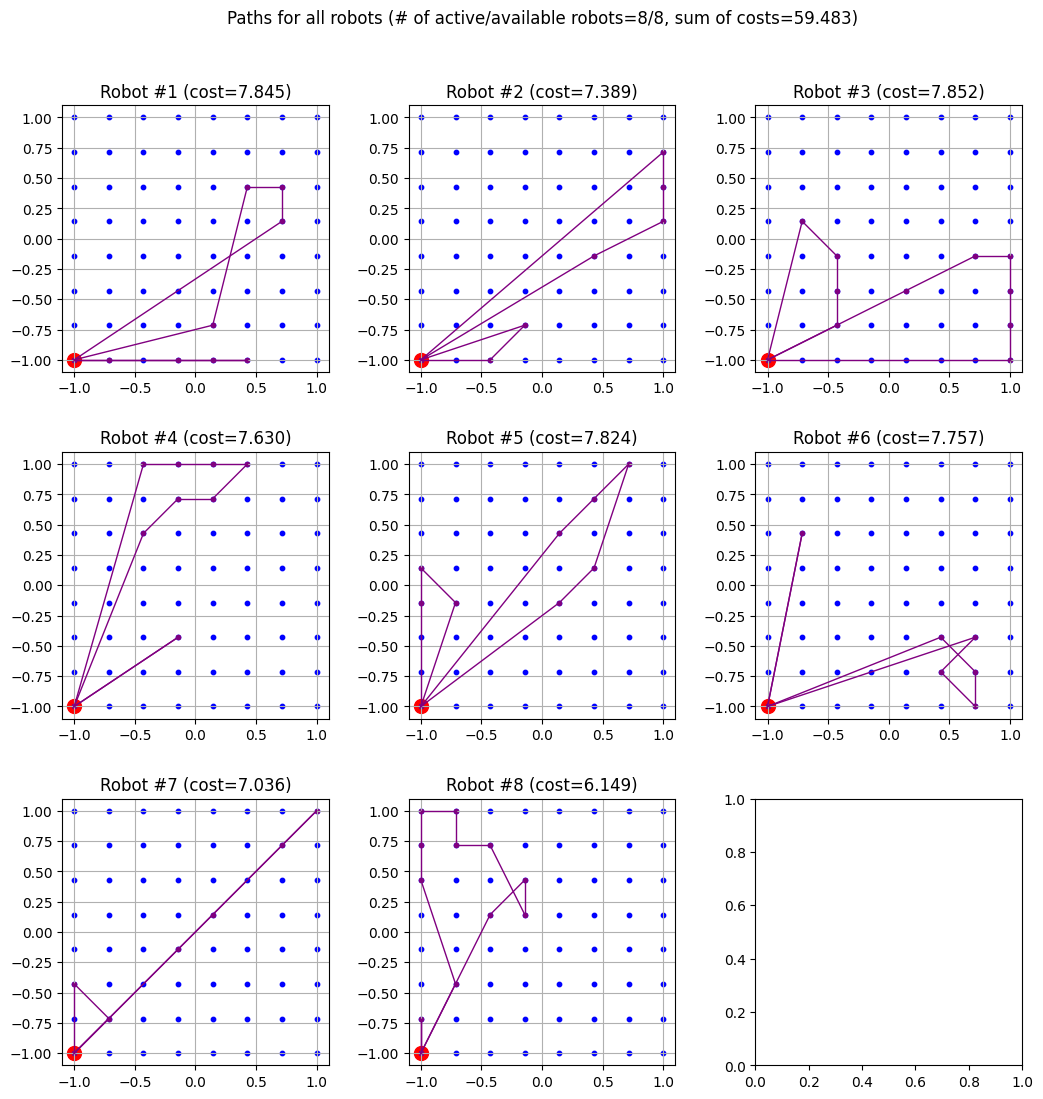

H 5152  2665                       7.8518832    2.28539  70.9%  6661 47119s
Found a new solution with lower cost(7.801)!


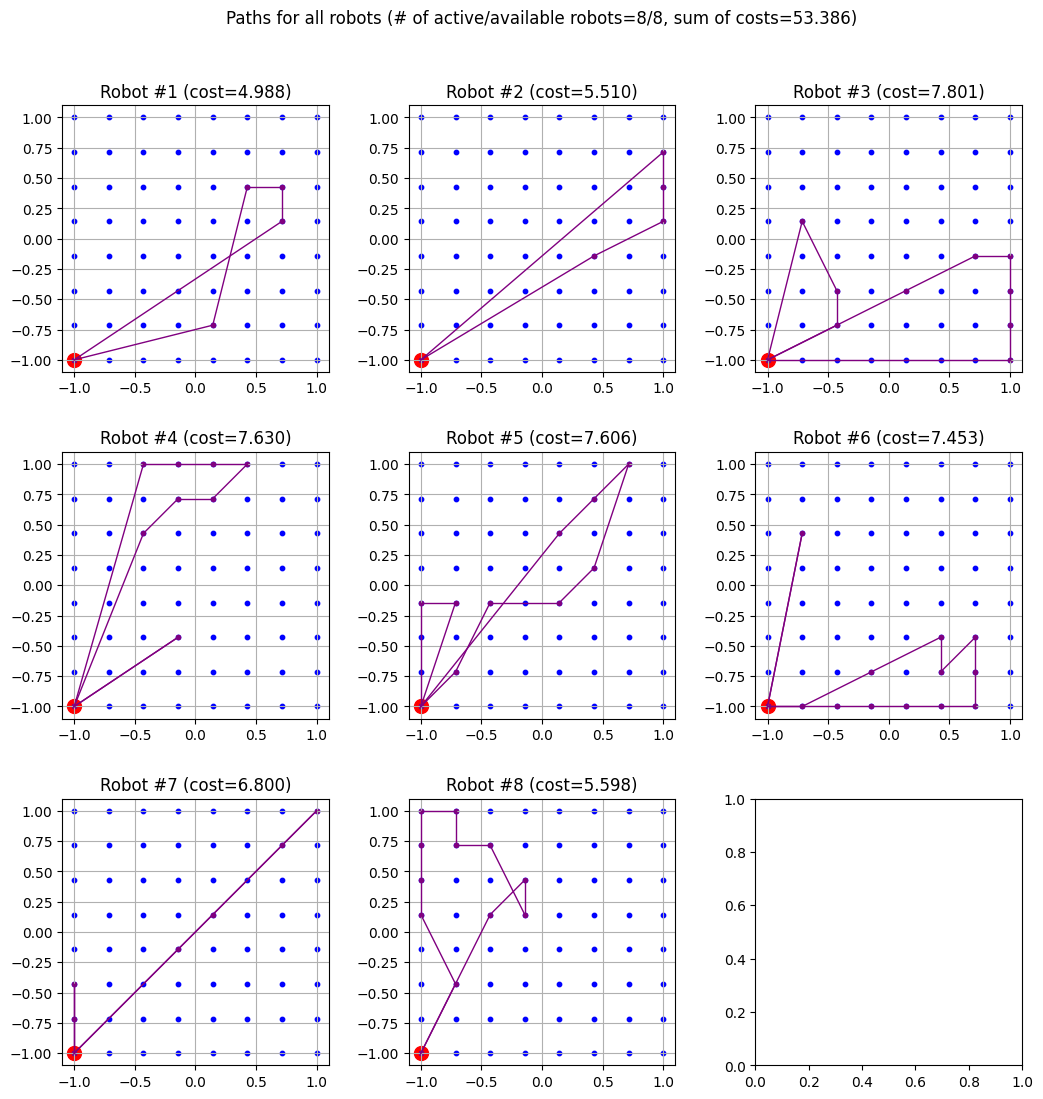

H 5156  2570                       7.8009844    2.28539  70.7%  6672 47121s
Found a new solution with lower cost(7.499)!


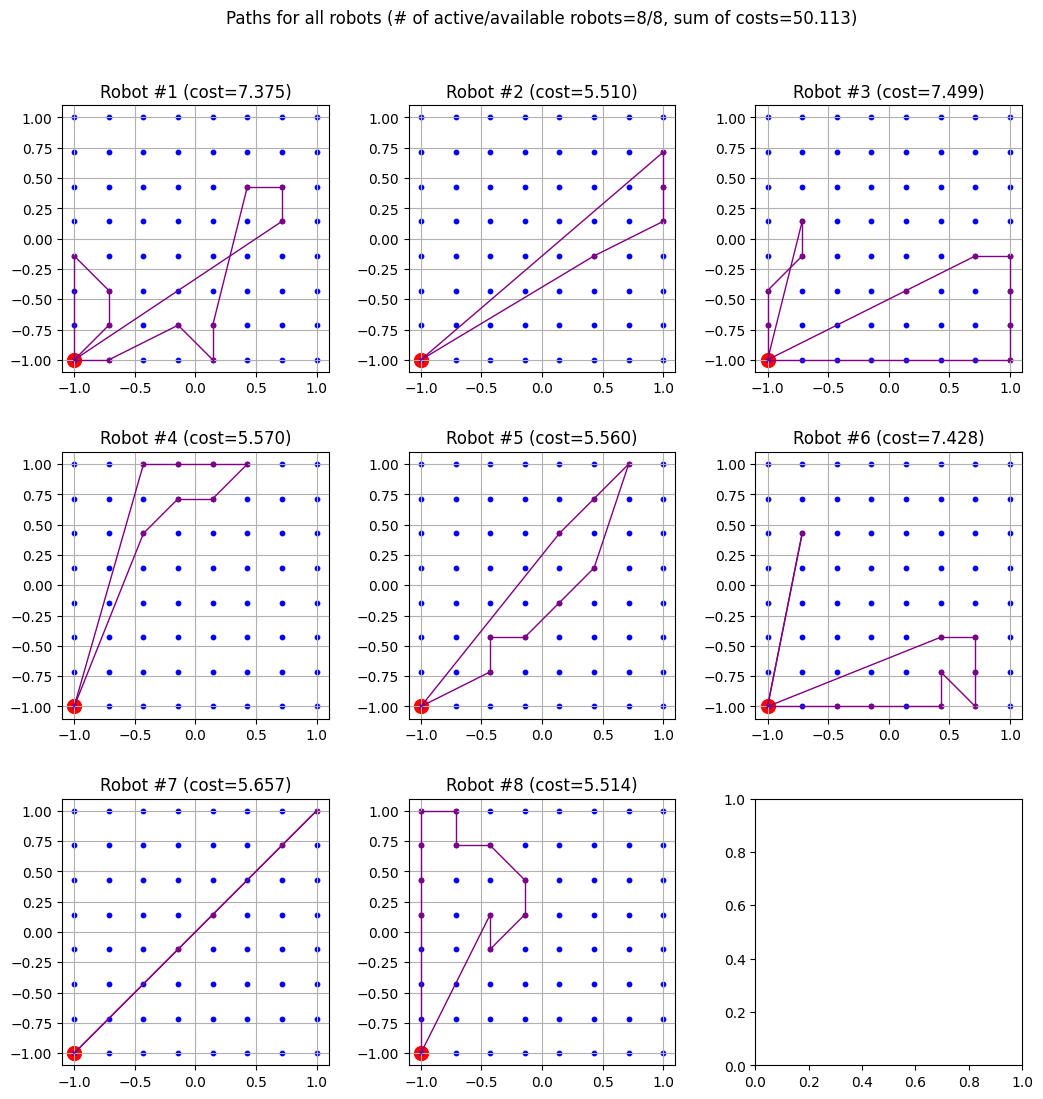

H 5318  2426                       7.4987209    2.28539  69.5%  6656 47123s
Found a new solution with lower cost(7.499)!


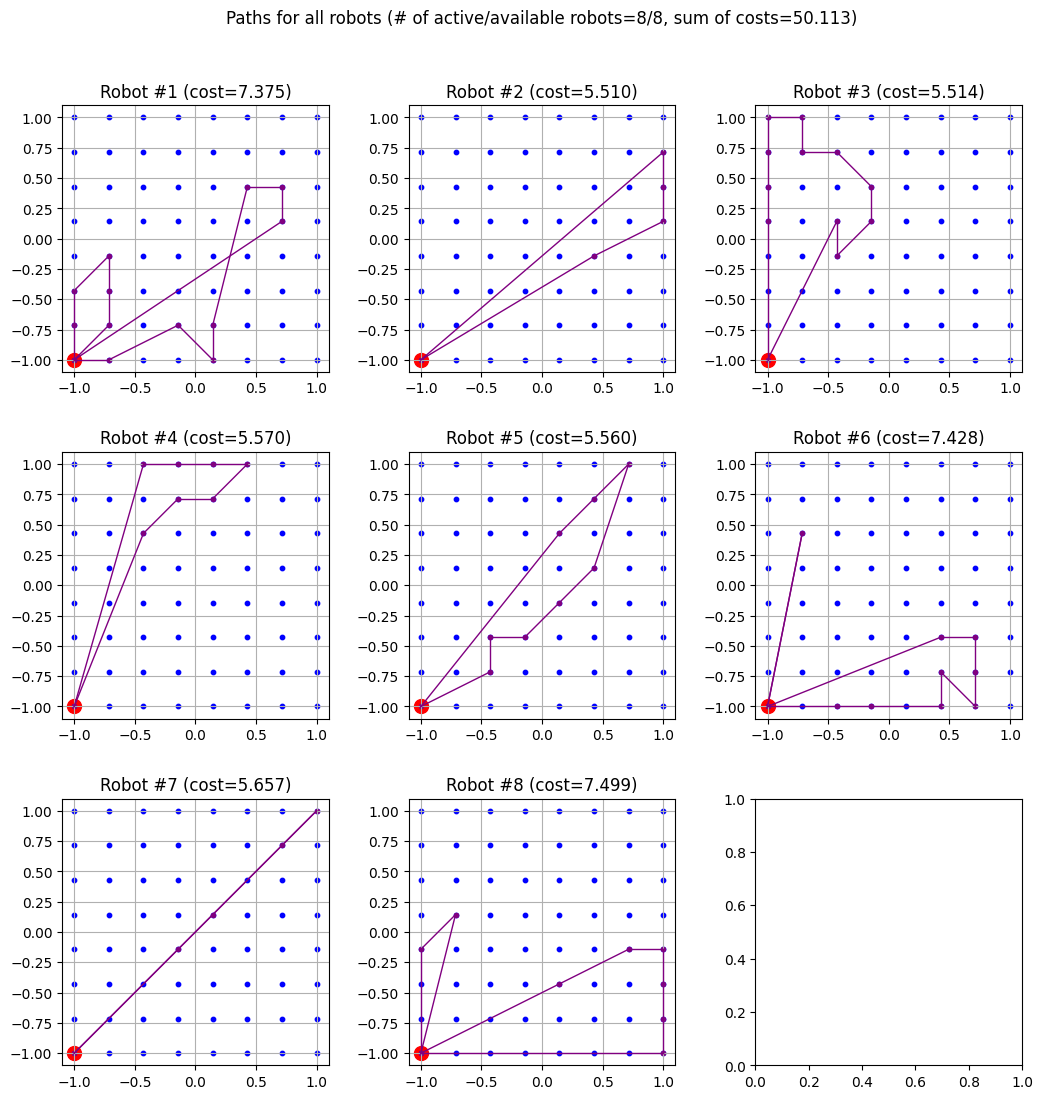

H 5507  2673                       7.4987208    2.28539  69.5%  6524 52156s
Found a new solution with lower cost(7.499)!


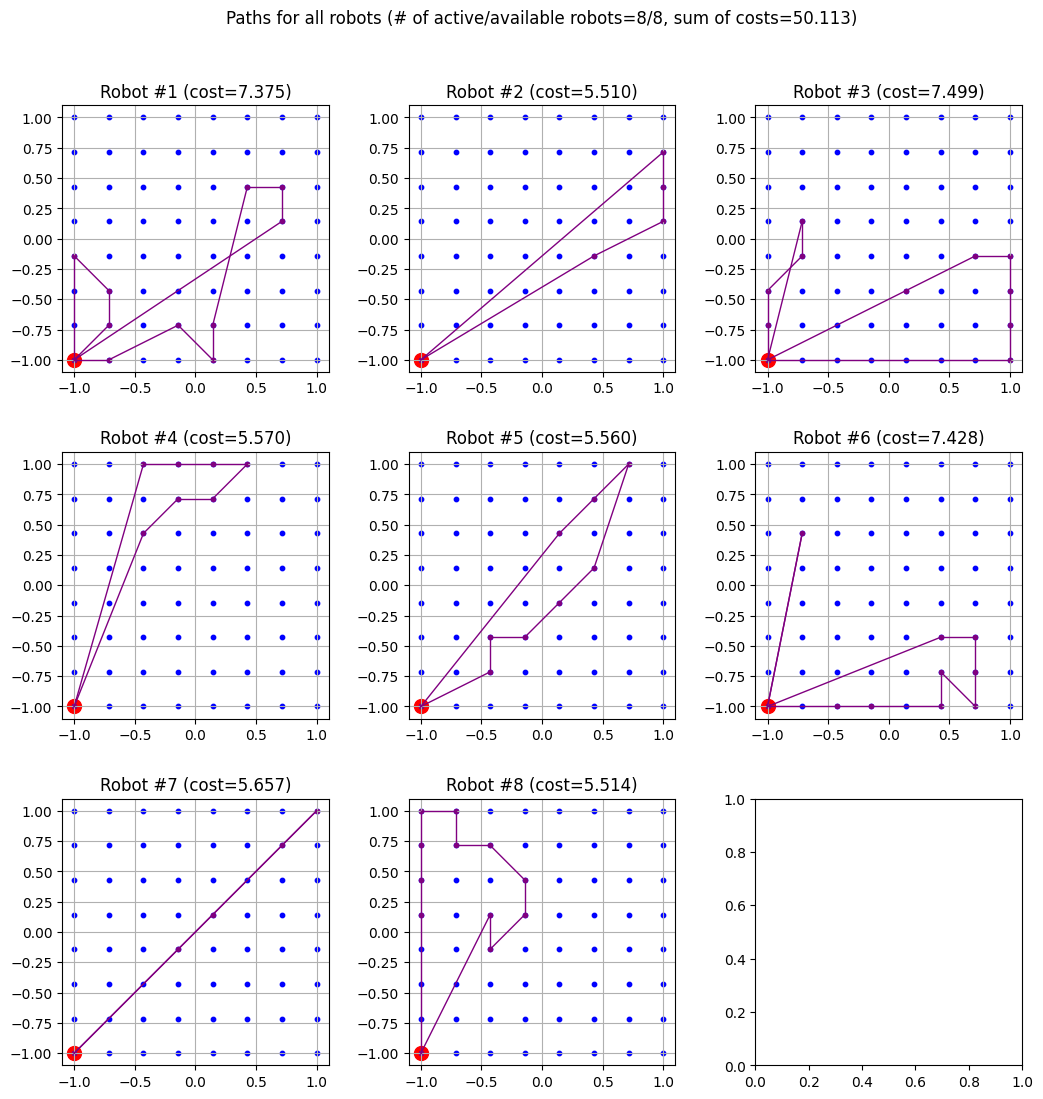

H 5533  2583                       7.4987202    2.28539  69.5%  6602 52158s
Found a new solution with lower cost(7.428)!


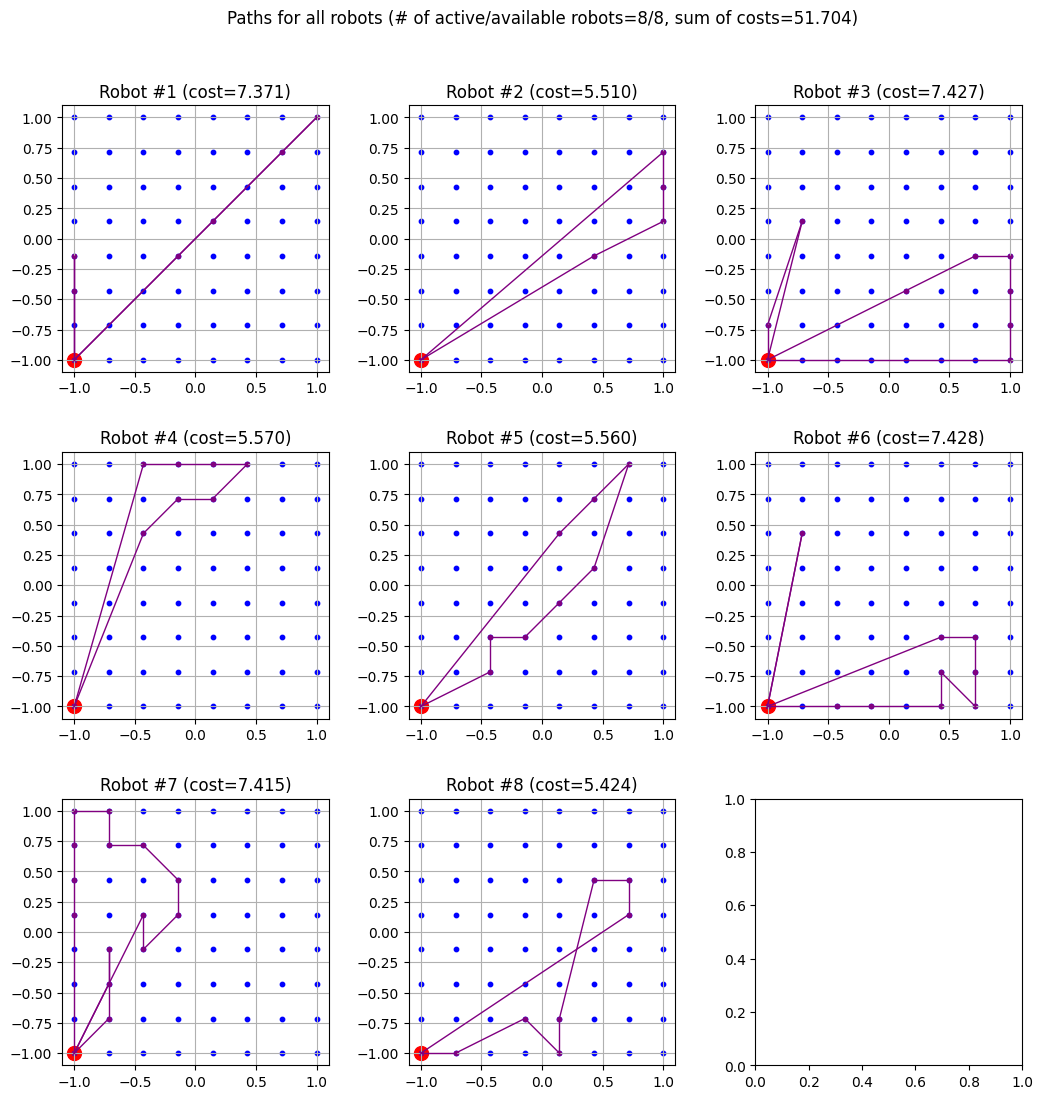

H 5555  2500                       7.4278328    2.28539  69.2%  6630 52160s
Found a new solution with lower cost(7.371)!


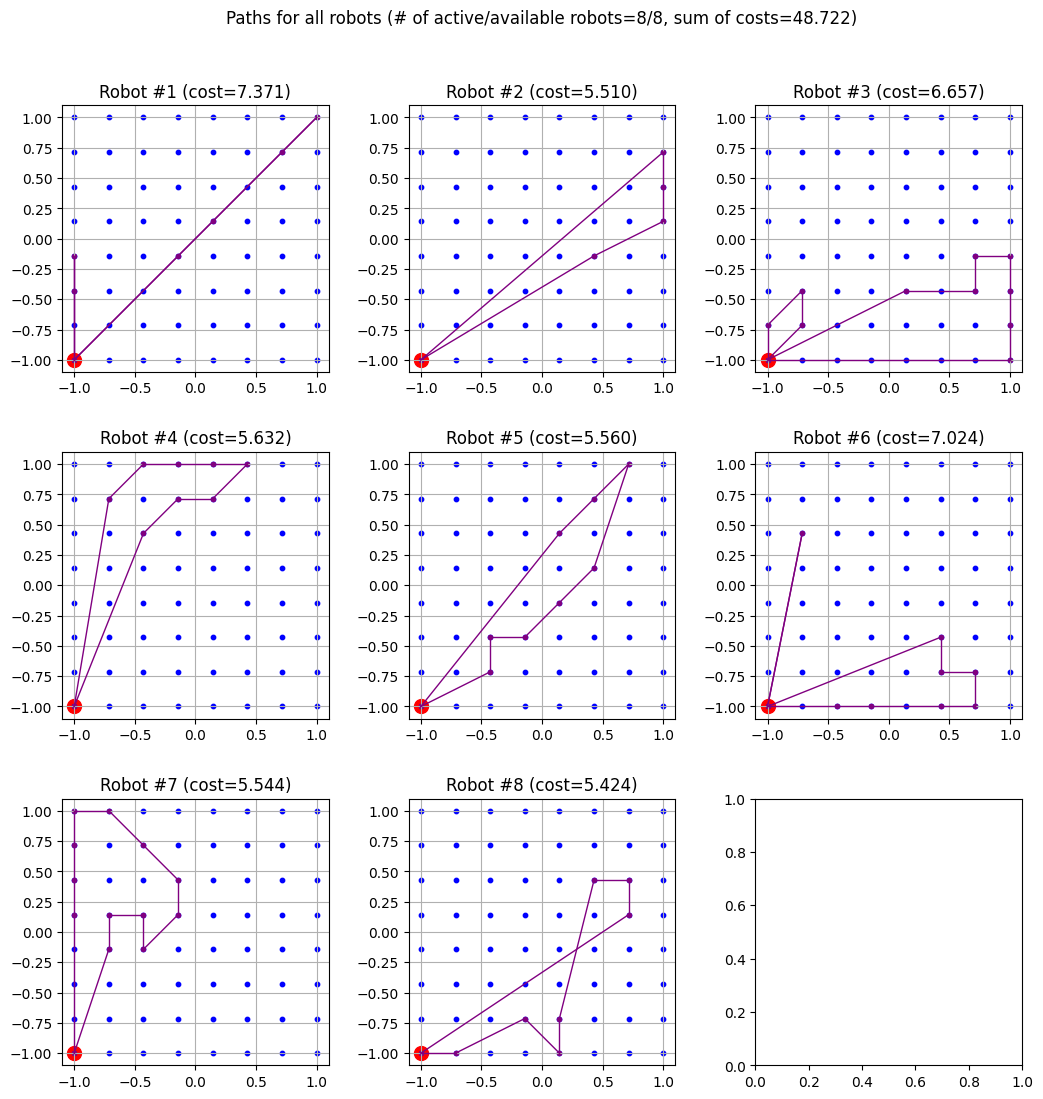

H 6010  2814                       7.3711400    2.28539  69.0%  6749 57619s
Found a new solution with lower cost(7.114)!


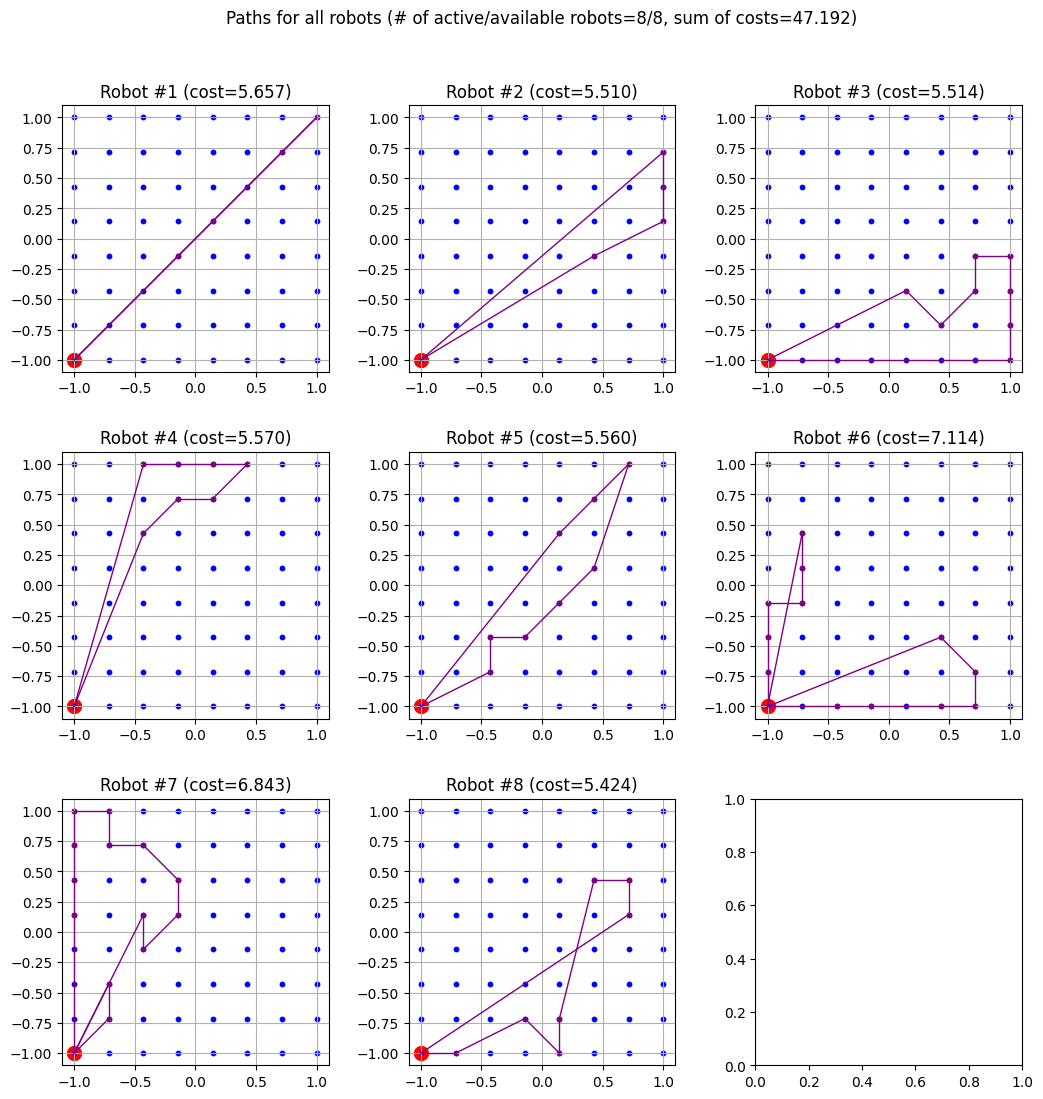

H 6147  2694                       7.1138280    2.28539  67.9%  6848 57621s
Found a new solution with lower cost(6.946)!


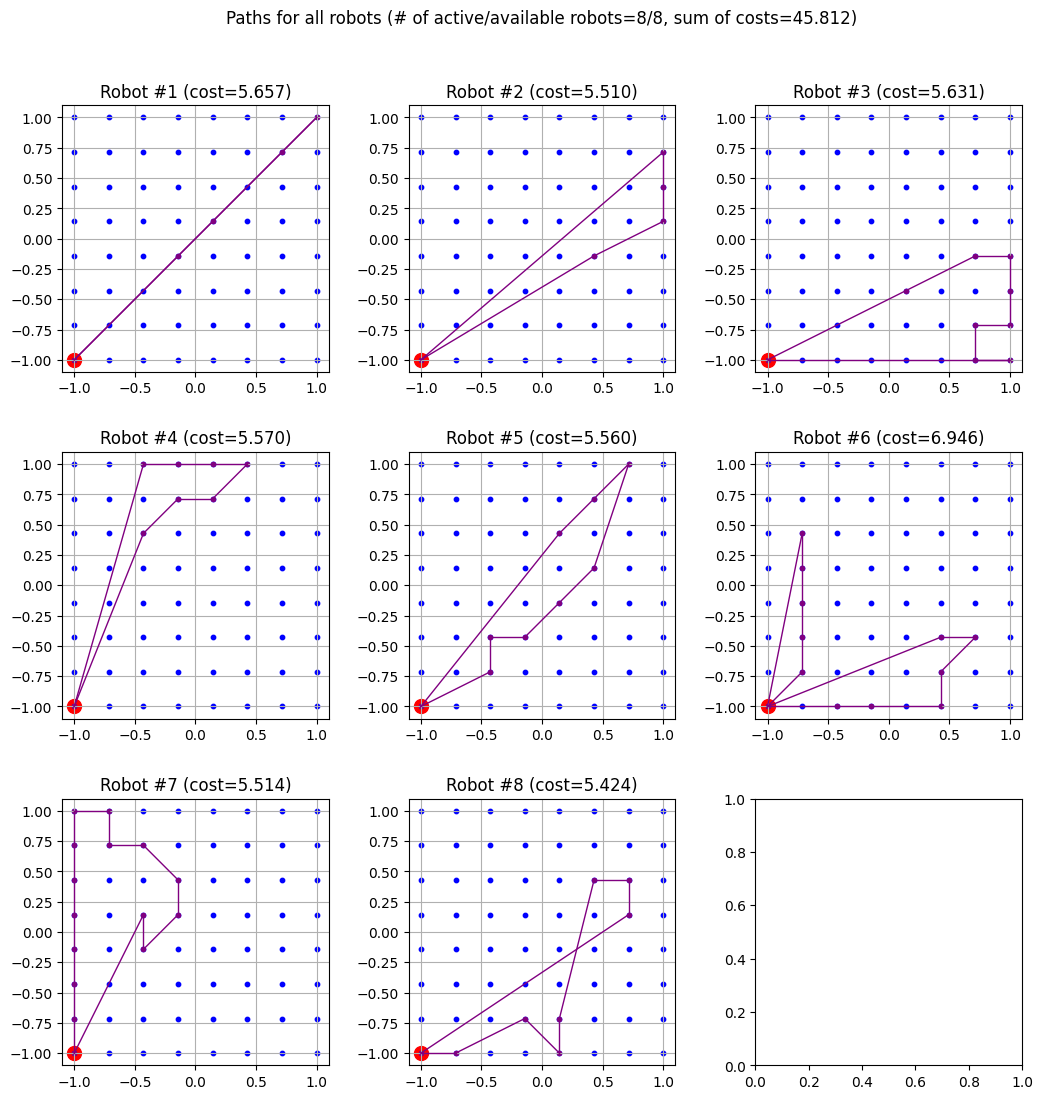

H 6384  2540                       6.9464604    2.28539  67.1%  6821 57623s
Found a new solution with lower cost(6.946)!


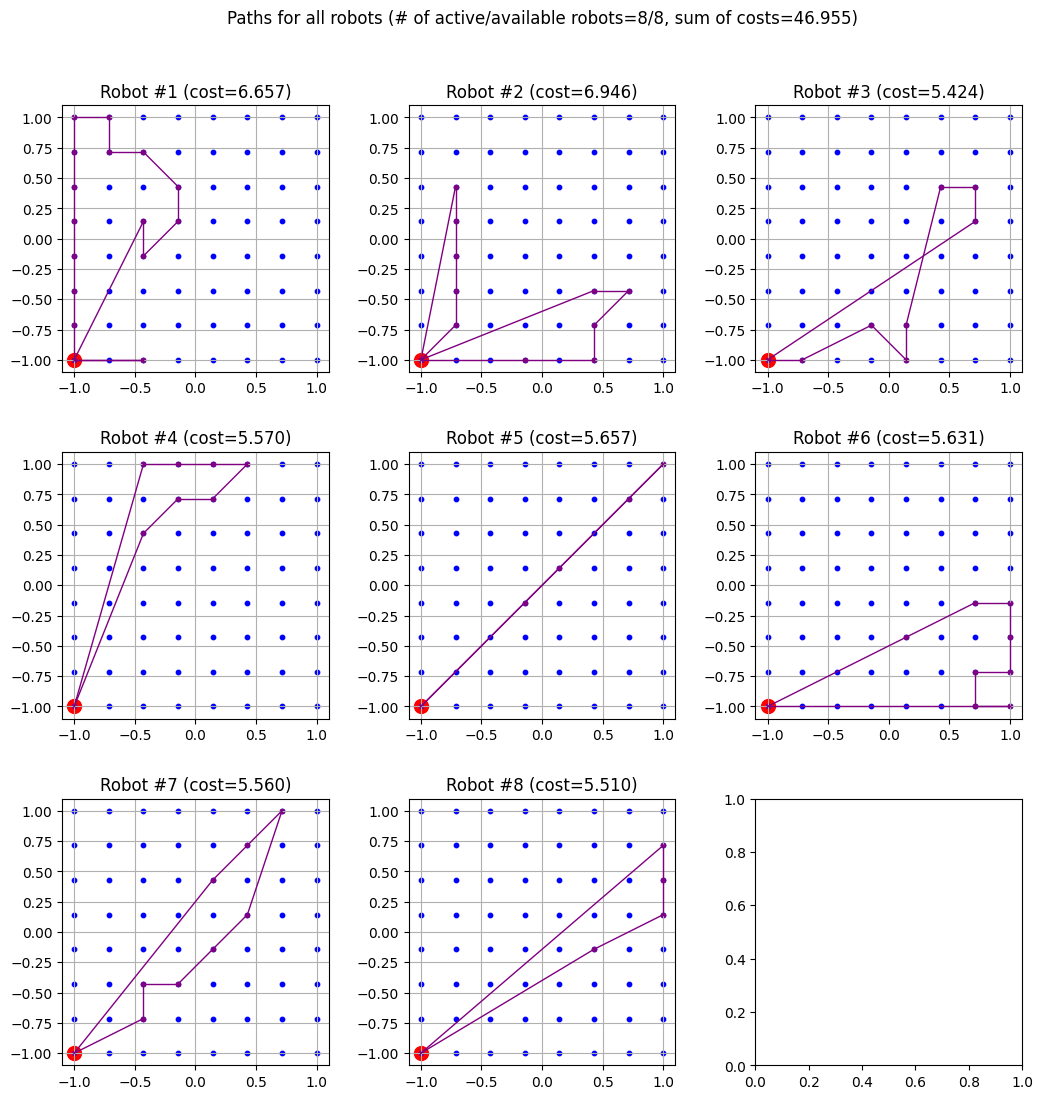

H 6611  2528                       6.9464595    2.28539  67.1%  6841 63889s
Found a new solution with lower cost(6.896)!


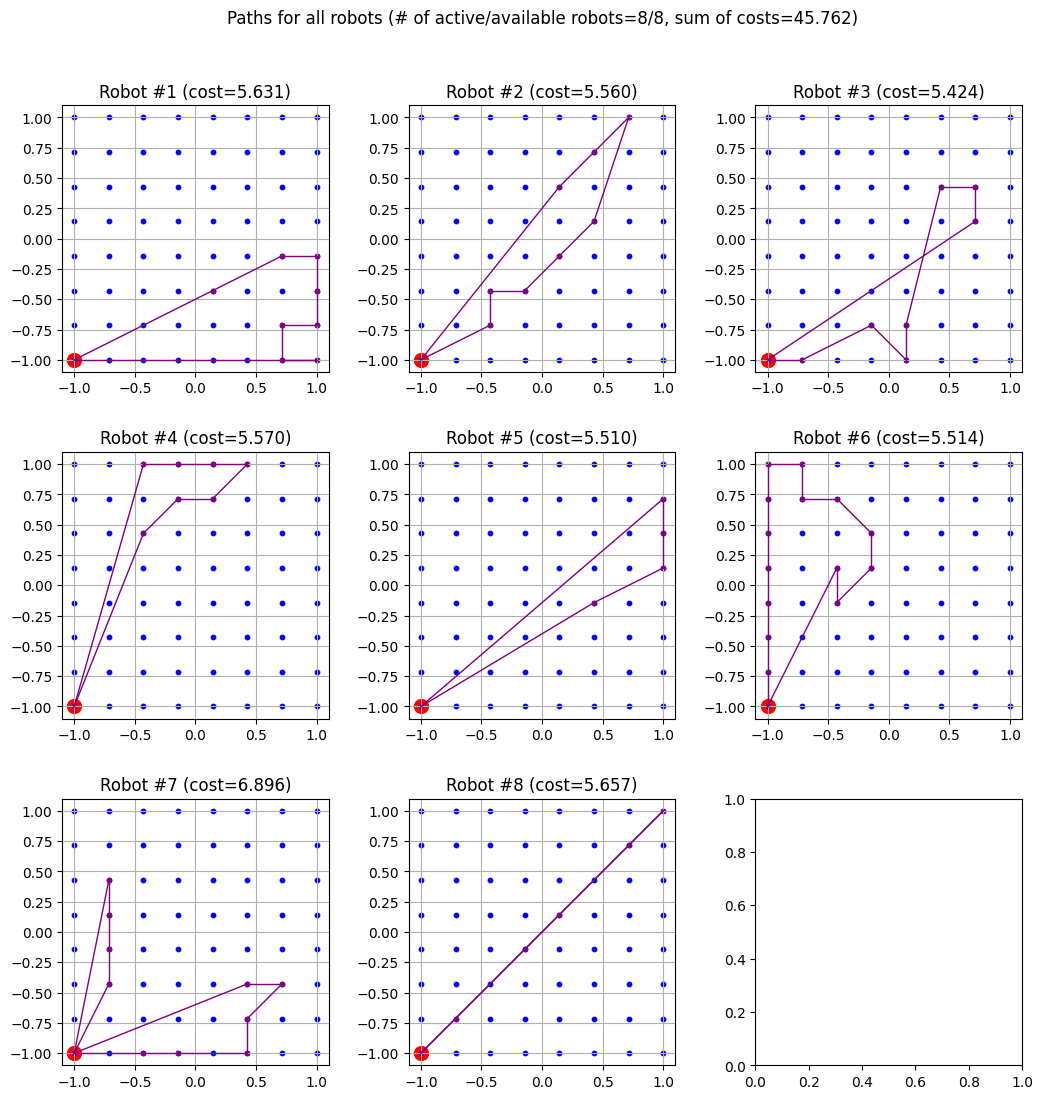

H 6731  2422                       6.8955612    2.28539  66.9%  6818 63892s
Found a new solution with lower cost(6.874)!


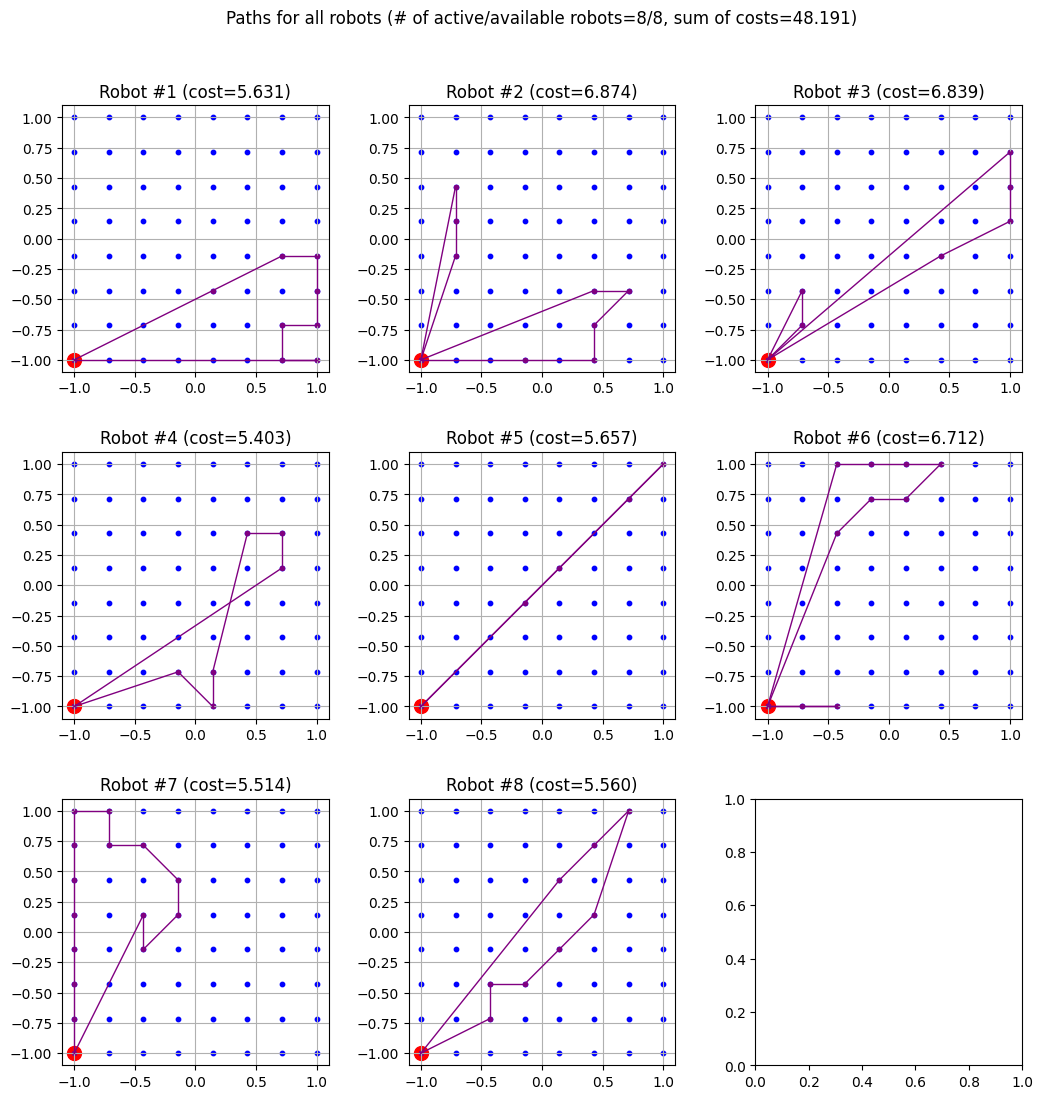

H 6733  2364                       6.8744787    2.28539  66.8%  6820 63894s
  6751  3423    2.31711   67  818    6.87448    2.28539  66.8%  6836 70399s
Found a new solution with lower cost(6.755)!


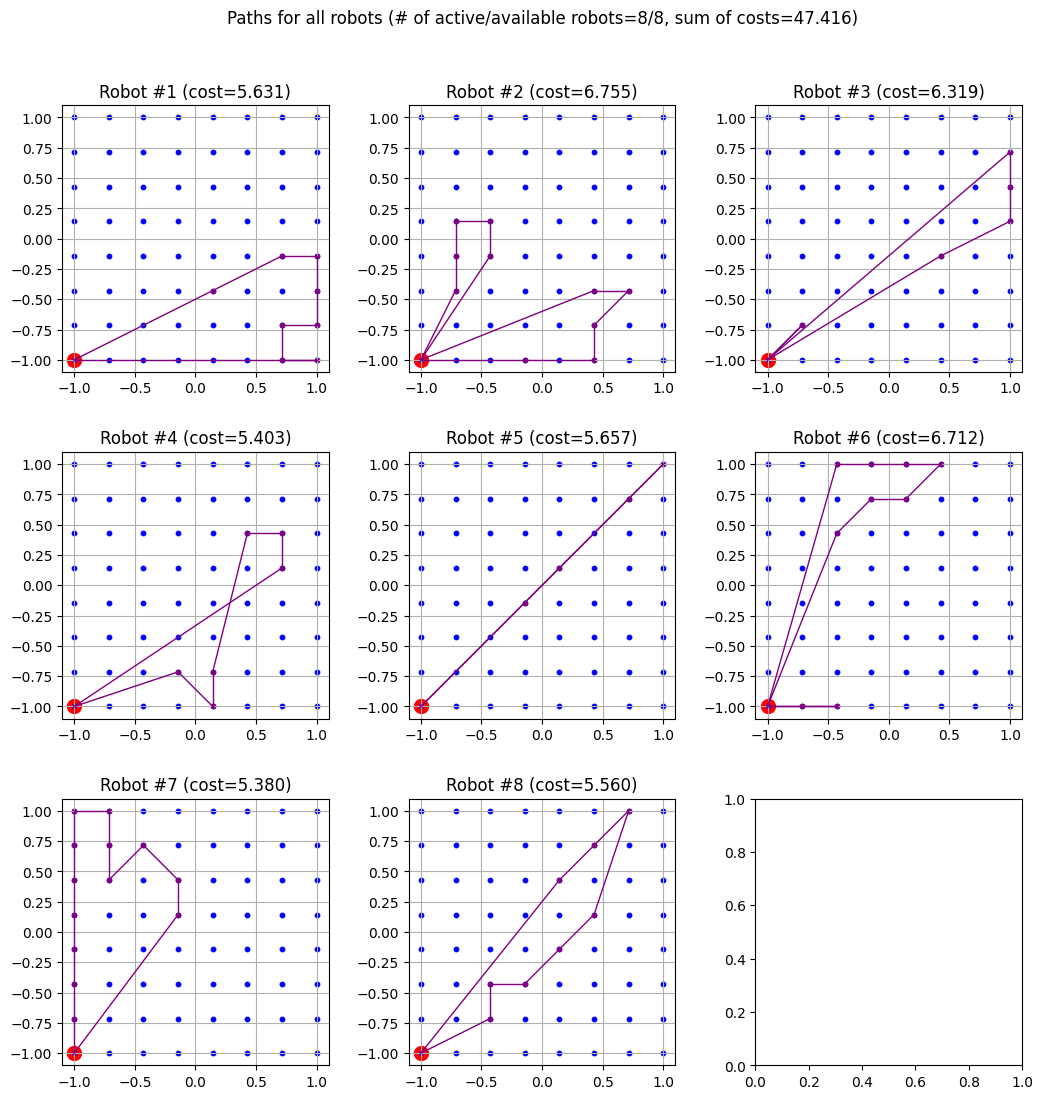

H 6999  3273                       6.7545707    2.28539  66.2%  6766 70402s
Found a new solution with lower cost(6.351)!


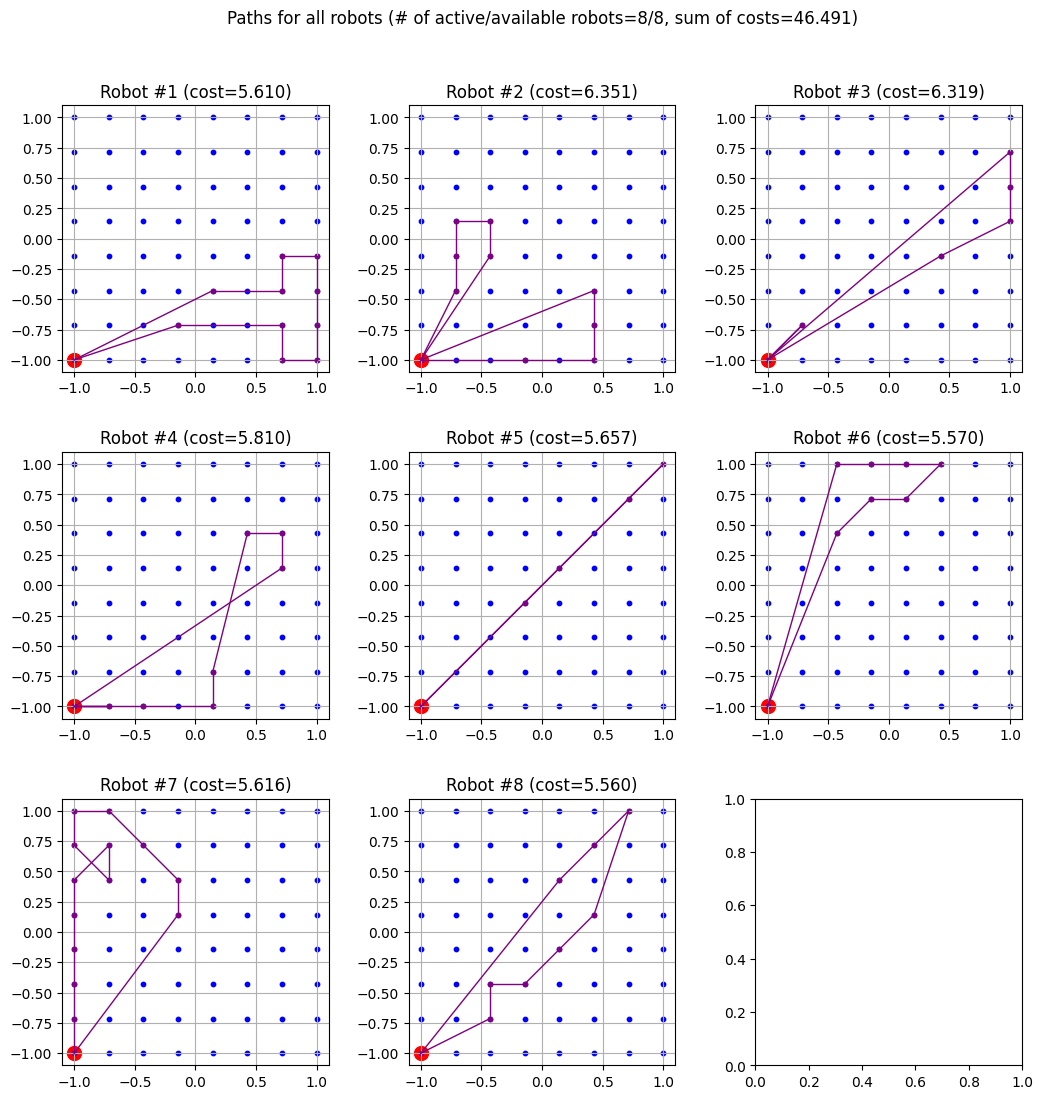

H 7907  4182                       6.3505097    2.28539  64.0%  6764 76355s
Found a new solution with lower cost(5.657)!


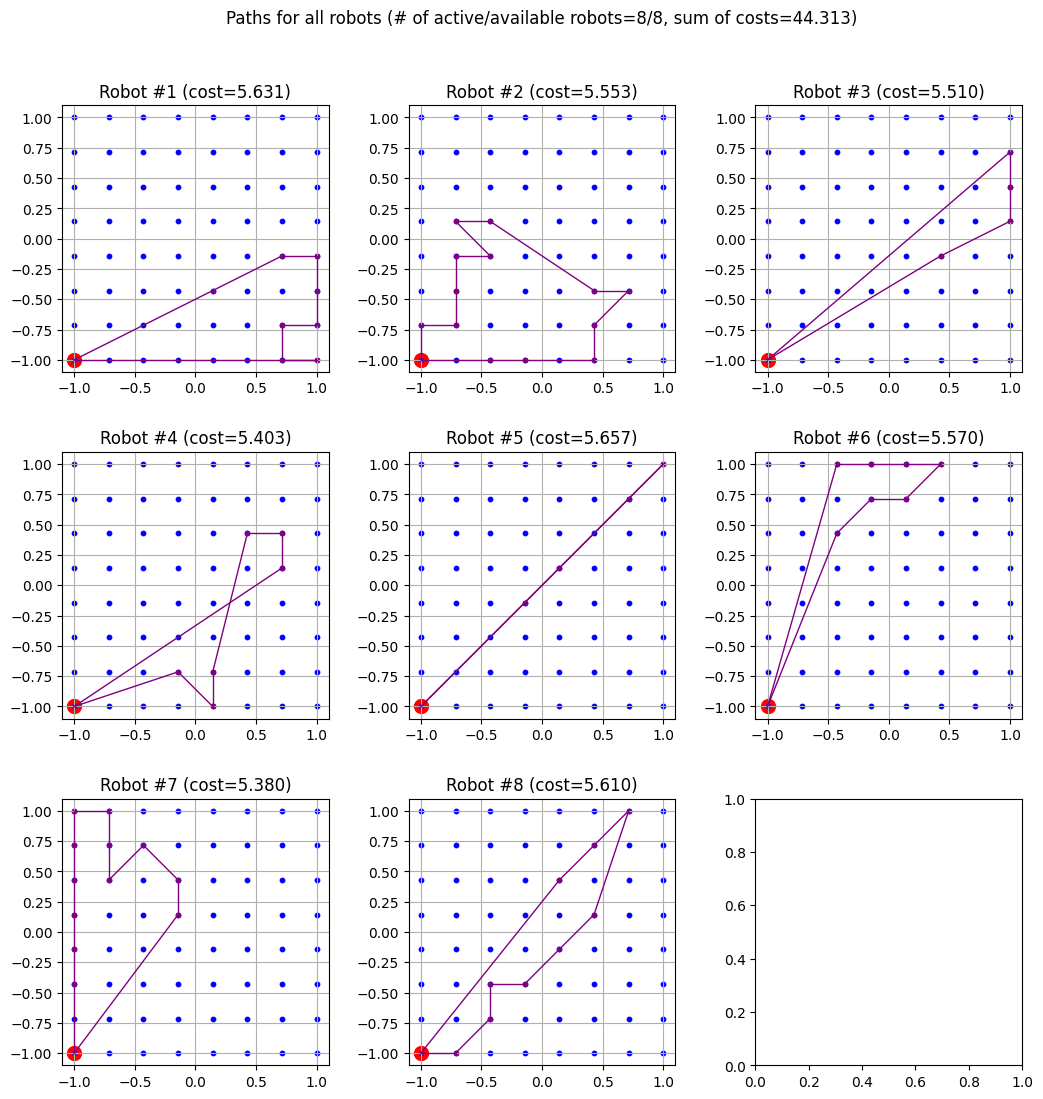

!This is guaranteed to be the optimal solution!
H 7966  4090                       5.6568542    2.28539  59.6%  6740 76357s

Cutting planes:
  Implied bound: 3
  Projected implied bound: 6
  MIR: 28
  StrongCG: 2
  Flow cover: 224
  Zero half: 2
  RLT: 2
  Relax-and-lift: 16

Explored 9239 nodes (58604873 simplex iterations) in 76358.60 seconds (61628.77 work units)
Thread count was 15 (of 20 available processors)

Solution count 10: 5.65685 6.35051 6.75457 ... 7.42783

Solve interrupted
Best objective 5.656854249492e+00, best bound 2.285387395970e+00, gap 59.5997%

User-callback calls 2018652, time in user-callback 178.41 sec


In [11]:
import os

# Get the number of available CPU threads
num_threads_available = os.cpu_count()

# Print the number of available CPU threads
print(f"Number of available CPU threads: {num_threads_available}")

num_threads = 15  # Adjust the number of threads as needed

# Create an instance of your MILP solver with multi-threading
solver = MILPSolver(m, num_threads)

# Set the number of threads for Gurobi
grb.setParam('Threads', num_threads)

m._x = x
# solver = MILPSolver(m)
solver.solve() # Optimize until the first optimal solution is found

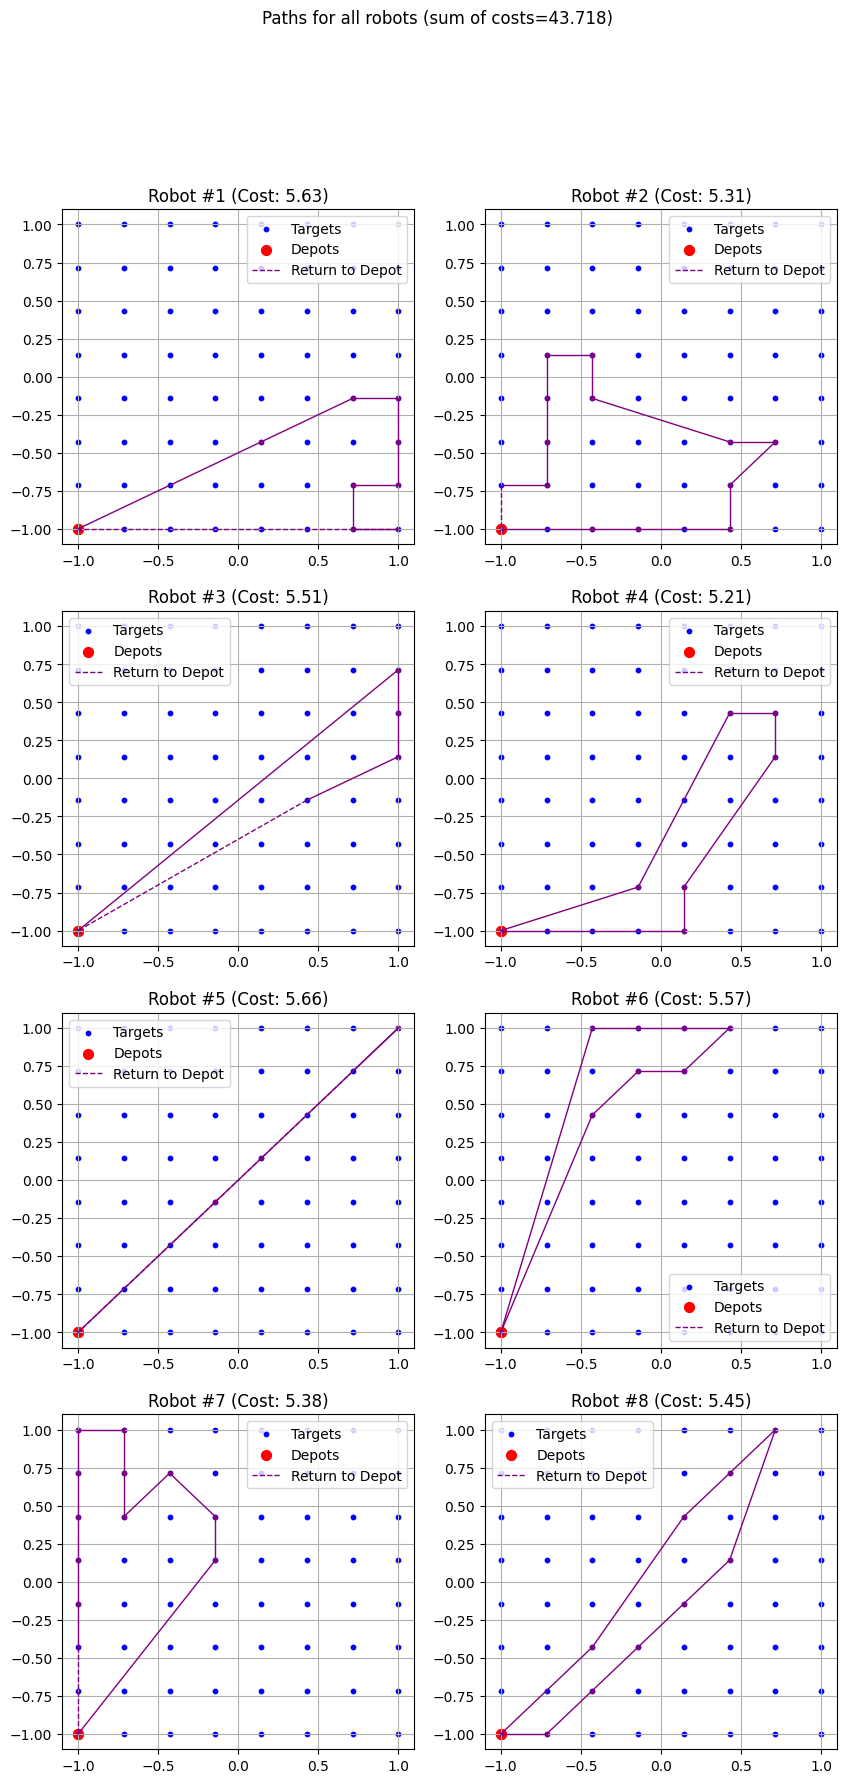

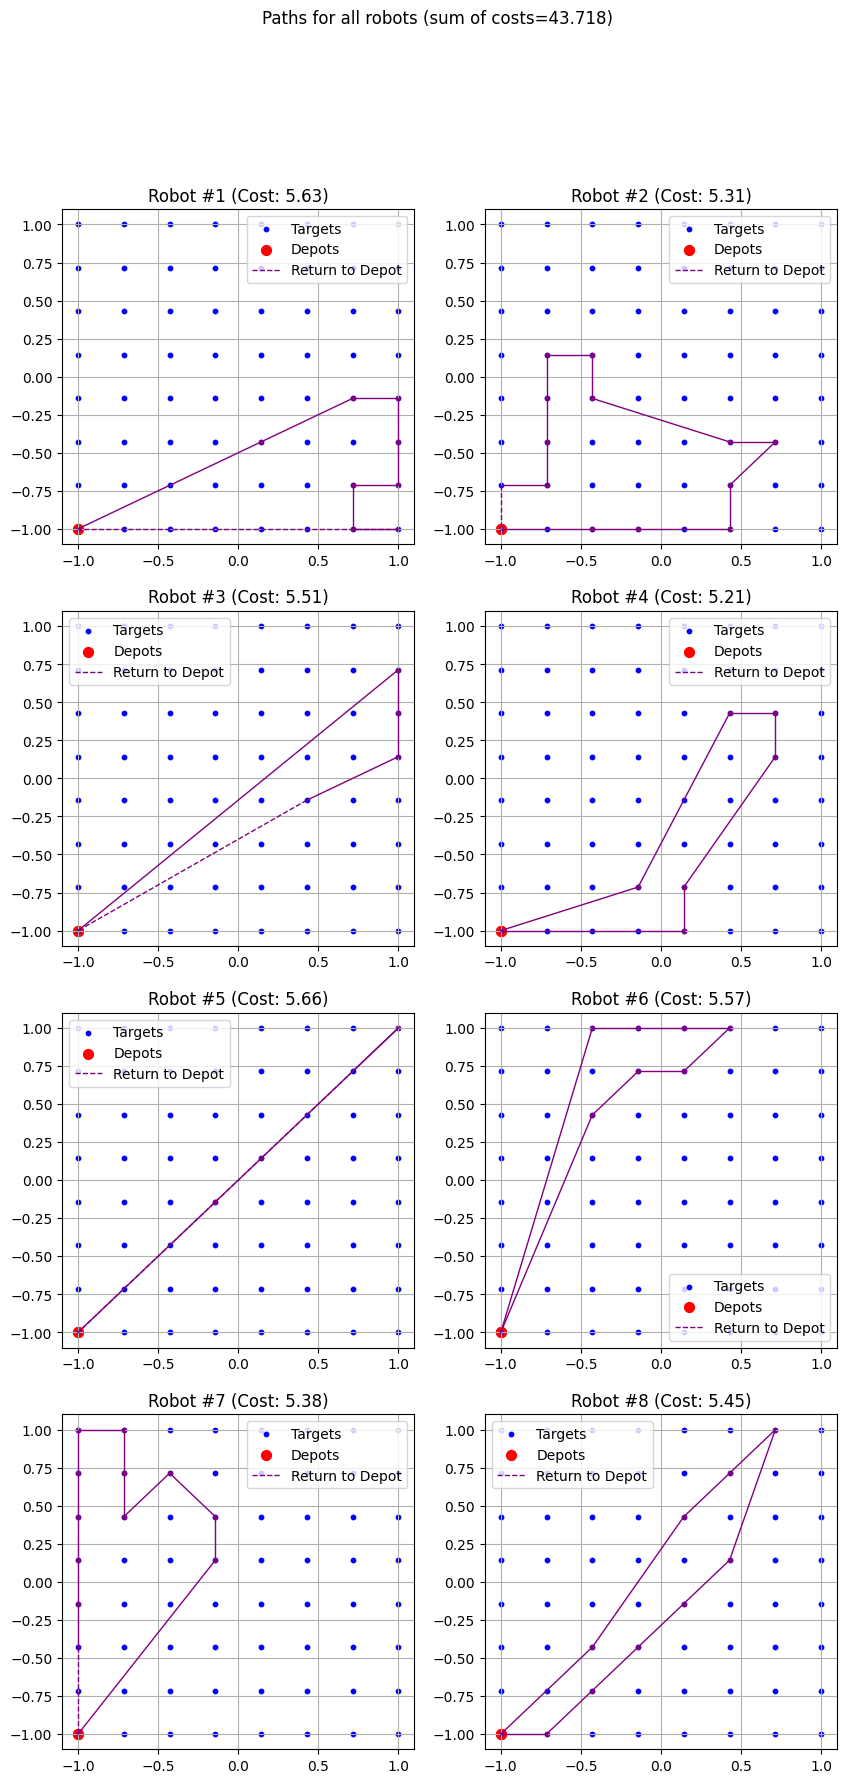

Cost reduction for Robot (two-opt) 1: 0.00
Cost reduction for Robot (two-opt) 2: 0.24
Cost reduction for Robot (two-opt) 3: 0.00
Cost reduction for Robot (two-opt) 4: 0.19
Cost reduction for Robot (two-opt) 5: 0.00
Cost reduction for Robot (two-opt) 6: 0.00
Cost reduction for Robot (two-opt) 7: 0.00
Cost reduction for Robot (two-opt) 8: 0.16
Cost reduction for Robot (k-opt) 1: 0.00
Cost reduction for Robot (k-opt) 2: 0.24
Cost reduction for Robot (k-opt) 3: 0.00
Cost reduction for Robot (k-opt) 4: 0.19
Cost reduction for Robot (k-opt) 5: 0.00
Cost reduction for Robot (k-opt) 6: 0.00
Cost reduction for Robot (k-opt) 7: 0.00
Cost reduction for Robot (k-opt) 8: 0.16


In [21]:
milp_solution_x = np.array([x[ki].X for ki in range(k)]).reshape(k, len(node_indices), len(node_indices))
milp_paths, milp_costs = extract_and_calculate_milp_costs(milp_solution_x, B_k, k, len(node_indices), cost)

# Apply 2-opt/3-opt algorithm to each path -> iteratively remove two/three edges and reconnect the two paths in a different way that reduces the total distance.
optimized_paths_2opt = [] # Initialize an empty list to store optimized paths
optimized_paths_kopt = []
for path in milp_paths:
    opt_path2, opt_dist2 = two_opt(path, cost)
    optimized_paths_2opt.append(opt_path2)
    
    # Apply 3-opt algorithm to each path
    opt_pathk, opt_distk = k_opt(path, cost, 3)
    optimized_paths_kopt.append(opt_pathk)

# Calculate costs for each robot
optimized_costs_2opt = [calculate_path_cost(path, cost) for path in optimized_paths_2opt] #two opt

optimized_costs_kopt = [calculate_path_cost(path, cost) for path in optimized_paths_kopt] # Calculate costs for each robot with 3-opt

# Call the updated visualization function with costs
visualize_individual_paths(optimized_paths_2opt, nodes, targets, depots, B_k, optimized_costs_2opt)
visualize_individual_paths(optimized_paths_kopt, nodes, targets, depots, B_k, optimized_costs_kopt) # three opt

# Calculate cost reduction for each robot
for index, (milp_cost, opt_cost) in enumerate(zip(milp_costs, optimized_costs_2opt)):
    cost_reduction = milp_cost - opt_cost
    print(f"Cost reduction for Robot (two-opt) {index + 1}: {cost_reduction:.2f}")
    
# Calculate cost reduction for each robot
for index, (milp_cost, opt_cost) in enumerate(zip(milp_costs, optimized_costs_kopt)):
    cost_reduction = milp_cost - opt_cost
    print(f"Cost reduction for Robot (k-opt) {index + 1}: {cost_reduction:.2f}")